## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera Calibration and Distortion correction

In [52]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [53]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

def undistort_image(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return cv2.undistort(img, mtx, dist, None, mtx)

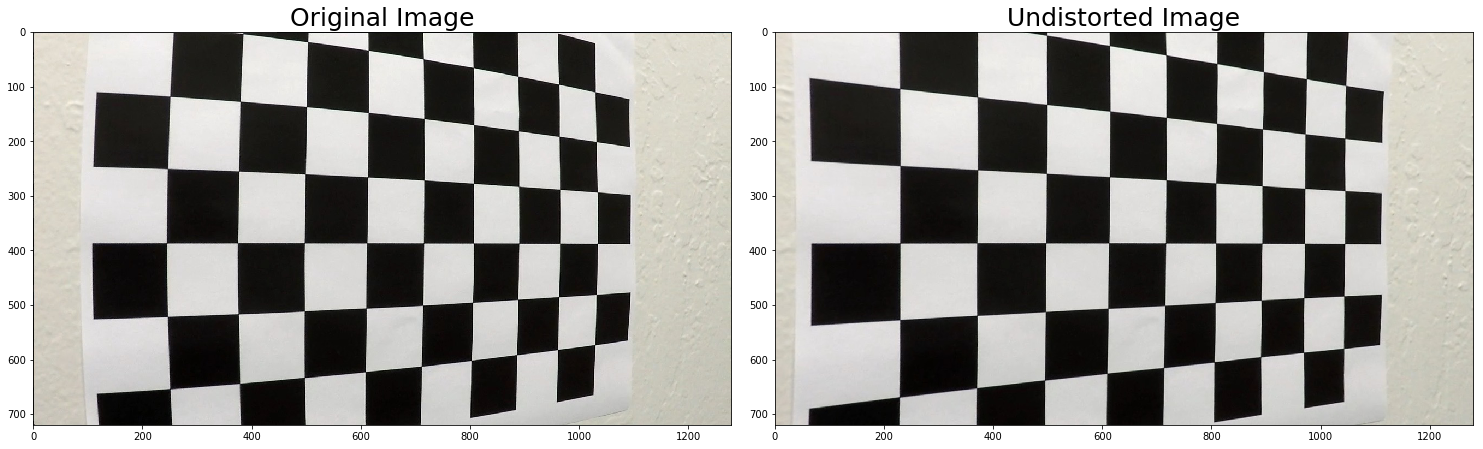

In [54]:
#test undistort_image function
img_org = mpimg.imread('./camera_cal/calibration5.jpg')
img_undistorted = undistort_image(img_org,objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(img_org)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Color/gradient Threshold


In [55]:
# Retuns binary image based on thresholding functions
def pipeline(img,sobel_kernel=3,sx_thresh=(20,100), s_thresh=(170,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
 
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
 
        # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary


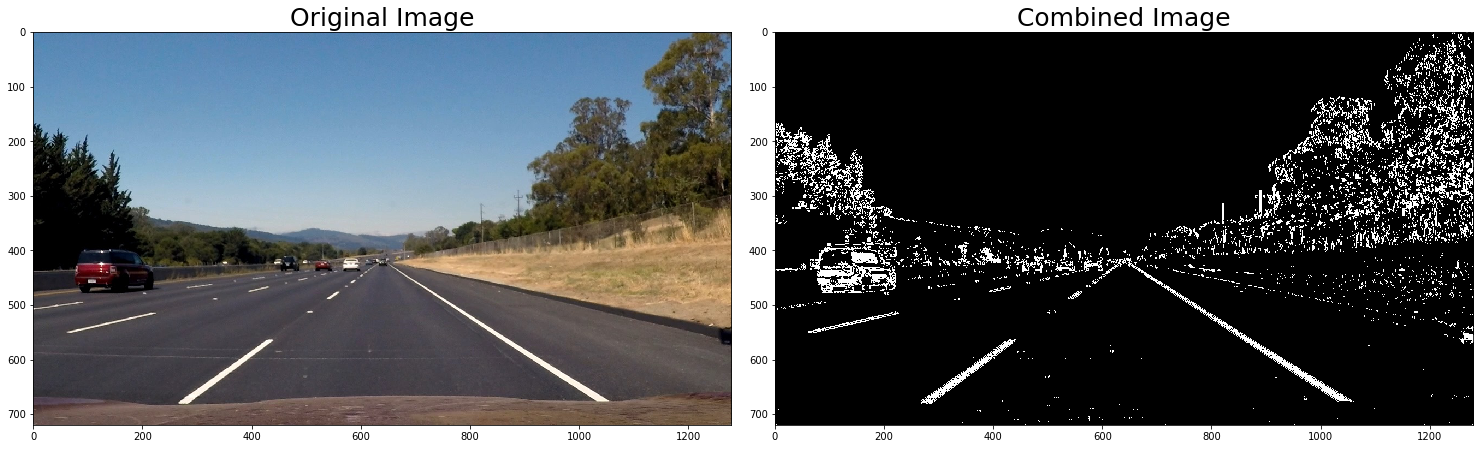

In [56]:
# Read in an image
test_image = mpimg.imread('./test_images/straight_lines2.jpg')

# Obtain binary image
combined = pipeline(test_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
f.savefig('output_images/undistort_output.jpg')

## Perspective Transformation

In [57]:
#src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
#dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
#src = np.float32([(510, 480), (780, 480), (1180, 670), (210, 670)])
#dst = np.float32([(320, 0), (1000, 0), (1000, 720), (320, 720)])
#src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
#src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
#dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
img_size = (img.shape[1], img.shape[0])

#src = np.float32([[570, 480],[740, 480],[1150, 720],[180, 720]])
#src = np.float32([[580, 450],[700, 450],[1150, 720],[180, 720]])
#dst = np.float32([[100, 0], [1125, 0], [1150, 720],[200, 720]])
#src = np.float32([[585, 460],[203, 720],[1126, 720],[695, 460]])
src = np.float32([[585, 460],[695, 460],[1126, 720],[203, 720]])
dst = np.float32([[300, 0],[1000,0], [960, 720], [320, 720]])
def warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

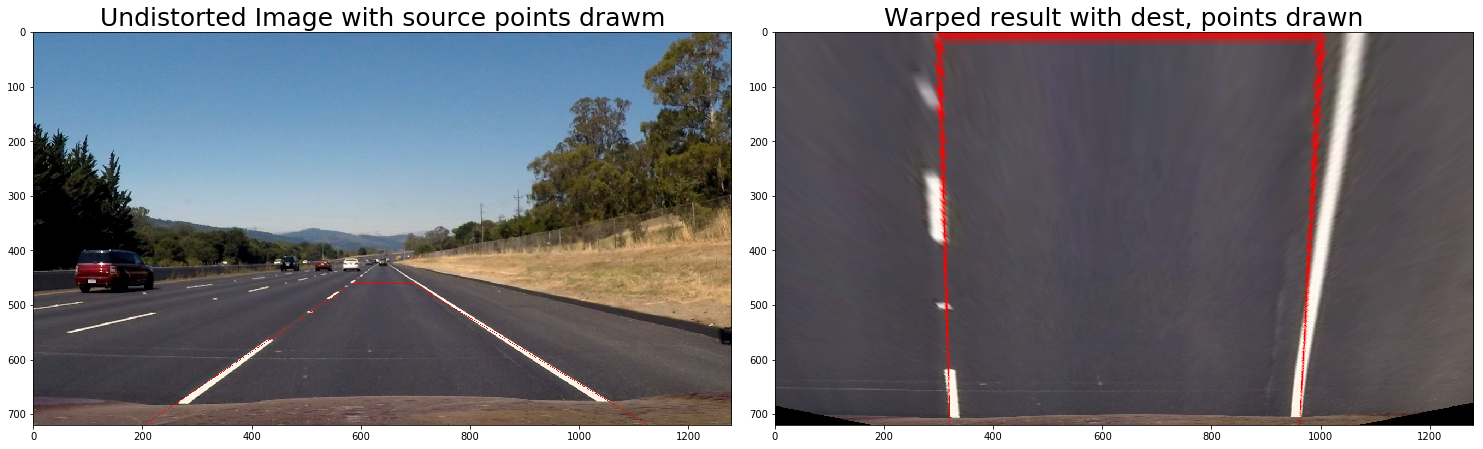

In [58]:
def make_plot(img, points, color=[255,0,0], thickness=1):
#    image = np.copy(img)
    cv2.line(img, (points[0][0], points[0][1]), (points[1][0], points[1][1]), color, thickness)
    cv2.line(img, (points[1][0], points[1][1]), (points[2][0], points[2][1]), color, thickness)
    cv2.line(img, (points[2][0], points[2][1]), (points[3][0], points[3][1]), color, thickness)
    cv2.line(img, (points[3][0], points[3][1]), (points[0][0], points[0][1]), color, thickness)
    return img

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
f.tight_layout()
ax1.set_title('Undistorted Image with source points drawm',fontsize=25)
ax1.imshow(make_plot(test_image, src))
ax2.set_title('Warped result with dest, points drawn',fontsize=25)
warped_img, M, Minv = warp(test_image,src,dst)
ax2.imshow(make_plot(warped_img, dst))
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)   
plt.show()

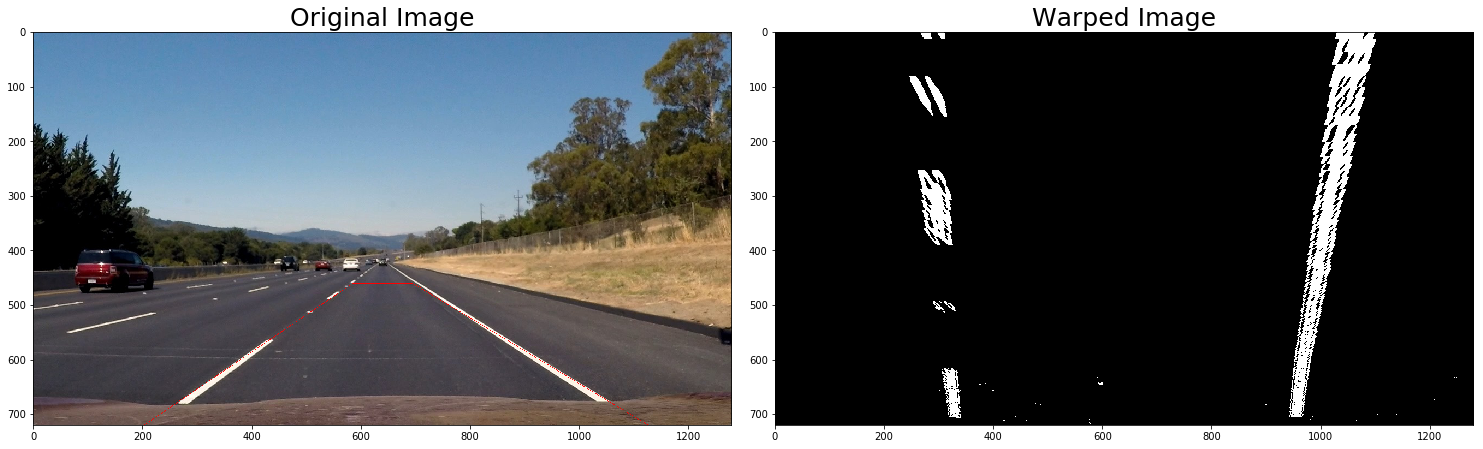

In [59]:
# Obtain binary image
warped_img, M, Minv = warp(combined, src, dst)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(warped_img, cmap='gray')
ax2.set_title('Warped Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

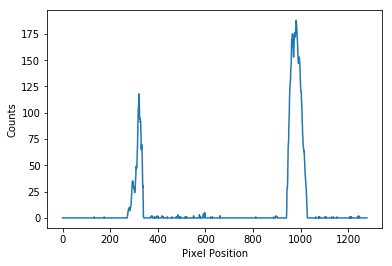

In [60]:
# Histogram Plotting
histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.xlabel('Pixel Position')
plt.ylabel('Counts')
plt.show()

## Find the Lines


In [61]:

# Take a histogram of the bottom half of the image
#
# Create an output image to draw on and  visualize the result
def sliding_fit(img, margin=100, minpix=50):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    rectangles = []

# Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangles.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles

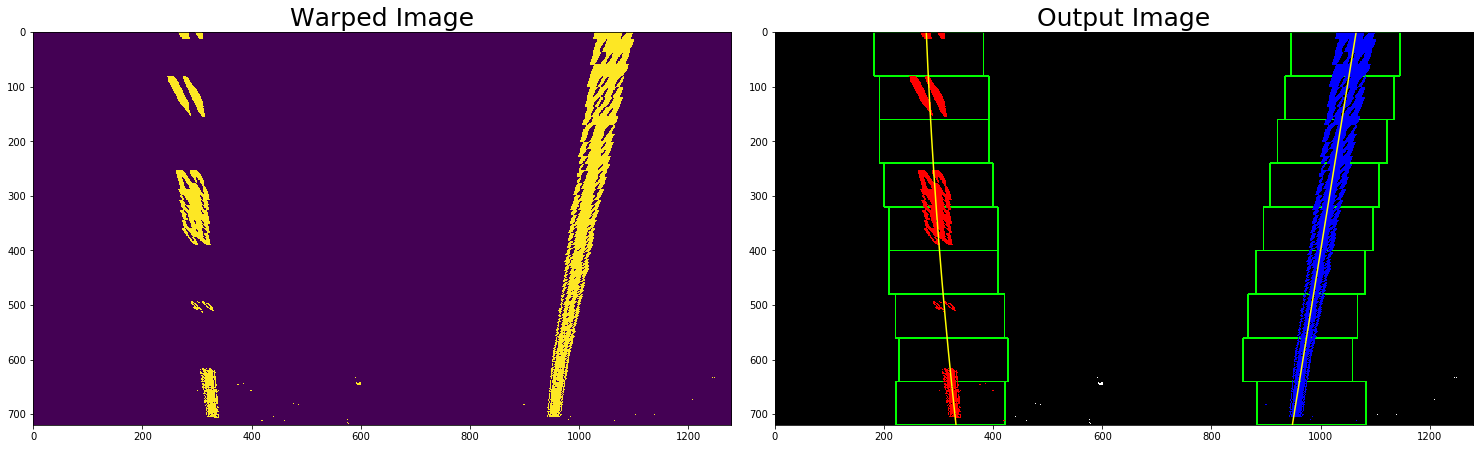

In [62]:
#Visualization
out_img = np.dstack((warped_img, warped_img, warped_img))*255
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = sliding_fit(warped_img)
ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

for rectangle in rectangles: 
    cv2.rectangle(out_img, (rectangle[5], rectangle[1]), (rectangle[4], rectangle[0]), (0,255,0), 2) 
    cv2.rectangle(out_img, (rectangle[3], rectangle[1]), (rectangle[2], rectangle[0]), (0,255,0), 2) 
    
nonzero = warped_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.set_title('Warped Image',fontsize=25)
ax1.imshow(warped_img)
ax2.set_title('Output Image',fontsize=25)
ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [63]:
def further_fit(img, left_fit, right_fit):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_new = np.polyfit(lefty, leftx, 2)
    right_fit_new = np.polyfit(righty, rightx, 2)
    
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds


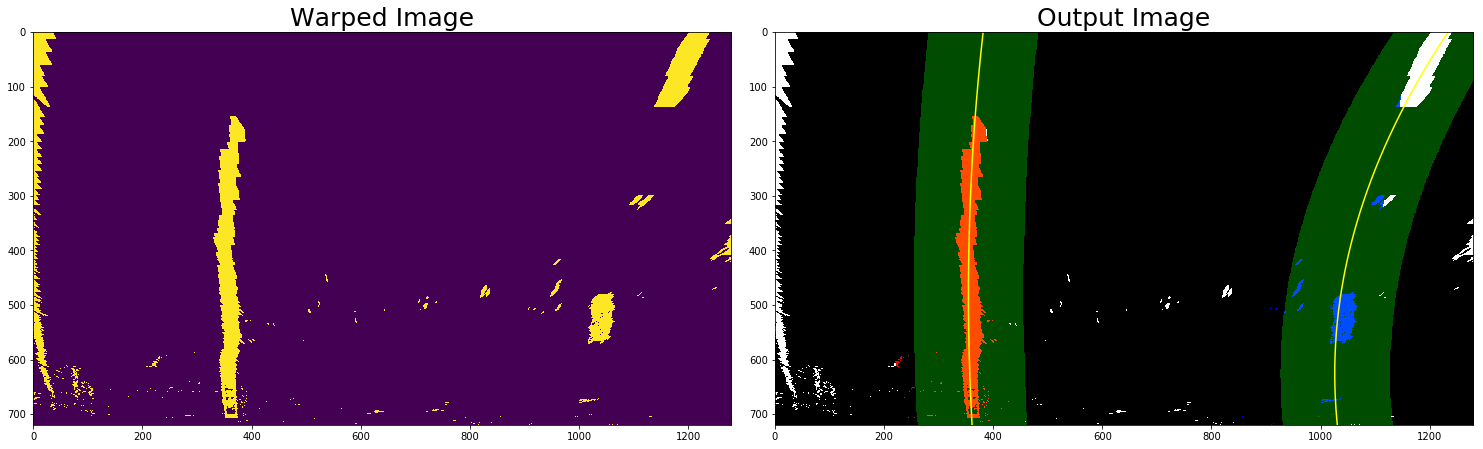

In [65]:
# Visulalization
test_image_new = mpimg.imread('./test_images/test4.jpg')
combined_new = pipeline(test_image_new)
warped_img_new, _, Minv = warp(combined_new, src, dst)

left_fit_new, right_fit_new, left_lane_inds_new, right_lane_inds_new = further_fit(warped_img_new, left_fit, right_fit)
ploty = np.linspace(0, warped_img_new.shape[0]-1, warped_img_new.shape[0] )
left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped_img_new, warped_img_new, warped_img_new))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = warped_img_new.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds_new], nonzerox[left_lane_inds_new]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds_new], nonzerox[right_lane_inds_new]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
margin = 100
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.set_title('Warped Image',fontsize=25)
ax1.imshow(warped_img_new)
ax2.set_title('Output Image',fontsize=25)
ax2.imshow(result)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Measure Curvature and Offset

In [66]:
def compute_curvature_offset(img, left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    lane_center = np.mean([left_fitx[-1], right_fitx[-1]])
    offset = ((img.shape[1] / 2) - lane_center) * xm_per_pix
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm', offset, 'm')
    return left_curverad, right_curverad, offset

In [67]:
def add_measurements(img, left_curverad, right_curverad, offset):
    # add curverature to image
    text = "Radius of Curvature= {:.2f}(m)".format(int((left_curverad + right_curverad)/2))
    cv2.putText(img, text, (50,50), cv2.FONT_HERSHEY_DUPLEX, 1,(0,255,0), 1)
    
    # add lane offset to image
    if offset > 0:
        text = "Vehicle is {:.2f}m right of center".format(offset)
    elif offset < 0:
        text = "Vehicle is {:.2f}m left of center".format(offset)
    cv2.putText(img, text, (50,100), cv2.FONT_HERSHEY_DUPLEX, 1,(0,255,0), 1)
    return img

## Draw Lines

In [68]:
def draw(img, warped_img, left_fit, right_fit, Minv):
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])

       
    left_fitx = left_fit[0]*ploty**2 +left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

In [69]:
def process_image(img):
    combined_img = pipeline(img)
    warped_img, M, Minv = warp(combined_img, src, dst)
    
    if not left_line.detected or not right_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds, _ = sliding_fit(warped_img)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = further_fit(warped_img, left_line.best_fit, right_line.best_fit)

    left_line.lane_fit(left_fit)
    right_line.lane_fit(right_fit)
    
    img = draw(img, combined_img, left_line.best_fit, right_line.best_fit, Minv)
    left_curverad, right_curverad, offset = compute_curvature_offset(img, left_fit, right_fit)
    final_img =add_measurements(img, left_curverad, right_curverad, offset)

    return final_img

In [70]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def lane_fit(self, fit):
        if self.best_fit is not None:
            self.diffs = abs(fit-self.best_fit)
        if (self.diffs[0] > 0.01 or self.diffs[1] > 1.0 or self.diffs[2] > 100.0) and len(self.current_fit) > 0:
            self.detected = False
        else:
            self.detected = True
            
            self.current_fit.append(fit)

            if len(self.current_fit) > 10:
                self.current_fit = self.current_fit[len(self.current_fit)- 10:]
            self.best_fit = np.average(self.current_fit, axis=0)
      

## Video Test

In [71]:

left_line = Line()
right_line = Line()

video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
processed_video = video_input.fl_image(process_image)
processed_video.write_videofile(video_output, audio=False)

629.755661246 m 1029.32776988 m -0.2910488942 m
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

694.855116944 m 1000.2104878 m -0.294111897918 m
707.31528312 m 1039.47401841 m -0.298615948009 m


  0%|▏                                                                                | 2/1261 [00:00<01:35, 13.21it/s]

637.276943667 m 600.250826771 m -0.280857823189 m
771.354472882 m 573.447105583 m -0.29570393219 m


  0%|▎                                                                                | 4/1261 [00:00<01:35, 13.16it/s]

735.938807773 m 684.501701945 m -0.309070362971 m
743.467979792 m 895.44466149 m -0.321302301353 m


  0%|▍                                                                                | 6/1261 [00:00<01:35, 13.10it/s]

655.926395813 m 1403.70562486 m -0.337193422782 m
669.612413785 m 1875.55242595 m -0.425859695737 m


  1%|▌                                                                                | 8/1261 [00:00<01:37, 12.90it/s]

727.223527982 m 1314.83050653 m -0.431716837652 m
730.495797884 m 1792.0058737 m -0.407931230163 m


  1%|▋                                                                               | 10/1261 [00:00<01:37, 12.82it/s]

748.652967679 m 2185.12572242 m -0.351059820344 m
812.551579696 m 4146.21049427 m -0.352760692431 m


  1%|▊                                                                               | 12/1261 [00:00<01:37, 12.86it/s]

842.387908399 m 2140.36186041 m -0.342487321563 m
986.690247201 m 4752.308111 m -0.348224690698 m


  1%|▉                                                                               | 14/1261 [00:01<01:36, 12.94it/s]

975.039400241 m 824.508235388 m -0.315468528017 m
1503.81113508 m 668.72644551 m -0.313888647437 m


  1%|█                                                                               | 16/1261 [00:01<01:36, 12.97it/s]

1158.99556753 m 911.98967749 m -0.313282343756 m
1289.04664319 m 1310.42511898 m -0.31899695143 m


  1%|█▏                                                                              | 18/1261 [00:01<01:35, 12.96it/s]

1137.93137386 m 1496.92414607 m -0.314196641733 m
1146.47174501 m 2511.54072608 m -0.327072407719 m


  2%|█▎                                                                              | 20/1261 [00:01<01:37, 12.78it/s]

1170.22618372 m 9691.28856249 m -0.35447702524 m
1168.55104279 m 3174.0542421 m -0.354777632147 m


  2%|█▍                                                                              | 22/1261 [00:01<01:36, 12.86it/s]

1074.5214565 m 6382.42604395 m -0.322272318017 m
958.150591087 m 1099.28667053 m -0.262237351462 m


  2%|█▌                                                                              | 24/1261 [00:01<01:35, 12.91it/s]

939.551476297 m 893.549438057 m -0.254159334469 m
1044.93544012 m 1102.09421356 m -0.257773290301 m


  2%|█▋                                                                              | 26/1261 [00:02<01:35, 12.90it/s]

1002.44187651 m 1497.15759433 m -0.260851229632 m
1017.32987403 m 1673.4906595 m -0.259631907717 m


  2%|█▊                                                                              | 28/1261 [00:02<01:35, 12.92it/s]

1029.82167603 m 852.792025213 m -0.247068661845 m
964.865547603 m 557.02539787 m -0.236885068304 m


  2%|█▉                                                                              | 30/1261 [00:02<01:34, 13.00it/s]

859.746109354 m 648.691262318 m -0.244908849921 m
703.851387066 m 1021.6861749 m -0.25715360649 m


  3%|██                                                                              | 32/1261 [00:02<01:34, 12.99it/s]

696.59517116 m 2426.93364257 m -0.292972017894 m
628.70408142 m 4403.67061452 m -0.334842008669 m


  3%|██▏                                                                             | 34/1261 [00:02<01:35, 12.83it/s]

611.014982208 m 8751.62264826 m -0.316321852461 m
556.482626669 m 725.770652821 m -0.239171939412 m


  3%|██▎                                                                             | 36/1261 [00:02<01:35, 12.86it/s]

540.883390716 m 789.921710919 m -0.244339261209 m
490.930626339 m 1234.82227269 m -0.260535685126 m


  3%|██▍                                                                             | 38/1261 [00:02<01:34, 12.89it/s]

498.746235074 m 546.622696338 m -0.228857972447 m
494.544470952 m 472.516791069 m -0.228383294871 m


  3%|██▌                                                                             | 40/1261 [00:03<01:34, 12.98it/s]

512.874084661 m 530.803216004 m -0.24275952354 m
530.182776298 m 569.784755583 m -0.253283851969 m


  3%|██▋                                                                             | 42/1261 [00:03<01:34, 12.92it/s]

555.711884175 m 605.131546045 m -0.267586516674 m
535.790140651 m 690.057638688 m -0.268916417486 m


  3%|██▊                                                                             | 44/1261 [00:03<01:44, 11.64it/s]

605.505207071 m 959.93849488 m -0.29485228477 m
624.701541612 m 4790.2803423 m -0.354553200376 m


  4%|██▉                                                                             | 46/1261 [00:03<01:48, 11.20it/s]

639.961925359 m 16226.1684879 m -0.355669394265 m
637.972368851 m 17643.6170691 m -0.340320724633 m


  4%|███                                                                             | 48/1261 [00:03<01:48, 11.20it/s]

678.955100922 m 1056.55955286 m -0.291949625006 m
726.434404233 m 700.932895859 m -0.277435325149 m


  4%|███▏                                                                            | 50/1261 [00:03<01:44, 11.55it/s]

755.129697106 m 1240.15395989 m -0.300411747882 m
846.629231725 m 1027.89579501 m -0.295722294614 m


  4%|███▎                                                                            | 52/1261 [00:04<01:43, 11.67it/s]

922.546141138 m 517.545956551 m -0.266377734014 m
997.893293733 m 528.844615861 m -0.271411676877 m


  4%|███▍                                                                            | 54/1261 [00:04<01:41, 11.92it/s]

1311.67501246 m 602.690461274 m -0.283136976459 m
1262.46846975 m 670.095720897 m -0.282531476726 m


  4%|███▌                                                                            | 56/1261 [00:04<01:40, 12.03it/s]

1226.03209461 m 940.956109092 m -0.29374633084 m
1263.12837376 m 2288.32155762 m -0.328820892224 m


  5%|███▋                                                                            | 58/1261 [00:04<01:43, 11.63it/s]

1054.49340626 m 16232.134948 m -0.344455530491 m
1006.81411225 m 1068.0308675 m -0.272020805097 m


  5%|███▊                                                                            | 60/1261 [00:04<01:46, 11.30it/s]

791.092403527 m 2527.03688197 m -0.279478275709 m
735.494489258 m 793.673059666 m -0.233035053989 m


  5%|███▉                                                                            | 62/1261 [00:05<01:45, 11.31it/s]

722.860383687 m 1027.57978405 m -0.229971162246 m
737.452792602 m 597.350601399 m -0.20448761854 m


  5%|████                                                                            | 64/1261 [00:05<01:41, 11.74it/s]

782.193020562 m 659.075110573 m -0.206430792022 m
725.485376154 m 835.840394984 m -0.209688804801 m


  5%|████▏                                                                           | 66/1261 [00:05<01:40, 11.93it/s]

742.653040228 m 989.075166662 m -0.207760546192 m
820.581041482 m 1133.74215627 m -0.208161914098 m


  5%|████▎                                                                           | 68/1261 [00:05<01:43, 11.54it/s]

776.368862911 m 1950.91887046 m -0.212166002548 m
824.87330827 m 2106.07234139 m -0.216743813839 m


  6%|████▍                                                                           | 70/1261 [00:05<01:43, 11.48it/s]

884.841091409 m 1153.07727326 m -0.19710106178 m
997.969938076 m 741.137663356 m -0.162581138625 m


  6%|████▌                                                                           | 72/1261 [00:05<01:40, 11.82it/s]

1141.22783527 m 709.835945321 m -0.16550709292 m
1394.15334078 m 1008.72261954 m -0.18344231807 m


  6%|████▋                                                                           | 74/1261 [00:06<01:39, 11.98it/s]

1819.9743316 m 1172.08735135 m -0.187156066043 m
1947.71295072 m 754.839829144 m -0.16841036562 m


  6%|████▊                                                                           | 76/1261 [00:06<01:38, 12.08it/s]

2354.53922555 m 1154.05394357 m -0.180570902097 m
2440.85492532 m 682.325944338 m -0.16208762699 m


  6%|████▉                                                                           | 78/1261 [00:06<01:37, 12.17it/s]

2261.17002766 m 516.943838425 m -0.149453334691 m
2280.1048032 m 551.843516449 m -0.146762431121 m


  6%|█████                                                                           | 80/1261 [00:06<01:35, 12.30it/s]

2236.04275436 m 661.810269994 m -0.149541914807 m
2097.72477494 m 774.925584474 m -0.146966090586 m


  7%|█████▏                                                                          | 82/1261 [00:06<01:34, 12.42it/s]

1763.08543519 m 1448.88854478 m -0.168492923527 m
1661.38075318 m 3345.73267462 m -0.195743493408 m


  7%|█████▎                                                                          | 84/1261 [00:06<01:36, 12.23it/s]

1278.90360423 m 3247.70720029 m -0.210484043833 m
1097.40879093 m 2052.78799131 m -0.202658327577 m


  7%|█████▍                                                                          | 86/1261 [00:07<01:38, 11.97it/s]

935.204532922 m 931.592965693 m -0.119974643684 m
763.571619462 m 2156.8918011 m -0.133191996405 m


  7%|█████▌                                                                          | 88/1261 [00:07<01:37, 12.07it/s]

748.329140178 m 910.579816956 m -0.111973915908 m
689.215337939 m 606.544721366 m -0.103326217586 m


  7%|█████▋                                                                          | 90/1261 [00:07<01:39, 11.82it/s]

721.860849357 m 641.142190718 m -0.107915949303 m
720.551171773 m 690.328275174 m -0.114192951975 m


  7%|█████▊                                                                          | 92/1261 [00:07<01:38, 11.90it/s]

681.781409119 m 896.299331805 m -0.123993337347 m
668.091824513 m 1033.79567515 m -0.131114172449 m


  7%|█████▉                                                                          | 94/1261 [00:07<01:41, 11.52it/s]

691.531040226 m 1495.97337455 m -0.138975120884 m
693.834961206 m 4806.75742541 m -0.175708803339 m


  8%|██████                                                                          | 96/1261 [00:07<01:38, 11.83it/s]

696.81679227 m 6305.93866808 m -0.174022472166 m
730.836509918 m 1211.76121492 m -0.13536565448 m


  8%|██████▏                                                                         | 98/1261 [00:08<01:36, 12.10it/s]

731.1487088 m 1009.12239887 m -0.131056981302 m
725.238701878 m 1054.58756913 m -0.130324378367 m


  8%|██████▎                                                                        | 100/1261 [00:08<01:38, 11.80it/s]

717.853990341 m 1006.99176113 m -0.13204763311 m
736.353061036 m 620.415664494 m -0.115632536758 m


  8%|██████▍                                                                        | 102/1261 [00:08<01:38, 11.72it/s]

745.114165943 m 536.131264904 m -0.118543159122 m
786.490217664 m 578.45346143 m -0.130416267411 m


  8%|██████▌                                                                        | 104/1261 [00:08<01:36, 11.95it/s]

884.711790517 m 630.106161445 m -0.140223871334 m
958.977515659 m 704.904754019 m -0.152570722634 m


  8%|██████▋                                                                        | 106/1261 [00:08<01:35, 12.08it/s]

881.435487539 m 737.47446583 m -0.160318310551 m
762.213206744 m 903.504354053 m -0.175647782105 m


  9%|██████▊                                                                        | 108/1261 [00:08<01:34, 12.15it/s]

736.79870205 m 9789.21757 m -0.240412440792 m
726.27757481 m 12699.0215304 m -0.242607889797 m


  9%|██████▉                                                                        | 110/1261 [00:09<01:38, 11.64it/s]

712.253042994 m 1960.48301558 m -0.207286084961 m
728.537036865 m 1953.43636873 m -0.20548477596 m


  9%|███████                                                                        | 112/1261 [00:09<01:38, 11.65it/s]

695.214851033 m 694.235575601 m -0.17472222266 m
685.171681033 m 919.724295367 m -0.19143996453 m


  9%|███████▏                                                                       | 114/1261 [00:09<01:36, 11.95it/s]

646.482061872 m 573.219136765 m -0.177315792998 m
697.442875357 m 489.139974971 m -0.178811970338 m


  9%|███████▎                                                                       | 116/1261 [00:09<01:33, 12.28it/s]

657.9671251 m 526.121278262 m -0.186335206236 m
687.787783485 m 565.539395905 m -0.199210653224 m


  9%|███████▍                                                                       | 118/1261 [00:09<01:34, 12.04it/s]

655.39511264 m 662.818933453 m -0.21041919972 m
633.006113509 m 768.543247701 m -0.227768890545 m


 10%|███████▌                                                                       | 120/1261 [00:09<01:37, 11.72it/s]

630.372274634 m 1554.23512875 m -0.276834986179 m
600.607521661 m 1565.75749491 m -0.28423182566 m


 10%|███████▋                                                                       | 122/1261 [00:10<01:35, 11.98it/s]

581.933619851 m 614.81879998 m -0.227401568438 m
569.913038667 m 1469.22272019 m -0.270890038744 m


 10%|███████▊                                                                       | 124/1261 [00:10<01:33, 12.10it/s]

573.21924629 m 1063.49793704 m -0.26200024422 m
608.97671104 m 1455.70939271 m -0.271788441645 m


 10%|███████▉                                                                       | 126/1261 [00:10<01:37, 11.69it/s]

577.563702896 m 464.691658456 m -0.227314338813 m
606.653818721 m 502.457345654 m -0.237346826393 m


 10%|████████                                                                       | 128/1261 [00:10<01:34, 11.98it/s]

604.111954286 m 524.903897964 m -0.249455806042 m
649.92223229 m 598.010311621 m -0.25420076295 m


 10%|████████▏                                                                      | 130/1261 [00:10<01:33, 12.08it/s]

674.575805407 m 716.039375394 m -0.269145698633 m
671.928316776 m 818.142206829 m -0.278590445592 m


 10%|████████▎                                                                      | 132/1261 [00:10<01:37, 11.60it/s]

684.152532603 m 992.642392568 m -0.291579941281 m
670.709684411 m 1061.06073469 m -0.309939691783 m


 11%|████████▍                                                                      | 134/1261 [00:11<01:36, 11.72it/s]

682.081031154 m 871.777471793 m -0.295993371294 m
673.556831185 m 1075.42902883 m -0.307178167658 m


 11%|████████▌                                                                      | 136/1261 [00:11<01:32, 12.13it/s]

712.789738578 m 1237.24494108 m -0.310490211269 m
790.946062065 m 1752.83469596 m -0.316724117426 m


 11%|████████▋                                                                      | 138/1261 [00:11<01:34, 11.92it/s]

763.369321546 m 3453.54841929 m -0.320278136492 m
808.598261815 m 3105.52711918 m -0.312241160546 m


 11%|████████▊                                                                      | 140/1261 [00:11<01:34, 11.82it/s]

783.170331803 m 806.80200626 m -0.282985705699 m
966.18578625 m 717.450664535 m -0.281589484012 m


 11%|████████▉                                                                      | 142/1261 [00:11<01:33, 11.99it/s]

1018.26991748 m 975.271704745 m -0.292726700353 m
955.894440637 m 1087.6665188 m -0.28625396062 m


 11%|█████████                                                                      | 144/1261 [00:11<01:31, 12.26it/s]

912.22281387 m 1577.47927656 m -0.291409840147 m
945.275534244 m 3230.06212191 m -0.312539182548 m


 12%|█████████▏                                                                     | 146/1261 [00:12<01:28, 12.63it/s]

953.01302188 m 5703.39280703 m -0.321042556699 m
848.302994681 m 784.86602666 m -0.262830204201 m


 12%|█████████▎                                                                     | 148/1261 [00:12<01:27, 12.65it/s]

843.996441387 m 1094.27596879 m -0.27869490744 m
883.117694704 m 1127.35268005 m -0.276026992478 m


 12%|█████████▍                                                                     | 150/1261 [00:12<01:27, 12.74it/s]

932.000174699 m 799.644484277 m -0.259506339864 m
957.768781993 m 626.679082042 m -0.24516926888 m


 12%|█████████▌                                                                     | 152/1261 [00:12<01:26, 12.88it/s]

942.558053056 m 521.744985207 m -0.23879298786 m
1031.62961698 m 573.782547099 m -0.249995465113 m


 12%|█████████▋                                                                     | 154/1261 [00:12<01:25, 13.00it/s]

977.426112087 m 642.627656904 m -0.253163722768 m
936.718775958 m 755.781853809 m -0.253624392719 m


 12%|█████████▊                                                                     | 156/1261 [00:12<01:25, 12.89it/s]

864.723831731 m 962.610680899 m -0.257189194559 m
848.337890959 m 1601.27912225 m -0.271594141912 m


 13%|█████████▉                                                                     | 158/1261 [00:12<01:29, 12.38it/s]

848.834815647 m 3056.89142632 m -0.332677739984 m
748.540695461 m 2308.02430108 m -0.270583265272 m


 13%|██████████                                                                     | 160/1261 [00:13<01:29, 12.29it/s]

745.980374528 m 1717.70534944 m -0.25978306227 m
735.591643248 m 1352.2582859 m -0.245734714373 m


 13%|██████████▏                                                                    | 162/1261 [00:13<01:27, 12.55it/s]

750.186072707 m 3694.02256135 m -0.258828161435 m
721.068561496 m 7481.26955833 m -0.260489564774 m


 13%|██████████▎                                                                    | 164/1261 [00:13<01:26, 12.72it/s]

732.706601366 m 642.19760022 m -0.212756501425 m
742.890758184 m 689.231947404 m -0.213086516778 m


 13%|██████████▍                                                                    | 166/1261 [00:13<01:25, 12.86it/s]

732.625944766 m 787.384102229 m -0.221014787688 m
838.795269149 m 855.095266766 m -0.227636396789 m


 13%|██████████▌                                                                    | 168/1261 [00:13<01:24, 12.89it/s]

912.82443052 m 867.82870226 m -0.224515637097 m
968.060518249 m 1104.80825863 m -0.225761212575 m


 13%|██████████▋                                                                    | 170/1261 [00:13<01:25, 12.76it/s]

1055.7650249 m 1261.40919885 m -0.232932821012 m
1039.53908899 m 2632.49507324 m -0.248592175026 m


 14%|██████████▊                                                                    | 172/1261 [00:14<01:24, 12.82it/s]

999.698675072 m 447.340829615 m -0.143768100211 m
846.604954983 m 460.386957754 m -0.147241050915 m


 14%|██████████▉                                                                    | 174/1261 [00:14<01:23, 13.08it/s]

800.712403834 m 350.2538753 m -0.12700981085 m
740.794484774 m 311.560746399 m -0.118132680099 m


 14%|███████████                                                                    | 176/1261 [00:14<01:22, 13.17it/s]

882.059883231 m 335.815947794 m -0.130521176739 m
816.494754878 m 355.794627369 m -0.14290078829 m


 14%|███████████▏                                                                   | 178/1261 [00:14<01:22, 13.13it/s]

884.426339124 m 385.175569092 m -0.160397754012 m
831.407616633 m 423.712066791 m -0.172953627491 m


 14%|███████████▎                                                                   | 180/1261 [00:14<01:23, 12.93it/s]

690.284803953 m 455.938202656 m -0.176863893398 m
692.008099074 m 586.548484106 m -0.191309248781 m


 14%|███████████▍                                                                   | 182/1261 [00:14<01:23, 12.86it/s]

580.282009678 m 690.239624689 m -0.213300535296 m
539.722685284 m 672.697850411 m -0.211809277168 m


 15%|███████████▌                                                                   | 184/1261 [00:14<01:23, 12.86it/s]

497.604375135 m 724.07131596 m -0.213671608603 m
492.440124815 m 377.89323585 m -0.166204630666 m


 15%|███████████▋                                                                   | 186/1261 [00:15<01:23, 12.94it/s]

485.89701861 m 406.481392312 m -0.173866342212 m
486.358281724 m 467.766469419 m -0.194471750529 m


 15%|███████████▊                                                                   | 188/1261 [00:15<01:21, 13.12it/s]

481.676357454 m 493.683237321 m -0.200620465804 m
484.336158487 m 580.753382747 m -0.214775123565 m


 15%|███████████▉                                                                   | 190/1261 [00:15<01:21, 13.10it/s]

485.725920677 m 693.191812483 m -0.224803211664 m
521.196071413 m 710.843913704 m -0.232954206871 m


 15%|████████████                                                                   | 192/1261 [00:15<01:20, 13.26it/s]

544.851587341 m 642.471484657 m -0.239253548386 m
572.575053294 m 634.74417416 m -0.240594422133 m


 15%|████████████▏                                                                  | 194/1261 [00:15<01:20, 13.22it/s]

568.306823968 m 594.131703955 m -0.234873441195 m
657.622497358 m 810.720202072 m -0.251235606747 m


 16%|████████████▎                                                                  | 196/1261 [00:15<01:24, 12.61it/s]

679.869410343 m 2431.67091194 m -0.287382637472 m
724.079239193 m 802.702504741 m -0.241276816111 m


 16%|████████████▍                                                                  | 198/1261 [00:16<01:26, 12.25it/s]

785.273852747 m 571.251312056 m -0.21704585483 m
821.688270082 m 662.46850412 m -0.217313876922 m


 16%|████████████▌                                                                  | 200/1261 [00:16<01:25, 12.43it/s]

921.843879994 m 921.346930132 m -0.226992067919 m
921.081817972 m 1180.42149621 m -0.230212507027 m


 16%|████████████▋                                                                  | 202/1261 [00:16<01:24, 12.49it/s]

820.344996517 m 815.318817348 m -0.20916825869 m
952.400139207 m 533.02379874 m -0.200060285451 m


 16%|████████████▊                                                                  | 204/1261 [00:16<01:24, 12.57it/s]

815.01346953 m 599.039927424 m -0.20140788481 m
727.943502402 m 708.377433226 m -0.20557757469 m


 16%|████████████▉                                                                  | 206/1261 [00:16<01:24, 12.49it/s]

657.412344588 m 868.175719981 m -0.21881857766 m
632.928005087 m 894.313648366 m -0.223071687738 m


 16%|█████████████                                                                  | 208/1261 [00:16<01:23, 12.63it/s]

647.463702049 m 827.710439709 m -0.219434696027 m
622.03578048 m 618.883742691 m -0.194083757506 m


 17%|█████████████▏                                                                 | 210/1261 [00:17<01:22, 12.70it/s]

665.611116806 m 652.592691469 m -0.19276360709 m
656.352977064 m 785.501423056 m -0.206668832535 m


 17%|█████████████▎                                                                 | 212/1261 [00:17<01:24, 12.39it/s]

641.357077298 m 1178.50112561 m -0.218423878598 m
593.689552956 m 1183.5189717 m -0.209033058966 m


 17%|█████████████▍                                                                 | 214/1261 [00:17<01:24, 12.44it/s]

603.757749443 m 546.443451688 m -0.178282492157 m
604.439126779 m 593.424865199 m -0.179124063487 m


 17%|█████████████▌                                                                 | 216/1261 [00:17<01:22, 12.61it/s]

608.40532756 m 721.817144213 m -0.182525877687 m
669.563339091 m 774.319422526 m -0.182229915686 m


 17%|█████████████▋                                                                 | 218/1261 [00:17<01:22, 12.71it/s]

648.79386221 m 1169.21020293 m -0.19237562486 m
706.944957465 m 2362.4944388 m -0.209969979076 m


 17%|█████████████▊                                                                 | 220/1261 [00:17<01:20, 12.88it/s]

725.612452713 m 3834.082272 m -0.253264226937 m
748.828344081 m 10009.5720602 m -0.229769799394 m


 18%|█████████████▉                                                                 | 222/1261 [00:17<01:20, 12.90it/s]

783.564454626 m 1251.67761685 m -0.18317695722 m
730.260190526 m 1635.15740304 m -0.186640331549 m


 18%|██████████████                                                                 | 224/1261 [00:18<01:19, 13.07it/s]

784.465916492 m 2399.85984515 m -0.183920482586 m
768.896666391 m 645.379275299 m -0.144532558152 m


 18%|██████████████▏                                                                | 226/1261 [00:18<01:22, 12.61it/s]

885.929997858 m 608.762161532 m -0.14260124943 m
996.971917409 m 653.560636328 m -0.142086046325 m


 18%|██████████████▎                                                                | 228/1261 [00:18<01:22, 12.45it/s]

975.292465818 m 776.906480766 m -0.142126560932 m
956.806425827 m 805.854646377 m -0.132370850161 m


 18%|██████████████▍                                                                | 230/1261 [00:18<01:20, 12.77it/s]

1005.89003397 m 913.080591624 m -0.130730776263 m
1039.26225559 m 1053.81625479 m -0.12818051728 m


 18%|██████████████▌                                                                | 232/1261 [00:18<01:20, 12.85it/s]

1088.11419246 m 2724.53478162 m -0.154353841158 m
1081.27547006 m 3165.0000598 m -0.144436704941 m


 19%|██████████████▋                                                                | 234/1261 [00:18<01:19, 12.95it/s]

1105.96483903 m 565.381599554 m -0.0652860862701 m
932.965080218 m 790.404404027 m -0.0862818858554 m


 19%|██████████████▊                                                                | 236/1261 [00:19<01:18, 12.98it/s]

853.891139756 m 770.758983029 m -0.0778935346072 m
851.21470966 m 442.566889079 m -0.0481321798877 m


 19%|██████████████▉                                                                | 238/1261 [00:19<01:19, 12.95it/s]

854.162882521 m 442.921400331 m -0.0493332586928 m
860.750625339 m 475.538542364 m -0.0543279991515 m


 19%|███████████████                                                                | 240/1261 [00:19<01:18, 13.05it/s]

862.991500445 m 538.192551013 m -0.0590501280019 m
909.645728944 m 566.541844348 m -0.0585101321989 m


 19%|███████████████▏                                                               | 242/1261 [00:19<01:22, 12.30it/s]

781.051460537 m 641.692995822 m -0.0612805971462 m
805.640218765 m 760.396542893 m -0.071572790584 m


 19%|███████████████▎                                                               | 244/1261 [00:19<01:21, 12.44it/s]

727.389153529 m 800.286017052 m -0.0719443217911 m
698.281423134 m 708.488353854 m -0.0550382611472 m


 20%|███████████████▍                                                               | 246/1261 [00:19<01:23, 12.13it/s]

704.731959876 m 796.736960234 m -0.0547090053437 m
673.309854151 m 520.999273858 m -0.0251704684176 m


 20%|███████████████▌                                                               | 248/1261 [00:20<01:23, 12.16it/s]

706.360190296 m 440.508301911 m -0.0129417210726 m
719.539201726 m 456.261031783 m -0.0179759555156 m


 20%|███████████████▋                                                               | 250/1261 [00:20<01:20, 12.55it/s]

746.038193553 m 526.309825344 m -0.0261230267756 m
779.791023255 m 575.693714874 m -0.0305694766501 m


 20%|███████████████▊                                                               | 252/1261 [00:20<01:19, 12.69it/s]

828.12050384 m 645.364112394 m -0.0386041306654 m
861.708739236 m 645.583764514 m -0.0389839898424 m


 20%|███████████████▉                                                               | 254/1261 [00:20<01:18, 12.82it/s]

880.585476072 m 815.97152578 m -0.0496705350574 m
845.702677785 m 834.381382308 m -0.0412873773366 m


 20%|████████████████                                                               | 256/1261 [00:20<01:22, 12.22it/s]

862.776783323 m 621.922360276 m -0.0212231717692 m
869.286076318 m 562.265066921 m -0.0145163797122 m


 20%|████████████████▏                                                              | 258/1261 [00:20<01:22, 12.09it/s]

868.619833738 m 654.944694332 m -0.0260081343334 m
866.650904893 m 573.752953831 m -0.0272181716901 m


 21%|████████████████▎                                                              | 260/1261 [00:21<01:20, 12.43it/s]

871.735846572 m 633.058132688 m -0.0352506070356 m
905.331027532 m 464.243318696 m -0.0241128400344 m


 21%|████████████████▍                                                              | 262/1261 [00:21<01:18, 12.65it/s]

913.337713635 m 472.128521385 m -0.0336636822428 m
910.263739217 m 511.854253435 m -0.0403607164758 m


 21%|████████████████▌                                                              | 264/1261 [00:21<01:18, 12.74it/s]

1011.49446006 m 607.150460683 m -0.0554647340989 m
961.571529629 m 670.509596835 m -0.0580212274429 m


 21%|████████████████▋                                                              | 266/1261 [00:21<01:16, 12.93it/s]

937.841170312 m 811.639497643 m -0.0680270847542 m
925.184598032 m 942.907399722 m -0.0722036450246 m


 21%|████████████████▊                                                              | 268/1261 [00:21<01:17, 12.84it/s]

935.821404471 m 1301.5188714 m -0.087022142672 m
883.025380364 m 17767.7583586 m -0.132859646385 m


 21%|████████████████▉                                                              | 270/1261 [00:21<01:22, 12.03it/s]

857.709692467 m 632.165524052 m -0.0479240941128 m
803.25080404 m 1154.06882628 m -0.0871856680877 m


 22%|█████████████████                                                              | 272/1261 [00:21<01:19, 12.39it/s]

778.626082068 m 797.84969399 m -0.0688412965582 m
764.546971116 m 557.277269295 m -0.0610653902704 m


 22%|█████████████████▏                                                             | 274/1261 [00:22<01:19, 12.41it/s]

803.009490862 m 621.775396048 m -0.0707578428068 m
881.553956115 m 706.754562312 m -0.0854734980573 m


 22%|█████████████████▎                                                             | 276/1261 [00:22<01:17, 12.79it/s]

951.270525975 m 834.809210262 m -0.0933751429199 m
986.280103448 m 891.262507358 m -0.097942363396 m


 22%|█████████████████▍                                                             | 278/1261 [00:22<01:19, 12.38it/s]

927.3686725 m 1194.00534814 m -0.106597470173 m
1079.22894549 m 1460.14998486 m -0.116328265292 m


 22%|█████████████████▌                                                             | 280/1261 [00:22<01:20, 12.25it/s]

986.454078566 m 1883.16421493 m -0.132619698755 m
1066.28306859 m 843.804042776 m -0.10198961798 m


 22%|█████████████████▋                                                             | 282/1261 [00:22<01:18, 12.52it/s]

1171.17644929 m 864.326184532 m -0.108736107972 m
1205.63076501 m 1886.20809056 m -0.142321440352 m


 23%|█████████████████▊                                                             | 284/1261 [00:22<01:16, 12.74it/s]

1250.63382259 m 1471.48665769 m -0.137879828827 m
1264.56287831 m 1757.9826882 m -0.145277688216 m


 23%|█████████████████▉                                                             | 286/1261 [00:23<01:15, 12.88it/s]

1532.37876235 m 812.805197237 m -0.128223105181 m
1581.09617536 m 798.890302796 m -0.137190676029 m


 23%|██████████████████                                                             | 288/1261 [00:23<01:15, 12.83it/s]

1898.54932688 m 831.393697669 m -0.147849839953 m
2014.8270361 m 1037.93733296 m -0.157101967111 m


 23%|██████████████████▏                                                            | 290/1261 [00:23<01:16, 12.67it/s]

1478.76769314 m 1291.84766126 m -0.159811626778 m
1596.28113475 m 1951.73873758 m -0.172959944146 m


 23%|██████████████████▎                                                            | 292/1261 [00:23<01:18, 12.30it/s]

1575.47173124 m 4541.85525066 m -0.192338151908 m
1608.0221822 m 809.498733128 m -0.142908337549 m


 23%|██████████████████▍                                                            | 294/1261 [00:23<01:17, 12.54it/s]

1420.53179837 m 781.345692318 m -0.140418963749 m
1405.09336946 m 1450.21489909 m -0.170851003425 m


 23%|██████████████████▌                                                            | 296/1261 [00:23<01:18, 12.35it/s]

1350.25814853 m 942.335153088 m -0.155723018341 m
1756.48420669 m 797.632942236 m -0.156722406069 m


 24%|██████████████████▋                                                            | 298/1261 [00:24<01:17, 12.39it/s]

1731.30701692 m 753.46949493 m -0.156925828659 m
2020.03655772 m 691.076419432 m -0.159401520792 m


 24%|██████████████████▊                                                            | 300/1261 [00:24<01:15, 12.67it/s]

2063.41098165 m 974.813903037 m -0.172628004169 m
2570.35406758 m 1021.79933757 m -0.176177891542 m


 24%|██████████████████▉                                                            | 302/1261 [00:24<01:14, 12.85it/s]

2146.97044361 m 1415.60940776 m -0.179763728087 m
2240.37278947 m 4834.293368 m -0.197884148386 m


 24%|███████████████████                                                            | 304/1261 [00:24<01:14, 12.86it/s]

2381.11116557 m 862.648685753 m -0.302025733509 m
2598.20782142 m 1324.84492907 m -0.256602649044 m


 24%|███████████████████▏                                                           | 306/1261 [00:24<01:13, 13.04it/s]

2373.06430114 m 1968.13342152 m -0.23531042583 m
1975.52176898 m 2699.21884705 m -0.221397267419 m


 24%|███████████████████▎                                                           | 308/1261 [00:24<01:14, 12.79it/s]

2503.94475333 m 2493.12631276 m -0.21775087866 m
2470.19665962 m 79269.5074741 m -0.201104469989 m


 25%|███████████████████▍                                                           | 310/1261 [00:24<01:12, 13.04it/s]

3877.41196609 m 2473.87542764 m -0.191743688405 m
5648.71590807 m 3919.08484743 m -0.194879295494 m


 25%|███████████████████▌                                                           | 312/1261 [00:25<01:13, 12.94it/s]

5745.39068347 m 47321.1770491 m -0.199817509434 m
12680.6506446 m 5290.08064789 m -0.207733596066 m


 25%|███████████████████▋                                                           | 314/1261 [00:25<01:13, 12.92it/s]

20521.2601705 m 6437.94952494 m -0.205611614681 m
20572.7451254 m 5322.50510291 m -0.206179547329 m


 25%|███████████████████▊                                                           | 316/1261 [00:25<01:12, 13.05it/s]

80231.2862055 m 7035.38272126 m -0.184105173927 m
57438.526381 m 2293.11706251 m -0.165007808194 m


 25%|███████████████████▉                                                           | 318/1261 [00:25<01:12, 13.05it/s]

128313.967647 m 3810.31599375 m -0.174143808648 m
15039.3204547 m 1094.65502145 m -0.156262288405 m


 25%|████████████████████                                                           | 320/1261 [00:25<01:12, 13.05it/s]

16733.6298205 m 957.751296066 m -0.156209191324 m
5466.14422315 m 971.42141598 m -0.167060456855 m


 26%|████████████████████▏                                                          | 322/1261 [00:25<01:11, 13.09it/s]

4857.22862316 m 995.783183379 m -0.170059017023 m
7603.86724703 m 1255.37560128 m -0.178438384486 m


 26%|████████████████████▎                                                          | 324/1261 [00:26<01:11, 13.08it/s]

5006.91539994 m 1679.34662986 m -0.187506227092 m
4288.95755412 m 2458.2946429 m -0.194153786251 m


 26%|████████████████████▍                                                          | 326/1261 [00:26<01:10, 13.19it/s]

5439.49606159 m 3867.38054619 m -0.194966103785 m
5857.66869931 m 18758.6069255 m -0.203988796339 m


 26%|████████████████████▌                                                          | 328/1261 [00:26<01:09, 13.33it/s]

12223.4490006 m 4984.41917777 m -0.222486259002 m
17190.7580033 m 8621.2568149 m -0.203550717864 m


 26%|████████████████████▋                                                          | 330/1261 [00:26<01:09, 13.38it/s]

92075.2736446 m 20298.2767541 m -0.205454183314 m
17323.2977886 m 2268.68555649 m -0.177849752451 m


 26%|████████████████████▊                                                          | 332/1261 [00:26<01:09, 13.41it/s]

8364.10932966 m 1476.12701748 m -0.165063737815 m
11006.7602814 m 1470.86372776 m -0.166814336695 m


 26%|████████████████████▉                                                          | 334/1261 [00:26<01:09, 13.43it/s]

8278.06213864 m 2778.54332234 m -0.184721923089 m
13088.2470406 m 2209.49090606 m -0.186338397177 m


 27%|█████████████████████                                                          | 336/1261 [00:26<01:09, 13.36it/s]

30681.0859291 m 3955.78180943 m -0.194898308314 m
43521.3717709 m 16290.2642155 m -0.204208196779 m


 27%|█████████████████████▏                                                         | 338/1261 [00:27<01:10, 13.03it/s]

7579.29007888 m 10510.5212617 m -0.212181596495 m
6255.98400665 m 3697.77267131 m -0.218878840415 m


 27%|█████████████████████▎                                                         | 340/1261 [00:27<01:12, 12.66it/s]

5205.84160434 m 1864.18818999 m -0.237422476652 m
3727.58050093 m 189341.473105 m -0.208905956404 m


 27%|█████████████████████▍                                                         | 342/1261 [00:27<01:11, 12.89it/s]

3919.22773729 m 9041.64798603 m -0.20803432131 m
3004.22841511 m 3487.78353224 m -0.216887276815 m


 27%|█████████████████████▌                                                         | 344/1261 [00:27<01:11, 12.91it/s]

3514.31343696 m 18958.6526763 m -0.20347646612 m
3710.81625879 m 37705.162041 m -0.201344484263 m


 27%|█████████████████████▋                                                         | 346/1261 [00:27<01:10, 12.90it/s]

9527.87399668 m 2070.66484813 m -0.186239404854 m
13188.0664417 m 2353.42411793 m -0.189842590647 m


 28%|█████████████████████▊                                                         | 348/1261 [00:27<01:13, 12.34it/s]

18966.6692633 m 2734.65009778 m -0.191709553897 m
17510.5154133 m 5122.89455968 m -0.195579538963 m


 28%|█████████████████████▉                                                         | 350/1261 [00:28<01:12, 12.52it/s]

18133.1858838 m 14335.3496798 m -0.194631783121 m
5882.46493267 m 5759.27321286 m -0.197917839484 m


 28%|██████████████████████                                                         | 352/1261 [00:28<01:11, 12.67it/s]

3262.50510721 m 2752.25076962 m -0.202930188772 m
2144.10639954 m 1854.83080213 m -0.20905954909 m


 28%|██████████████████████▏                                                        | 354/1261 [00:28<01:10, 12.85it/s]

2341.02766476 m 4934.44074109 m -0.187583140535 m
2000.48023937 m 3961.53473044 m -0.169521536743 m


 28%|██████████████████████▎                                                        | 356/1261 [00:28<01:09, 12.93it/s]

2731.90122871 m 14061.2199119 m -0.185945604213 m
3021.60862586 m 5662.11818353 m -0.185918707747 m


 28%|██████████████████████▍                                                        | 358/1261 [00:28<01:09, 13.01it/s]

8117.57030709 m 1229.26551833 m -0.181730929776 m
11160.3990298 m 1681.28222065 m -0.194771211854 m


 29%|██████████████████████▌                                                        | 360/1261 [00:28<01:12, 12.34it/s]

52154.9056384 m 1981.0404244 m -0.202870009206 m
2987.44672803 m 4486.7152489 m -0.22142375232 m


 29%|██████████████████████▋                                                        | 362/1261 [00:28<01:13, 12.24it/s]

1969.91627484 m 64059.9973392 m -0.235652054942 m
1447.52173101 m 28625.7575974 m -0.236782812244 m


 29%|██████████████████████▊                                                        | 364/1261 [00:29<01:12, 12.45it/s]

1361.76748338 m 12196.1347864 m -0.245487548166 m
1206.73368338 m 3883.45216101 m -0.228690484243 m


 29%|██████████████████████▉                                                        | 366/1261 [00:29<01:11, 12.52it/s]

1185.13761624 m 5743.81769456 m -0.248538104522 m
1162.76413449 m 3367.72374909 m -0.24754052509 m


 29%|███████████████████████                                                        | 368/1261 [00:29<01:10, 12.72it/s]

1296.48896835 m 5337.81610639 m -0.218066795755 m
1307.91691657 m 2818.97763773 m -0.207641868281 m


 29%|███████████████████████▏                                                       | 370/1261 [00:29<01:08, 12.91it/s]

1438.70523044 m 1859.27835228 m -0.196630530177 m
1421.99778853 m 3261.54817369 m -0.197837031842 m


 30%|███████████████████████▎                                                       | 372/1261 [00:29<01:08, 12.93it/s]

1578.86585289 m 8912.47334398 m -0.196257973622 m
2194.55015997 m 6585.03641663 m -0.189486044993 m


 30%|███████████████████████▍                                                       | 374/1261 [00:29<01:11, 12.38it/s]

3899.16982637 m 3029.35663766 m -0.182805697079 m
8474.54090651 m 2624.65215631 m -0.173820516336 m


 30%|███████████████████████▌                                                       | 376/1261 [00:30<01:10, 12.57it/s]

20162.7023209 m 3242.26026252 m -0.170610172972 m
9643.23626431 m 4920.65324449 m -0.158624575786 m


 30%|███████████████████████▋                                                       | 378/1261 [00:30<01:10, 12.52it/s]

5300.40639736 m 3146.55978918 m -0.162460671911 m
4008.8178831 m 3139.61626628 m -0.166761870463 m


 30%|███████████████████████▊                                                       | 380/1261 [00:30<01:08, 12.81it/s]

3371.65919525 m 2958.47715419 m -0.167426671312 m
4004.85146036 m 97513.1038313 m -0.154432981598 m


 30%|███████████████████████▉                                                       | 382/1261 [00:30<01:10, 12.45it/s]

4516.90687826 m 1552.85650237 m -0.142176259868 m
5454.6173673 m 2173.67085005 m -0.154875256965 m


 30%|████████████████████████                                                       | 384/1261 [00:30<01:09, 12.64it/s]

13480.6702824 m 4922.86896324 m -0.17422151843 m
24258.9704325 m 9728.96444002 m -0.17989014827 m


 31%|████████████████████████▏                                                      | 386/1261 [00:30<01:07, 12.88it/s]

46390.9915605 m 7745.00309069 m -0.181789487941 m
70494.158566 m 3686.85237443 m -0.197820187596 m


 31%|████████████████████████▎                                                      | 388/1261 [00:31<01:07, 12.93it/s]

7297.09561437 m 1739.40942583 m -0.206766666811 m
5909.83895204 m 1016.81800901 m -0.228894769966 m


 31%|████████████████████████▍                                                      | 390/1261 [00:31<01:06, 13.09it/s]

10577.7749075 m 1268.22719794 m -0.212750118707 m
6529.45140811 m 1039.58722065 m -0.213179004337 m


 31%|████████████████████████▌                                                      | 392/1261 [00:31<01:06, 13.12it/s]

4639.70245272 m 9456.34358383 m -0.174546860089 m
4000.83493001 m 4530.36725844 m -0.176334561568 m


 31%|████████████████████████▋                                                      | 394/1261 [00:31<01:05, 13.20it/s]

4216.11779824 m 3710.51814317 m -0.171965292711 m
3319.85282061 m 3310.3161048 m -0.166181661547 m


 31%|████████████████████████▊                                                      | 396/1261 [00:31<01:05, 13.23it/s]

3367.36655919 m 15197.4313137 m -0.158112693882 m
5018.61305713 m 4898.83868152 m -0.159619477847 m


 32%|████████████████████████▉                                                      | 398/1261 [00:31<01:05, 13.15it/s]

3618.47012386 m 45299.3149756 m -0.157774176658 m
4733.61939694 m 5205.09638481 m -0.163716762473 m


 32%|█████████████████████████                                                      | 400/1261 [00:31<01:05, 13.19it/s]

5723.42473767 m 1927.19027136 m -0.177646994626 m
4946.66207681 m 1197.89457843 m -0.193849948612 m


 32%|█████████████████████████▏                                                     | 402/1261 [00:32<01:05, 13.07it/s]

8008.09053131 m 877.123342065 m -0.200802595744 m
13380.5405935 m 746.494358715 m -0.200510961855 m


 32%|█████████████████████████▎                                                     | 404/1261 [00:32<01:05, 13.11it/s]

80026.6242241 m 3468.44958168 m -0.149273859989 m
168685.509826 m 10379.6999844 m -0.139145925881 m


 32%|█████████████████████████▍                                                     | 406/1261 [00:32<01:05, 13.01it/s]

7762.77944601 m 3044.91691934 m -0.147205692602 m
7404.5740241 m 2859.25400974 m -0.139856099873 m


 32%|█████████████████████████▌                                                     | 408/1261 [00:32<01:05, 13.10it/s]

5661.88422154 m 51998.9870033 m -0.129349235311 m
3646.46508602 m 2924.77478989 m -0.126316942379 m


 33%|█████████████████████████▋                                                     | 410/1261 [00:32<01:05, 13.03it/s]

5477.3968394 m 4625.47391327 m -0.120491008822 m
9204.80914545 m 40666.0833287 m -0.122138681212 m


 33%|█████████████████████████▊                                                     | 412/1261 [00:32<01:04, 13.11it/s]

401400.779526 m 2970.59814294 m -0.13139991499 m
17144.7573103 m 953.081515748 m -0.166148917836 m


 33%|█████████████████████████▉                                                     | 414/1261 [00:32<01:04, 13.14it/s]

8694.20510669 m 815.254703681 m -0.152338035844 m
5679.75649705 m 897.118314243 m -0.134743962316 m


 33%|██████████████████████████                                                     | 416/1261 [00:33<01:04, 13.08it/s]

4206.48512658 m 6017.17110768 m -0.090953979284 m
3901.99627367 m 124340.497652 m -0.0830433724987 m


 33%|██████████████████████████▏                                                    | 418/1261 [00:33<01:04, 13.12it/s]

3791.64588525 m 3010.98227786 m -0.0925449401082 m
2916.34846691 m 3351.96750831 m -0.0886154025209 m


 33%|██████████████████████████▎                                                    | 420/1261 [00:33<01:04, 13.02it/s]

19939.963083 m 4701.37300284 m -0.0868666245855 m
7276.14966814 m 29265.4781416 m -0.088587729497 m


 33%|██████████████████████████▍                                                    | 422/1261 [00:33<01:04, 13.07it/s]

6115.57288121 m 7768.04143429 m -0.0829746486697 m
4560.82724687 m 6892.91749294 m -0.0798793243526 m


 34%|██████████████████████████▌                                                    | 424/1261 [00:33<01:04, 12.94it/s]

5595.47962654 m 2008.53806692 m -0.0956333291758 m
5152.02090672 m 1295.94557419 m -0.10663561368 m


 34%|██████████████████████████▋                                                    | 426/1261 [00:33<01:04, 12.99it/s]

5319.90287032 m 1167.99612665 m -0.102729421268 m
8989.20795467 m 2728.23662865 m -0.0767791872142 m


 34%|██████████████████████████▊                                                    | 428/1261 [00:34<01:05, 12.78it/s]

8239.34602249 m 5826.93065693 m -0.0466944045771 m
6384.02586183 m 4289.79694511 m -0.0543735427149 m


 34%|██████████████████████████▉                                                    | 430/1261 [00:34<01:05, 12.73it/s]

9072.32147432 m 2971.46225387 m -0.0547470382016 m
20523.6939377 m 2579.09132457 m -0.0562289242903 m


 34%|███████████████████████████                                                    | 432/1261 [00:34<01:04, 12.92it/s]

38338.9897805 m 4202.79518748 m -0.049012759233 m
12462.3956163 m 2156.55333612 m -0.0412951551842 m


 34%|███████████████████████████▏                                                   | 434/1261 [00:34<01:06, 12.35it/s]

13320.9852855 m 2645.86310954 m -0.0407321525992 m
5759.77351183 m 10051.1493059 m -0.0465997942109 m


 35%|███████████████████████████▎                                                   | 436/1261 [00:34<01:08, 12.12it/s]

3984.34749039 m 1476.36171959 m -0.089048295143 m
4083.54177335 m 1203.57186724 m -0.0866534829798 m


 35%|███████████████████████████▍                                                   | 438/1261 [00:34<01:08, 12.00it/s]

2667.90654779 m 39716.4641721 m -0.0399997622068 m
2076.5128429 m 12248.7324141 m -0.0363248359465 m


 35%|███████████████████████████▌                                                   | 440/1261 [00:35<01:09, 11.90it/s]

2241.81138449 m 606801.242581 m -0.0376694375545 m
2743.09798178 m 51700.4667736 m -0.0312657165084 m


 35%|███████████████████████████▋                                                   | 442/1261 [00:35<01:10, 11.66it/s]

2141.0243329 m 7106.53380387 m -0.0250936561517 m
2715.24263865 m 3225.11453827 m -0.0141010013144 m


 35%|███████████████████████████▊                                                   | 444/1261 [00:35<01:11, 11.38it/s]

2730.0679446 m 2019.4684973 m -0.00864766429854 m
2466.36633853 m 2483.97734932 m -0.00934302031029 m


 35%|███████████████████████████▉                                                   | 446/1261 [00:35<01:10, 11.59it/s]

2551.28466882 m 9417.21426685 m -0.0123356002992 m
2414.67890576 m 17565.8847752 m -0.00953057820318 m


 36%|████████████████████████████                                                   | 448/1261 [00:35<01:14, 10.90it/s]

3834.32097762 m 1950.19138266 m -0.038959084703 m
3615.98359204 m 3872.48505931 m -0.0143104803322 m


 36%|████████████████████████████▏                                                  | 450/1261 [00:35<01:12, 11.14it/s]

4589.22651532 m 1954.16822233 m 0.0249480181514 m
5541.61422169 m 3219.24137216 m 0.0144938924463 m


 36%|████████████████████████████▎                                                  | 452/1261 [00:36<01:17, 10.44it/s]

4156.10919242 m 5190.56548353 m 0.00694974486271 m
9428.51434386 m 2832.36618899 m 0.0106048022386 m


 36%|████████████████████████████▍                                                  | 454/1261 [00:36<01:14, 10.87it/s]

14570.1611636 m 1551.30410103 m 0.0163593193934 m
30359.1576959 m 1650.41149671 m 0.010369897662 m


 36%|████████████████████████████▌                                                  | 456/1261 [00:36<01:15, 10.67it/s]

6178.14740854 m 2838.46465998 m -0.0031152479794 m
7251.08828368 m 7498.16083627 m -0.0126656562044 m


 36%|████████████████████████████▋                                                  | 458/1261 [00:36<01:15, 10.69it/s]

15499.3319856 m 20189.6275756 m -0.014207773831 m
14754.0403433 m 3114.44510787 m -0.0255484997867 m


 36%|████████████████████████████▊                                                  | 460/1261 [00:36<01:14, 10.71it/s]

5645.0339196 m 984.949925254 m -0.0742179563973 m
3551.00948896 m 1005.07235755 m -0.060492083675 m


 37%|████████████████████████████▉                                                  | 462/1261 [00:37<01:10, 11.34it/s]

2846.42086834 m 844.620008165 m -0.0652581208844 m
2453.68906832 m 13991.4268615 m -0.00272604725637 m


 37%|█████████████████████████████                                                  | 464/1261 [00:37<01:09, 11.41it/s]

2363.84469387 m 2435.81281111 m -0.0229082321154 m
2213.33382234 m 3974.14944496 m -0.017338386106 m


 37%|█████████████████████████████▏                                                 | 466/1261 [00:37<01:09, 11.39it/s]

1973.34947337 m 3773.89108377 m -0.0152683721936 m
2369.44656427 m 9100.43094097 m -0.0178646841169 m


 37%|█████████████████████████████▎                                                 | 468/1261 [00:37<01:06, 11.84it/s]

2927.72395539 m 7123.83966581 m -0.02244133271 m
2718.35568492 m 6891.44688698 m -0.0224199668001 m


 37%|█████████████████████████████▍                                                 | 470/1261 [00:37<01:04, 12.22it/s]

5219.0852776 m 2265.2021908 m -0.0367721717699 m
5265.17571988 m 1630.34214876 m -0.040612118605 m


 37%|█████████████████████████████▌                                                 | 472/1261 [00:37<01:03, 12.48it/s]

9168.60105517 m 1295.9223868 m -0.055789007459 m
40818.2135229 m 950.422052225 m -0.071561098795 m


 38%|█████████████████████████████▋                                                 | 474/1261 [00:38<01:05, 11.96it/s]

17517.6300941 m 1290.42134839 m -0.0498286212851 m
30790.569664 m 84516.0422065 m -0.0193366995035 m


 38%|█████████████████████████████▊                                                 | 476/1261 [00:38<01:04, 12.08it/s]

7510.14667333 m 3435.97998234 m -0.0374567851356 m
16236.588001 m 134021.063019 m -0.0287625305865 m


 38%|█████████████████████████████▉                                                 | 478/1261 [00:38<01:05, 11.98it/s]

5620.24697748 m 26852.4083217 m -0.0339107214575 m
6070.31408264 m 10337.8583233 m -0.0392144090507 m


 38%|██████████████████████████████                                                 | 480/1261 [00:38<01:04, 12.03it/s]

5708.89487461 m 4435.46309616 m -0.0359409434017 m
5642.05893449 m 2939.11344343 m -0.0344388026131 m


 38%|██████████████████████████████▏                                                | 482/1261 [00:38<01:03, 12.29it/s]

4192.74114062 m 2962.69915491 m -0.0336447709725 m
4606.59037663 m 5908.12774809 m -0.0360339402144 m


 38%|██████████████████████████████▎                                                | 484/1261 [00:38<01:04, 11.97it/s]

5925.84156681 m 2981.75295222 m -0.0647025014356 m
13787.4175322 m 1285.47780793 m -0.0794832156367 m


 39%|██████████████████████████████▍                                                | 486/1261 [00:39<01:07, 11.57it/s]

1055408.90322 m 970.835408961 m -0.0849296604385 m
64950.9379975 m 9197.72049403 m -0.0285410602549 m


 39%|██████████████████████████████▌                                                | 488/1261 [00:39<01:04, 11.97it/s]

16691.7531857 m 3221.89450425 m -0.0497651347867 m
42615.2278753 m 2622.43263862 m -0.0507185389758 m


 39%|██████████████████████████████▋                                                | 490/1261 [00:39<01:02, 12.32it/s]

9243.84408352 m 3145.38189651 m -0.0354810915254 m
119074.703402 m 3172.23303584 m -0.0349422763426 m


 39%|██████████████████████████████▊                                                | 492/1261 [00:39<01:01, 12.45it/s]

28316.3202889 m 1687.30167776 m -0.0383707643832 m
7538.18015801 m 1679.33088869 m -0.0434212681794 m


 39%|██████████████████████████████▉                                                | 494/1261 [00:39<01:03, 12.16it/s]

3310.78277356 m 2167.29828763 m -0.047024343 m
8730.00817224 m 5263.63010086 m -0.0511234322073 m


 39%|███████████████████████████████                                                | 496/1261 [00:39<01:01, 12.41it/s]

18327.9555357 m 3349.39339906 m -0.0793595510097 m
41718.103066 m 1304.56023442 m -0.0962674325346 m


 39%|███████████████████████████████▏                                               | 498/1261 [00:40<01:01, 12.50it/s]

25086.9585723 m 1091.00989547 m -0.0948879047151 m
11560.2766773 m 1319.03194052 m -0.0787304383823 m


 40%|███████████████████████████████▎                                               | 500/1261 [00:40<01:00, 12.58it/s]

18518.8139083 m 1024.8059523 m -0.0902501322419 m
27819.591101 m 1789.87515585 m -0.0804506217721 m


 40%|███████████████████████████████▍                                               | 502/1261 [00:40<01:00, 12.45it/s]

19313.7924204 m 5691.02383642 m -0.0709300013891 m
11646.831906 m 2109.81483496 m -0.0748031643803 m


 40%|███████████████████████████████▌                                               | 504/1261 [00:40<00:59, 12.74it/s]

5959.34486141 m 1945.68989708 m -0.0750410631102 m
5546.27982284 m 11664.3536837 m -0.0671233906446 m


 40%|███████████████████████████████▋                                               | 506/1261 [00:40<00:59, 12.76it/s]

3865.28174207 m 5911.82021607 m -0.0611259468181 m
8188.01764509 m 5983.21435257 m -0.0590404293391 m


 40%|███████████████████████████████▊                                               | 508/1261 [00:40<00:59, 12.72it/s]

9455.01048837 m 10769.1496883 m -0.0546907864827 m
7559.87960506 m 2078.70395758 m -0.0852312423018 m


 40%|███████████████████████████████▉                                               | 510/1261 [00:40<00:58, 12.84it/s]

8752.34582799 m 1725.13745095 m -0.0825206603706 m
12936.2139209 m 1402.35774207 m -0.0855935394097 m


 41%|████████████████████████████████                                               | 512/1261 [00:41<00:57, 12.95it/s]

14378.7589812 m 79604.8365486 m -0.0508538768843 m
11461.0087706 m 23025.8034874 m -0.0486321555216 m


 41%|████████████████████████████████▏                                              | 514/1261 [00:41<00:57, 12.97it/s]

30537.5066808 m 3709.98148919 m -0.0627476078727 m
37120.7258956 m 7330.39042114 m -0.0570970082618 m


 41%|████████████████████████████████▎                                              | 516/1261 [00:41<00:59, 12.53it/s]

32933.1075049 m 10016.5702923 m -0.057397669625 m
5510.191866 m 1637.73766623 m -0.0488523978704 m


 41%|████████████████████████████████▍                                              | 518/1261 [00:41<01:03, 11.63it/s]

4318.95563577 m 1403.82059034 m -0.0495036797812 m
2961.99012846 m 2227.99236798 m -0.0593443967698 m


 41%|████████████████████████████████▌                                              | 520/1261 [00:41<01:04, 11.42it/s]

3209.16156971 m 3989.45729951 m -0.0616484720863 m
7744.5434377 m 5495.06879052 m -0.0864727518293 m


 41%|████████████████████████████████▋                                              | 522/1261 [00:42<01:04, 11.40it/s]

24845.9816773 m 1926.66418619 m -0.0955524166565 m
24191.6539769 m 2001.09311871 m -0.0816454966963 m


 42%|████████████████████████████████▊                                              | 524/1261 [00:42<01:03, 11.68it/s]

13502.2279949 m 51638.6149762 m -0.0570331639569 m
12923.4084135 m 2715.67073264 m -0.0671146813483 m


 42%|████████████████████████████████▉                                              | 526/1261 [00:42<01:01, 11.90it/s]

7335.12985837 m 3381.03374351 m -0.0436086801615 m
4823.05697109 m 3766.43196446 m -0.042574154126 m


 42%|█████████████████████████████████                                              | 528/1261 [00:42<01:00, 12.11it/s]

41639.6995922 m 9019.93544179 m -0.0538902471728 m
8625.80067033 m 10964.6657412 m -0.0667324408218 m


 42%|█████████████████████████████████▏                                             | 530/1261 [00:42<00:59, 12.26it/s]

5505.27748964 m 8461.37552418 m -0.0570928981313 m
2406.13165058 m 2531.80480612 m -0.0616565530597 m


 42%|█████████████████████████████████▎                                             | 532/1261 [00:42<00:58, 12.37it/s]

1248.49239856 m 1024.29465723 m -0.0933297077087 m
991.085149917 m 2356.35731441 m -0.0555341820959 m


 42%|█████████████████████████████████▍                                             | 534/1261 [00:42<00:58, 12.33it/s]

1621.02275295 m 1812.57374891 m -0.0717962173945 m
1621.44931075 m 55041.4660764 m -0.0561702774139 m


 43%|█████████████████████████████████▌                                             | 536/1261 [00:43<00:57, 12.60it/s]

898.316114273 m 1881.10669921 m -0.0755345610195 m
416.969762617 m 952.101329475 m -0.0931298753445 m


 43%|█████████████████████████████████▋                                             | 538/1261 [00:43<00:56, 12.71it/s]

3618.73011905 m 7004.42849625 m -0.072257073481 m
374.063139023 m 13045.7172535 m -0.119218735518 m


 43%|█████████████████████████████████▊                                             | 540/1261 [00:43<00:56, 12.78it/s]

826.082099937 m 54951.0999988 m -0.0946637693501 m
696.641523053 m 5957.70496205 m -0.0977440913161 m


 43%|█████████████████████████████████▉                                             | 542/1261 [00:43<00:56, 12.78it/s]

451.974753458 m 4447.75811443 m -0.119529845178 m
1945.89041247 m 11714.1825068 m -0.0738560196011 m


 43%|██████████████████████████████████                                             | 544/1261 [00:43<01:02, 11.44it/s]

4414.02169367 m 2210.34010579 m -0.0958532677988 m
3182.70878141 m 2584.69134519 m -0.0991090063752 m


 43%|██████████████████████████████████▏                                            | 546/1261 [00:44<01:06, 10.83it/s]

627.509700411 m 1982.13848938 m -0.0700418571366 m
819.910317984 m 1784.89735527 m -0.080186221363 m


 43%|██████████████████████████████████▎                                            | 548/1261 [00:44<01:06, 10.73it/s]

721.388593428 m 959.31522918 m -0.0860962507041 m
652.03032865 m 656.256307431 m -0.082187589854 m


 44%|██████████████████████████████████▍                                            | 550/1261 [00:44<01:05, 10.85it/s]

798.709393516 m 955.735501122 m -0.0559306051591 m
1339.76978571 m 2300.26394275 m -0.0674932567076 m


 44%|██████████████████████████████████▌                                            | 552/1261 [00:44<01:04, 10.99it/s]

1730.40545416 m 4041.42255746 m -0.0582182442193 m
1753.50034812 m 3595.68819923 m -0.0274593649761 m


 44%|██████████████████████████████████▋                                            | 554/1261 [00:44<01:04, 11.02it/s]

1678.62130033 m 1152.57740161 m 0.00631577554985 m
1495.9240168 m 3358.74601706 m -0.0169409637811 m


 44%|██████████████████████████████████▊                                            | 556/1261 [00:44<01:02, 11.22it/s]

4035.42801921 m 8511.47572518 m -0.0412472566764 m
677.353155977 m 7414.7446103 m -0.0549386310395 m


 44%|██████████████████████████████████▉                                            | 558/1261 [00:45<00:58, 11.94it/s]

1001.18626875 m 2018.6796558 m -0.0631691893748 m
1794.30392378 m 1800.00552162 m -0.0545773422059 m


 44%|███████████████████████████████████                                            | 560/1261 [00:45<00:57, 12.30it/s]

11919.470379 m 1290.74896183 m -0.0329736511628 m
16526.258783 m 1487.6985575 m -0.057961741519 m


 45%|███████████████████████████████████▏                                           | 562/1261 [00:45<00:56, 12.44it/s]

3234.5678807 m 1637.98756526 m -0.0702926103352 m
1144.23088781 m 1475.91445701 m -0.0755224520735 m


 45%|███████████████████████████████████▎                                           | 564/1261 [00:45<00:55, 12.61it/s]

2263.72290739 m 2168.51714201 m -0.0341994629925 m
1175.05755209 m 1295.07301707 m -0.0227525766318 m


 45%|███████████████████████████████████▍                                           | 566/1261 [00:45<00:56, 12.27it/s]

15323.1883527 m 1444.73483715 m -0.0408439255879 m
2538.24562789 m 2884.00174253 m -0.0654556582 m


 45%|███████████████████████████████████▌                                           | 568/1261 [00:45<01:00, 11.46it/s]

10085.6200063 m 589.183836693 m -0.0309391638901 m
3463.65807612 m 453.782535508 m -0.0341803638995 m


 45%|███████████████████████████████████▋                                           | 570/1261 [00:46<00:58, 11.78it/s]

131760.388101 m 1648.56815695 m -0.0747534320206 m
3463.18588192 m 3340.56141274 m -0.0885260696251 m


 45%|███████████████████████████████████▊                                           | 572/1261 [00:46<00:57, 12.07it/s]

3175.49563806 m 10836.0447091 m -0.0914040295549 m
3239.53899894 m 1034.52679344 m -0.0921446771332 m


 46%|███████████████████████████████████▉                                           | 574/1261 [00:46<00:56, 12.18it/s]

559.470482403 m 1184.14596964 m -0.0964781480998 m
2764.67882137 m 3750.09630094 m -0.189559990204 m


 46%|████████████████████████████████████                                           | 576/1261 [00:46<00:56, 12.11it/s]

4593.39284797 m 9877.3320237 m -0.15537536288 m
667.617864475 m 3538.94996178 m -0.169724795782 m


 46%|████████████████████████████████████▏                                          | 578/1261 [00:46<00:55, 12.22it/s]

729.829789302 m 22015.3118984 m -0.144135851714 m
477.091193819 m 2349.16489428 m -0.137011677455 m


 46%|████████████████████████████████████▎                                          | 580/1261 [00:46<00:55, 12.22it/s]

3489.08397185 m 4751.31036721 m 0.638724688635 m
1234.36010837 m 4847.97992253 m 0.642066715892 m


 46%|████████████████████████████████████▍                                          | 582/1261 [00:47<00:55, 12.14it/s]

6142.42350461 m 2908.3987582 m 0.659732163407 m
5516.90962647 m 1780.62696626 m 0.649073131796 m


 46%|████████████████████████████████████▌                                          | 584/1261 [00:47<00:55, 12.30it/s]

25967.7786456 m 1727.43119086 m 0.650242302909 m
2108.79580757 m 1051.02777669 m 0.62541984496 m


 46%|████████████████████████████████████▋                                          | 586/1261 [00:47<00:55, 12.17it/s]

1387.82825239 m 872.776882077 m 0.606530968246 m
653.218970215 m 603.858592712 m 0.618847906165 m


 47%|████████████████████████████████████▊                                          | 588/1261 [00:47<00:57, 11.78it/s]

737.105822397 m 428.714577565 m 0.581384526557 m
326.149884132 m 672.132488363 m 0.636916702008 m


 47%|████████████████████████████████████▉                                          | 590/1261 [00:47<00:59, 11.25it/s]

964.088615951 m 558.587876314 m -0.151946333662 m
1813.95355545 m 637.936232415 m -0.121698752271 m


 47%|█████████████████████████████████████                                          | 592/1261 [00:47<00:58, 11.47it/s]

439.037421965 m 409.008357271 m -0.136784495405 m
240.780237045 m 821.928350519 m -0.0520829379079 m


 47%|█████████████████████████████████████▏                                         | 594/1261 [00:48<00:56, 11.86it/s]

612.16580969 m 1708.03902125 m -0.0426855364944 m
558.13797915 m 832.309164729 m -0.0735764944464 m


 47%|█████████████████████████████████████▎                                         | 596/1261 [00:48<00:54, 12.10it/s]

2242.59521352 m 1030.8498558 m -0.0749918830473 m
452.676486875 m 631.44858758 m -0.0986505301949 m


 47%|█████████████████████████████████████▍                                         | 598/1261 [00:48<00:53, 12.39it/s]

591.19197053 m 6478.46832133 m -0.0478735940375 m
995.849218273 m 3848.61412297 m -0.00328506269051 m


 48%|█████████████████████████████████████▌                                         | 600/1261 [00:48<00:52, 12.65it/s]

3513.45253345 m 8336.21819832 m -0.010444449141 m
419.387960956 m 3038.41613316 m 0.0544071043854 m


 48%|█████████████████████████████████████▋                                         | 602/1261 [00:48<00:51, 12.81it/s]

258.825745185 m 9353.35153945 m 0.0749074674377 m
858.451722866 m 7726.8654971 m 0.00721065778212 m


 48%|█████████████████████████████████████▊                                         | 604/1261 [00:48<00:50, 12.95it/s]

3027.9479312 m 1262.34787308 m -0.0535693955481 m
484.361797226 m 565.808653862 m -0.105653770046 m


 48%|█████████████████████████████████████▉                                         | 606/1261 [00:48<00:50, 12.98it/s]

531.836740851 m 575.813037581 m -0.0719460507334 m
570.883796696 m 540.836126402 m -0.0446986609928 m


 48%|██████████████████████████████████████                                         | 608/1261 [00:49<00:50, 12.82it/s]

677.032829195 m 488.822676746 m -0.0367523624379 m
757.721282311 m 579.512020119 m -0.0127413017133 m


 48%|██████████████████████████████████████▏                                        | 610/1261 [00:49<00:51, 12.57it/s]

764.34164938 m 511.637963051 m -0.00144680134448 m
729.147326922 m 488.517385076 m -0.0114508870958 m


 49%|██████████████████████████████████████▎                                        | 612/1261 [00:49<00:51, 12.61it/s]

812.822361248 m 601.487429167 m 0.0242223343762 m
782.163870507 m 474.539076865 m 0.00716089561854 m


 49%|██████████████████████████████████████▍                                        | 614/1261 [00:49<00:51, 12.52it/s]

751.513173447 m 524.330904472 m 0.0172588734121 m
707.400866855 m 567.331564136 m 0.0795482468479 m


 49%|██████████████████████████████████████▌                                        | 616/1261 [00:49<00:53, 12.05it/s]

632.685662807 m 645.103171864 m 0.113725326085 m
598.860210464 m 624.523641309 m 0.112380952319 m


 49%|██████████████████████████████████████▋                                        | 618/1261 [00:49<00:53, 12.11it/s]

720.600908162 m 1016.99768874 m 0.157101413374 m
685.998749017 m 817.767793102 m 0.143212085671 m


 49%|██████████████████████████████████████▊                                        | 620/1261 [00:50<00:52, 12.30it/s]

752.581988042 m 1885.12207423 m 0.170364652915 m
601.719153256 m 1792.57402437 m 0.140464152189 m


 49%|██████████████████████████████████████▉                                        | 622/1261 [00:50<00:51, 12.33it/s]

609.650392161 m 3492.23338616 m 0.125379549933 m
628.433423527 m 2751.55346735 m 0.112172706915 m


 49%|███████████████████████████████████████                                        | 624/1261 [00:50<00:51, 12.46it/s]

791.543503327 m 861.79416244 m 0.0872972926456 m
808.582415503 m 933.258966203 m 0.0755674405817 m


 50%|███████████████████████████████████████▏                                       | 626/1261 [00:50<00:49, 12.70it/s]

716.246673567 m 812.635995285 m 0.0592279772197 m
993.572529955 m 777.415390366 m 0.0528460531241 m


 50%|███████████████████████████████████████▎                                       | 628/1261 [00:50<00:52, 12.10it/s]

727.522432703 m 906.578977611 m 0.042108823501 m
700.719825876 m 761.589988682 m 0.00467743674411 m


 50%|███████████████████████████████████████▍                                       | 630/1261 [00:50<00:54, 11.63it/s]

800.431233134 m 648.066772571 m -0.0130219991716 m
840.092335494 m 860.911281044 m 0.00479593869217 m


 50%|███████████████████████████████████████▌                                       | 632/1261 [00:51<00:56, 11.13it/s]

807.949656509 m 626.166145713 m -0.00985033647263 m
877.249259652 m 1117.25528815 m 0.0291106510677 m


 50%|███████████████████████████████████████▋                                       | 634/1261 [00:51<00:56, 11.18it/s]

846.011500309 m 920.383487365 m 0.0301811441777 m
820.612778253 m 667.727589371 m 0.0148640812648 m


 50%|███████████████████████████████████████▊                                       | 636/1261 [00:51<00:54, 11.40it/s]

1027.33397009 m 553.670192648 m 0.0107781823329 m
1018.41865352 m 556.863783235 m -0.00151915583888 m


 51%|███████████████████████████████████████▉                                       | 638/1261 [00:51<00:54, 11.49it/s]

940.328690838 m 601.577243023 m -0.0139258378634 m
1268.73874825 m 649.551876219 m -0.0262273264594 m


 51%|████████████████████████████████████████                                       | 640/1261 [00:51<00:53, 11.57it/s]

1270.07876434 m 803.321118561 m -0.0380144031031 m
1519.13392805 m 734.003752705 m -0.0536590790534 m


 51%|████████████████████████████████████████▏                                      | 642/1261 [00:52<00:51, 11.93it/s]

1386.46334916 m 608.278606922 m -0.0708228976567 m
1589.92049577 m 732.047238279 m -0.0577856349989 m


 51%|████████████████████████████████████████▎                                      | 644/1261 [00:52<00:50, 12.20it/s]

1491.91697076 m 751.083742186 m -0.0591014570057 m
1381.08534041 m 657.379925002 m -0.07132602319 m


 51%|████████████████████████████████████████▍                                      | 646/1261 [00:52<00:50, 12.28it/s]

1215.8656996 m 830.65619396 m -0.0673665798323 m
1329.35704871 m 1027.98523986 m -0.0645242997639 m


 51%|████████████████████████████████████████▌                                      | 648/1261 [00:52<00:48, 12.52it/s]

1159.45342863 m 994.689226032 m -0.0747591572926 m
1409.10693186 m 1019.85746538 m -0.075706271598 m


 52%|████████████████████████████████████████▋                                      | 650/1261 [00:52<00:48, 12.60it/s]

1314.73734508 m 848.084824874 m -0.08671304356 m
1055.73627927 m 809.752872171 m -0.0978344282228 m


 52%|████████████████████████████████████████▊                                      | 652/1261 [00:52<00:51, 11.84it/s]

894.745030545 m 630.623495594 m -0.117928637203 m
855.52390735 m 669.959897357 m -0.122249163757 m


 52%|████████████████████████████████████████▉                                      | 654/1261 [00:53<00:52, 11.58it/s]

751.882658369 m 692.080460951 m -0.12579530389 m
719.891997246 m 1014.98892613 m -0.115450421216 m


 52%|█████████████████████████████████████████                                      | 656/1261 [00:53<00:54, 11.18it/s]

692.99952911 m 906.062779764 m -0.127382287035 m
679.370449533 m 907.62549794 m -0.12832543999 m


 52%|█████████████████████████████████████████▏                                     | 658/1261 [00:53<00:52, 11.42it/s]

684.649788183 m 1037.98041798 m -0.121154087521 m
685.737580127 m 1426.64803704 m -0.109939354255 m


 52%|█████████████████████████████████████████▎                                     | 660/1261 [00:53<00:52, 11.35it/s]

672.687309004 m 1444.6010993 m -0.114189481212 m
707.974260911 m 1536.57641991 m -0.115213888762 m


 52%|█████████████████████████████████████████▍                                     | 662/1261 [00:53<00:53, 11.12it/s]

730.912018481 m 1012.6269754 m -0.123394132183 m
776.036369984 m 1076.13106156 m -0.123497284752 m


 53%|█████████████████████████████████████████▌                                     | 664/1261 [00:53<00:55, 10.73it/s]

729.179948689 m 979.158276353 m -0.130251396373 m
734.402666306 m 813.6767807 m -0.135996274654 m


 53%|█████████████████████████████████████████▋                                     | 666/1261 [00:54<00:55, 10.72it/s]

740.328931269 m 964.009729613 m -0.130869171992 m
759.833097861 m 1017.14204521 m -0.134504929257 m


 53%|█████████████████████████████████████████▊                                     | 668/1261 [00:54<00:55, 10.64it/s]

855.568881234 m 1205.79477627 m -0.130309962734 m
957.078364345 m 1305.12220001 m -0.126397522019 m


 53%|█████████████████████████████████████████▉                                     | 670/1261 [00:54<00:53, 11.09it/s]

922.985655667 m 903.521711153 m -0.14410634187 m
1110.63650824 m 1043.77211559 m -0.131219859502 m


 53%|██████████████████████████████████████████                                     | 672/1261 [00:54<00:51, 11.39it/s]

1162.16413595 m 1169.19816382 m -0.128304797244 m
1178.86193931 m 1116.27108143 m -0.131522047166 m


 53%|██████████████████████████████████████████▏                                    | 674/1261 [00:54<00:51, 11.47it/s]

1162.253459 m 1214.77687019 m -0.134286093057 m
1111.09152877 m 892.77734854 m -0.146883555596 m


 54%|██████████████████████████████████████████▎                                    | 676/1261 [00:54<00:50, 11.57it/s]

967.72452591 m 772.767000421 m -0.158656612097 m
994.724818733 m 712.812261573 m -0.171815107471 m


 54%|██████████████████████████████████████████▍                                    | 678/1261 [00:55<00:50, 11.62it/s]

1104.1445765 m 492.708950233 m -0.212952008836 m
1113.61311486 m 653.853920249 m -0.174120871132 m


 54%|██████████████████████████████████████████▌                                    | 680/1261 [00:55<00:48, 11.92it/s]

1113.11015185 m 966.021082001 m -0.149961775031 m
1277.99825238 m 1059.32070141 m -0.142514985328 m


 54%|██████████████████████████████████████████▋                                    | 682/1261 [00:55<00:47, 12.13it/s]

1308.35407529 m 812.782532951 m -0.157209652596 m
1304.74524747 m 841.288856044 m -0.155682090631 m


 54%|██████████████████████████████████████████▊                                    | 684/1261 [00:55<00:47, 12.18it/s]

1332.74299165 m 1212.89110906 m -0.147870125656 m
1227.5636182 m 1256.88013406 m -0.152194298657 m


 54%|██████████████████████████████████████████▉                                    | 686/1261 [00:55<00:47, 12.20it/s]

1186.81850853 m 1087.64952191 m -0.15802674891 m
1073.365678 m 944.960627468 m -0.16479849305 m


 55%|███████████████████████████████████████████                                    | 688/1261 [00:55<00:46, 12.37it/s]

1018.54041175 m 1011.37440311 m -0.168069115581 m
902.686873034 m 1060.94353152 m -0.163217202475 m


 55%|███████████████████████████████████████████▏                                   | 690/1261 [00:56<00:46, 12.40it/s]

746.337991845 m 686.294791353 m -0.191226709135 m
710.815307764 m 830.309735347 m -0.173672923164 m


 55%|███████████████████████████████████████████▎                                   | 692/1261 [00:56<00:45, 12.37it/s]

680.962999651 m 1265.55105618 m -0.155296150277 m
705.874949785 m 1503.49994631 m -0.147485662888 m


 55%|███████████████████████████████████████████▍                                   | 694/1261 [00:56<00:45, 12.49it/s]

670.965619847 m 915.622708437 m -0.169919200495 m
687.354421112 m 974.824476103 m -0.159975834016 m


 55%|███████████████████████████████████████████▌                                   | 696/1261 [00:56<00:44, 12.65it/s]

691.389436978 m 1195.04672681 m -0.15144553902 m
694.799762742 m 1121.74092054 m -0.151891385149 m


 55%|███████████████████████████████████████████▋                                   | 698/1261 [00:56<00:44, 12.52it/s]

724.015667524 m 997.536517811 m -0.153302704254 m
675.88629729 m 775.527244351 m -0.160099913405 m


 56%|███████████████████████████████████████████▊                                   | 700/1261 [00:56<00:44, 12.75it/s]

651.411421941 m 697.354077506 m -0.162030555522 m
704.96309834 m 680.586690423 m -0.164286805791 m


 56%|███████████████████████████████████████████▉                                   | 702/1261 [00:57<00:43, 12.81it/s]

691.570922926 m 659.241957193 m -0.169183891537 m
701.907619464 m 799.246036847 m -0.155363888536 m


 56%|████████████████████████████████████████████                                   | 704/1261 [00:57<00:43, 12.70it/s]

751.797799145 m 748.434695797 m -0.153069324103 m
811.647237303 m 723.490433221 m -0.144783529027 m


 56%|████████████████████████████████████████████▏                                  | 706/1261 [00:57<00:43, 12.74it/s]

796.889421908 m 655.288802289 m -0.150226383555 m
787.497287113 m 754.772310721 m -0.139061018096 m


 56%|████████████████████████████████████████████▎                                  | 708/1261 [00:57<00:43, 12.67it/s]

844.912739272 m 873.69928651 m -0.128255382537 m
819.967757482 m 867.087711784 m -0.127629944078 m


 56%|████████████████████████████████████████████▍                                  | 710/1261 [00:57<00:43, 12.68it/s]

863.800599472 m 839.905868031 m -0.130284506265 m
886.131109799 m 725.526947147 m -0.132145501579 m


 56%|████████████████████████████████████████████▌                                  | 712/1261 [00:57<00:43, 12.57it/s]

879.92003658 m 720.87255512 m -0.132345608452 m
873.841498384 m 616.772186804 m -0.139407276397 m


 57%|████████████████████████████████████████████▋                                  | 714/1261 [00:57<00:43, 12.66it/s]

858.30220726 m 604.37440094 m -0.143339059231 m
884.898228839 m 635.542830249 m -0.144837131739 m


 57%|████████████████████████████████████████████▊                                  | 716/1261 [00:58<00:42, 12.72it/s]

915.318263359 m 622.481094619 m -0.143665848314 m
942.096509657 m 710.738445104 m -0.138513460631 m


 57%|████████████████████████████████████████████▉                                  | 718/1261 [00:58<00:42, 12.64it/s]

918.783916822 m 795.461729045 m -0.134429317952 m
1012.53261481 m 800.273187148 m -0.135900966486 m


 57%|█████████████████████████████████████████████                                  | 720/1261 [00:58<00:42, 12.71it/s]

874.046700454 m 682.688215446 m -0.149511299887 m
903.907921778 m 911.051514501 m -0.143091491475 m


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [00:58<00:42, 12.56it/s]

893.108120238 m 1178.11280063 m -0.14274431308 m
879.109820844 m 894.163746932 m -0.151477183544 m


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [00:58<00:42, 12.51it/s]

873.541493484 m 1110.25730357 m -0.154378902767 m
820.776521054 m 805.657895982 m -0.167418305216 m


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [00:58<00:42, 12.69it/s]

828.360340115 m 700.204068926 m -0.178631171119 m
769.413489727 m 673.040020765 m -0.192537722153 m


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [00:59<00:41, 12.69it/s]

669.280639793 m 579.959673162 m -0.206694313751 m
687.052468671 m 566.098838579 m -0.211818968078 m


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [00:59<00:41, 12.79it/s]

731.857960508 m 1150.6549179 m -0.168255346163 m
727.142221 m 749.219340127 m -0.187194029323 m


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [00:59<00:41, 12.89it/s]

703.224990195 m 1047.50890734 m -0.178459172796 m
731.688050517 m 1193.84160979 m -0.176796257075 m


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [00:59<00:43, 12.15it/s]

726.195464414 m 1044.01841735 m -0.188801700372 m
752.931481709 m 1015.00786071 m -0.195090390544 m


 58%|██████████████████████████████████████████████                                 | 736/1261 [00:59<00:44, 11.83it/s]

765.325980581 m 765.647799128 m -0.20336407141 m
676.733918452 m 715.646876837 m -0.217842992035 m


 59%|██████████████████████████████████████████████▏                                | 738/1261 [00:59<00:44, 11.87it/s]

677.624054656 m 700.221805243 m -0.223162428314 m
718.78073951 m 509.104401548 m -0.255589109104 m


 59%|██████████████████████████████████████████████▎                                | 740/1261 [01:00<00:42, 12.19it/s]

744.329950368 m 631.700262028 m -0.229927231834 m
743.82843788 m 691.421184937 m -0.225169021312 m


 59%|██████████████████████████████████████████████▍                                | 742/1261 [01:00<00:41, 12.53it/s]

750.491463241 m 632.131302578 m -0.229333519259 m
772.200153964 m 770.259254007 m -0.219344072319 m


 59%|██████████████████████████████████████████████▌                                | 744/1261 [01:00<00:41, 12.37it/s]

807.452073761 m 852.794611391 m -0.219288769874 m
883.997927989 m 912.200731789 m -0.220550505411 m


 59%|██████████████████████████████████████████████▋                                | 746/1261 [01:00<00:43, 11.98it/s]

974.791787199 m 1019.03949837 m -0.228719151168 m
970.050249972 m 737.442440115 m -0.244271855883 m


 59%|██████████████████████████████████████████████▊                                | 748/1261 [01:00<00:44, 11.61it/s]

1042.40203332 m 834.152472615 m -0.244210241104 m
1155.80204644 m 747.747258473 m -0.252705197695 m


 59%|██████████████████████████████████████████████▉                                | 750/1261 [01:00<00:46, 11.05it/s]

1138.68883295 m 760.967823714 m -0.25350640371 m
1085.10305009 m 839.643907534 m -0.249220884446 m


 60%|███████████████████████████████████████████████                                | 752/1261 [01:01<00:45, 11.28it/s]

1053.69919037 m 555.714704733 m -0.289608739861 m
1049.54708841 m 1116.00723972 m -0.251560788278 m


 60%|███████████████████████████████████████████████▏                               | 754/1261 [01:01<00:45, 11.20it/s]

975.618440307 m 1193.63530787 m -0.265313075283 m
976.692860671 m 959.650165427 m -0.282440689159 m


 60%|███████████████████████████████████████████████▎                               | 756/1261 [01:01<00:43, 11.49it/s]

1009.13026465 m 930.65391241 m -0.294880899294 m
1038.23109008 m 922.459551012 m -0.298548257492 m


 60%|███████████████████████████████████████████████▍                               | 758/1261 [01:01<00:42, 11.87it/s]

998.894407119 m 1529.74693743 m -0.30253805085 m
955.221690023 m 2158.74233896 m -0.311545151276 m


 60%|███████████████████████████████████████████████▌                               | 760/1261 [01:01<00:41, 11.96it/s]

920.213848526 m 2366.34717151 m -0.316951084133 m
935.240448986 m 2143.4427887 m -0.323735419174 m


 60%|███████████████████████████████████████████████▋                               | 762/1261 [01:01<00:40, 12.29it/s]

870.472134859 m 1953.21152055 m -0.324288204476 m
693.380276917 m 3737.20375056 m -0.313064558072 m


 61%|███████████████████████████████████████████████▊                               | 764/1261 [01:02<00:39, 12.55it/s]

679.608222335 m 1428.488968 m -0.340544816547 m
646.664283919 m 705.498210551 m -0.371620688686 m


 61%|███████████████████████████████████████████████▉                               | 766/1261 [01:02<00:38, 12.74it/s]

649.016210847 m 2122.3817414 m -0.335656024472 m
633.838955272 m 2155.72234598 m -0.341543589741 m


 61%|████████████████████████████████████████████████                               | 768/1261 [01:02<00:38, 12.80it/s]

639.8906664 m 1176.14990823 m -0.356841273278 m
647.861750426 m 3045.61000513 m -0.344922278017 m


 61%|████████████████████████████████████████████████▏                              | 770/1261 [01:02<00:38, 12.77it/s]

655.287165575 m 3059.95489181 m -0.356437977955 m
665.036938089 m 3108.48782509 m -0.366180998519 m


 61%|████████████████████████████████████████████████▎                              | 772/1261 [01:02<00:38, 12.56it/s]

765.643615273 m 2668.25322955 m -0.361789592671 m
778.135777627 m 1875.23866198 m -0.368644817905 m


 61%|████████████████████████████████████████████████▍                              | 774/1261 [01:02<00:39, 12.46it/s]

760.177126947 m 1430.34922569 m -0.372215860203 m
760.322077383 m 713.612070285 m -0.408425766793 m


 62%|████████████████████████████████████████████████▌                              | 776/1261 [01:03<00:37, 12.80it/s]

736.301202189 m 920.60775382 m -0.38306937482 m
794.390670023 m 1348.08615214 m -0.364651151731 m


 62%|████████████████████████████████████████████████▋                              | 778/1261 [01:03<00:37, 12.75it/s]

862.468565614 m 813.776382918 m -0.387187528151 m
901.250958491 m 761.858865661 m -0.389472336872 m


 62%|████████████████████████████████████████████████▊                              | 780/1261 [01:03<00:39, 12.13it/s]

990.213477637 m 767.140944529 m -0.389778604234 m
1120.01427309 m 1032.56897958 m -0.379412729178 m


 62%|████████████████████████████████████████████████▉                              | 782/1261 [01:03<00:39, 12.12it/s]

1127.39936078 m 1324.11967733 m -0.373284345264 m
1059.17341014 m 1312.03163188 m -0.37912208904 m


 62%|█████████████████████████████████████████████████                              | 784/1261 [01:03<00:40, 11.91it/s]

1052.37019849 m 1176.69684957 m -0.383510664775 m
1096.51719793 m 891.781545024 m -0.390006541883 m


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [01:03<00:39, 11.88it/s]

955.68772959 m 793.654147837 m -0.399975527925 m
840.54542643 m 556.325672711 m -0.432929034924 m


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [01:04<00:39, 12.01it/s]

922.327154873 m 533.358832434 m -0.421925882939 m
983.805616588 m 967.928179689 m -0.372861034686 m


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [01:04<00:38, 12.25it/s]

1082.76077058 m 827.652754176 m -0.383116918418 m
1222.20560611 m 880.846169721 m -0.374249219797 m


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [01:04<00:37, 12.41it/s]

1373.0423871 m 1222.66954661 m -0.359118029915 m
1534.90516461 m 2028.30632734 m -0.347960102382 m


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [01:04<00:37, 12.38it/s]

1626.8859754 m 1624.61037182 m -0.354548993895 m
1706.83588366 m 1093.07559153 m -0.36536941671 m


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [01:04<00:38, 12.16it/s]

1928.81133589 m 924.365601172 m -0.369175380459 m
1968.12702848 m 814.68035998 m -0.374567985561 m


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [01:04<00:37, 12.23it/s]

1732.85396455 m 771.357926737 m -0.385141751428 m
1881.24386251 m 835.227695975 m -0.382016655621 m


 63%|██████████████████████████████████████████████████                             | 800/1261 [01:05<00:39, 11.55it/s]

1574.8103517 m 694.557753657 m -0.397397747923 m
1873.5403797 m 1254.65190066 m -0.361578797805 m


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [01:05<00:41, 11.12it/s]

1884.05528481 m 5829.94409064 m -0.336621711373 m
1610.69743581 m 1497.07209072 m -0.359301178276 m


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [01:05<00:42, 10.68it/s]

1330.73267534 m 13823.4468295 m -0.341038880564 m
1124.96195984 m 51143.4993983 m -0.351204720109 m


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [01:05<00:44, 10.18it/s]

1057.84895815 m 2826.81115046 m -0.364687394357 m
1044.92520508 m 1692.27232134 m -0.370484557791 m


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [01:05<00:42, 10.71it/s]

916.516025276 m 1572.5396478 m -0.380337643935 m
856.324636591 m 1126.56113638 m -0.384716461482 m


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [01:06<00:40, 11.14it/s]

757.593947157 m 795.76583508 m -0.414781741898 m
789.686032552 m 566.767142557 m -0.449881432123 m


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [01:06<00:39, 11.47it/s]

744.603116985 m 498.640513773 m -0.448601968975 m
806.389319445 m 448.747836143 m -0.434623084307 m


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [01:06<00:38, 11.73it/s]

810.802076063 m 834.635845715 m -0.369454538229 m
822.955948739 m 584.193688222 m -0.369913287115 m


 65%|███████████████████████████████████████████████████                            | 816/1261 [01:06<00:38, 11.53it/s]

822.752525159 m 751.365351985 m -0.33385895687 m
902.706607447 m 915.998182305 m -0.317616387799 m


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [01:06<00:40, 11.01it/s]

934.251419484 m 724.733925022 m -0.319707255966 m
1121.4775286 m 783.488234884 m -0.30169564183 m


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [01:06<00:41, 10.51it/s]

1148.57208228 m 673.778299171 m -0.297512220285 m
1401.72304289 m 672.511026526 m -0.287261108062 m


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [01:07<00:41, 10.69it/s]

1165.53478002 m 782.792221475 m -0.26372558059 m
1206.64190129 m 606.359620726 m -0.271507267697 m


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [01:07<00:41, 10.63it/s]

1422.67738034 m 546.130094627 m -0.259074029333 m
1385.9736512 m 869.22206868 m -0.220621393258 m


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [01:07<00:42, 10.33it/s]

1343.05988772 m 711.922400648 m -0.221431396563 m
1319.35308801 m 717.619981453 m -0.214925343145 m


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [01:07<00:42, 10.24it/s]

1250.97578964 m 663.292278179 m -0.214213668354 m
1177.8055197 m 852.673438879 m -0.202314462433 m


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [01:07<00:40, 10.60it/s]

1150.39805536 m 843.172694362 m -0.204879204561 m
1019.21174603 m 819.600889854 m -0.203093197696 m


 66%|████████████████████████████████████████████████████                           | 832/1261 [01:08<00:39, 10.75it/s]

985.153486835 m 765.869671427 m -0.198316093178 m
992.693367037 m 781.900820703 m -0.193346314072 m


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [01:08<00:38, 11.15it/s]

812.02187719 m 656.802349964 m -0.203154641758 m
758.570861943 m 621.487416074 m -0.205919802945 m


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [01:08<00:36, 11.49it/s]

767.681446245 m 544.127174063 m -0.204655480733 m
737.266889215 m 584.377354269 m -0.182100589011 m


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [01:08<00:36, 11.73it/s]

745.532359753 m 888.441143354 m -0.146623704191 m
754.592617709 m 773.784768179 m -0.138314598091 m


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [01:08<00:34, 12.05it/s]

756.870213633 m 771.779309905 m -0.130583201979 m
754.293132764 m 747.631645109 m -0.125669229162 m


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [01:08<00:34, 12.23it/s]

774.092605771 m 654.251684729 m -0.11657854473 m
777.067808147 m 877.004067153 m -0.101458342777 m


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [01:09<00:34, 12.26it/s]

784.974345229 m 1077.01644377 m -0.0880104418117 m
759.550138302 m 962.161654678 m -0.0859394572923 m


 67%|█████████████████████████████████████████████████████                          | 846/1261 [01:09<00:33, 12.43it/s]

771.227761385 m 1241.58061328 m -0.0580436717621 m
744.362623384 m 1043.97714348 m -0.0637764787531 m


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [01:09<00:33, 12.43it/s]

782.80368834 m 827.388916789 m -0.0737873501191 m
857.43692879 m 720.701604303 m -0.0686770969581 m


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [01:09<00:32, 12.56it/s]

986.17458894 m 844.721616158 m -0.0538203349781 m
1194.00677326 m 1531.59760741 m -0.0344997464862 m


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [01:09<00:32, 12.67it/s]

1299.63344202 m 1201.56709315 m -0.038773023768 m
1420.76973059 m 997.956681885 m -0.047816914783 m


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [01:09<00:32, 12.68it/s]

1551.86291715 m 1049.53927291 m -0.047490945394 m
1616.23236138 m 1290.39045327 m -0.0462065117218 m


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [01:09<00:32, 12.49it/s]

1658.75893162 m 1580.60191691 m -0.0472585872635 m
1479.80078972 m 1137.00066093 m -0.045446075441 m


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [01:10<00:32, 12.56it/s]

1387.11779687 m 873.385557327 m -0.0669889052208 m
1184.97336152 m 762.018319805 m -0.0731365035873 m


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [01:10<00:31, 12.65it/s]

1140.64919984 m 809.349545008 m -0.0657743156072 m
1217.55143437 m 668.008936885 m -0.0791144935832 m


 68%|██████████████████████████████████████████████████████                         | 862/1261 [01:10<00:31, 12.60it/s]

1240.88847626 m 817.288053392 m -0.0631600551012 m
1267.78056403 m 779.228629916 m -0.0669408885056 m


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [01:10<00:31, 12.63it/s]

1284.69621697 m 869.163915452 m -0.0629685117239 m
1311.23118197 m 674.543438183 m -0.0720208667798 m


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [01:10<00:30, 12.77it/s]

1516.61296428 m 666.117013965 m -0.0679696841936 m
1627.53740039 m 695.30133233 m -0.0624483489783 m


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [01:10<00:30, 12.78it/s]

1470.8566015 m 1018.11654371 m -0.0573912439228 m
1443.32920094 m 1279.20137775 m -0.0430543112537 m


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [01:11<00:30, 12.85it/s]

1350.19111764 m 1157.02837468 m -0.0436859284883 m
1418.17603145 m 1042.06367733 m -0.048213047649 m


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [01:11<00:30, 12.88it/s]

1090.24470196 m 1009.3661484 m -0.0529811653034 m
1140.08937065 m 731.128257116 m -0.0723983919054 m


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [01:11<00:30, 12.63it/s]

1115.73730554 m 619.306342484 m -0.0797588703773 m
1037.74646749 m 1291.8521443 m -0.0516211662353 m


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [01:11<00:30, 12.70it/s]

1085.51950376 m 1445.7092554 m -0.0546434655315 m
1096.6118898 m 1248.54281627 m -0.0610374871078 m


 70%|███████████████████████████████████████████████████████                        | 878/1261 [01:11<00:29, 12.88it/s]

996.197129717 m 871.896193645 m -0.0717315341513 m
886.10435148 m 724.825226187 m -0.0782549762472 m


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [01:11<00:29, 12.90it/s]

911.296180066 m 3111.42282444 m -0.0554261274566 m
962.271369369 m 5541.25920039 m -0.00671708476543 m


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [01:12<00:29, 12.74it/s]

1036.17675413 m 2290.04655785 m -0.0382061492624 m
1114.95354886 m 1410.68758835 m -0.0562071568013 m


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [01:12<00:29, 12.75it/s]

1064.92631096 m 905.235336183 m -0.0748884223693 m
1140.70676233 m 653.992604872 m -0.081285099029 m


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [01:12<00:29, 12.81it/s]

1315.24282184 m 1213.20088089 m -0.0565422775443 m
1532.73162871 m 859.584875177 m -0.0632756381007 m


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [01:12<00:29, 12.79it/s]

1734.56999946 m 931.275629212 m -0.0633494220403 m
1826.15134443 m 765.685437044 m -0.0708884654239 m


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [01:12<00:28, 12.90it/s]

2463.36349499 m 745.439807055 m -0.0704697240254 m
2817.86334182 m 1409.17653167 m -0.0619780104329 m


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [01:12<00:28, 12.78it/s]

2707.07286615 m 2227.6441874 m -0.060221075235 m
2094.95811239 m 4612.68160888 m -0.0417876993902 m


 71%|████████████████████████████████████████████████████████                       | 894/1261 [01:12<00:28, 12.66it/s]

2783.08779659 m 2174.5284305 m -0.062513510148 m
2173.21958833 m 1175.53500343 m -0.0906081484885 m


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [01:13<00:28, 12.66it/s]

2036.36690583 m 847.98778785 m -0.114460540253 m
2175.02657675 m 1232.81367744 m -0.0997128888573 m


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [01:13<00:28, 12.55it/s]

2244.83219399 m 1984.09262015 m -0.0937568871482 m
1994.37194252 m 1277.84085667 m -0.106905117678 m


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [01:13<00:28, 12.47it/s]

1659.84385932 m 1019.53370264 m -0.117831500452 m
1784.493702 m 1124.15455776 m -0.118536369853 m


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [01:13<00:28, 12.54it/s]

1844.04214602 m 1246.60611394 m -0.119862278485 m
1910.88025516 m 1270.53931233 m -0.125302593846 m


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [01:13<00:28, 12.71it/s]

1812.38210343 m 1029.61245123 m -0.130084958629 m
1600.07677658 m 796.667339862 m -0.146894892219 m


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [01:13<00:27, 12.82it/s]

1815.60314362 m 1017.04998815 m -0.123599394914 m
1108.45876415 m 606.501881983 m -0.157777743559 m


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [01:14<00:27, 12.78it/s]

1054.48725291 m 502.677900484 m -0.163641815995 m
998.15479559 m 714.161770481 m -0.129355579634 m


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [01:14<00:27, 12.73it/s]

920.678058883 m 698.425255365 m -0.131946544488 m
978.470940035 m 774.647759976 m -0.123498945957 m


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [01:14<00:27, 12.64it/s]

1003.35233491 m 678.900146336 m -0.11611444266 m
966.644439592 m 793.898584002 m -0.111101544257 m


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [01:14<00:27, 12.67it/s]

896.939452641 m 895.040606546 m -0.107422019369 m
827.70945427 m 871.856798032 m -0.108681491916 m


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [01:14<00:27, 12.58it/s]

834.596410263 m 902.535608641 m -0.0983254348821 m
801.004798498 m 1432.80282213 m -0.0626138462414 m


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [01:14<00:27, 12.60it/s]

758.26507459 m 964.852357731 m -0.0899173069055 m
701.367026776 m 702.810570951 m -0.0966727217743 m


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [01:15<00:27, 12.60it/s]

686.74371839 m 636.893463911 m -0.0961300109084 m
798.56265352 m 1196.79826261 m -0.0604607036368 m


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [01:15<00:26, 12.68it/s]

852.172704053 m 1333.4448608 m -0.0536713439206 m
964.531760445 m 882.350172362 m -0.0609284895774 m


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [01:15<00:26, 12.74it/s]

964.086434252 m 979.941392466 m -0.0575919868163 m
1031.45434111 m 1626.7979054 m -0.0501532101446 m


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [01:15<00:26, 12.55it/s]

1116.7780936 m 1679.06540318 m -0.049162112593 m
1134.1585527 m 1419.77643978 m -0.0515807510905 m


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [01:15<00:26, 12.70it/s]

1437.661448 m 1584.17173696 m -0.0424177032546 m
1043.4787774 m 989.685715733 m -0.0681646657059 m


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [01:15<00:25, 12.78it/s]

1123.16908082 m 630.961616979 m -0.0958609889937 m
1432.24671742 m 570.903313963 m -0.0994790790857 m


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [01:15<00:26, 12.63it/s]

1840.7874384 m 943.476055679 m -0.0656697121071 m
1990.22462964 m 821.075292936 m -0.0767328694447 m


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [01:16<00:25, 12.70it/s]

1968.38572159 m 639.158102027 m -0.090108476982 m
1604.64254203 m 686.134127762 m -0.0967881092058 m


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [01:16<00:25, 12.85it/s]

1300.82721597 m 763.457769404 m -0.10144091128 m
1166.18717962 m 932.926660717 m -0.103031990676 m


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [01:16<00:25, 12.77it/s]

1137.3908686 m 774.352185923 m -0.105223513734 m
951.474124383 m 682.126138444 m -0.110745053979 m


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [01:16<00:25, 12.79it/s]

848.10884683 m 679.122121157 m -0.114562714385 m
727.187277135 m 635.900842762 m -0.118170514627 m


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [01:16<00:25, 12.54it/s]

724.982783654 m 628.252409076 m -0.111628568764 m
812.858913777 m 546.942840682 m -0.117177117328 m


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [01:16<00:25, 12.64it/s]

766.655402048 m 819.387167455 m -0.0841381112357 m
834.352302808 m 918.651511284 m -0.0816348738245 m


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [01:17<00:25, 12.52it/s]

914.072090145 m 1017.84177193 m -0.0789443808689 m
989.316600875 m 809.828287166 m -0.081858727089 m


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [01:17<00:24, 12.69it/s]

1000.75379745 m 908.098568889 m -0.0846368616821 m
1097.10523792 m 1332.80902344 m -0.0771922549758 m


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [01:17<00:24, 12.74it/s]

998.400656839 m 1079.06469623 m -0.0842926312651 m
1173.15508923 m 1705.66250511 m -0.0737554686235 m


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [01:17<00:24, 12.61it/s]

1023.67231349 m 1397.30989698 m -0.0761910199502 m
1125.20106366 m 1530.83853298 m -0.0759539879828 m


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [01:17<00:24, 12.71it/s]

1167.71342509 m 916.772976467 m -0.0947890928893 m
1010.45871918 m 901.387442415 m -0.100314743087 m


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [01:17<00:23, 12.71it/s]

1139.49923985 m 1178.00742971 m -0.0924830734602 m
1226.64818748 m 1624.62651836 m -0.0944208555243 m


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [01:18<00:23, 12.64it/s]

1139.04010784 m 1746.2929226 m -0.107933651742 m
1180.19226177 m 1445.58727212 m -0.114459171504 m


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [01:18<00:24, 12.54it/s]

1173.63432051 m 3206.45696583 m -0.125907780655 m
1246.90621298 m 3177.38312801 m -0.135039770334 m


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [01:18<00:23, 12.59it/s]

1199.39404649 m 1926.529759 m -0.152336025319 m
1298.40164321 m 2576.30754794 m -0.15400125792 m


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [01:18<00:23, 12.40it/s]

960.212857145 m 1637.66753182 m -0.170686084518 m
1219.94094005 m 815.014431835 m -0.201905850152 m


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [01:18<00:23, 12.53it/s]

1341.41889877 m 707.993713106 m -0.2096930869 m
1588.377642 m 1175.9800279 m -0.188326186858 m


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [01:18<00:23, 12.56it/s]

2212.15451762 m 1825.439439 m -0.176158335297 m
2216.07709453 m 1618.16022292 m -0.191848506475 m


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [01:18<00:23, 12.51it/s]

2675.33492007 m 1314.1636963 m -0.202535505248 m
4008.88994944 m 987.481513077 m -0.211856469511 m


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [01:19<00:23, 12.50it/s]

8665.40751016 m 1543.61330672 m -0.205435763828 m
11133.8716465 m 2500.27213334 m -0.207267536575 m


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [01:19<00:22, 12.49it/s]

10023.8656193 m 2587.55265099 m -0.209555843273 m
2112.07948011 m 1747.97247926 m -0.225875226719 m


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [01:19<00:22, 12.41it/s]

11603.2207551 m 1998.50071757 m -0.222374760061 m
18173.3166011 m 675.135177423 m -0.274234353204 m


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [01:19<00:22, 12.51it/s]

11348.7740465 m 644.620433937 m -0.276282429309 m
1952.17544464 m 513.303427041 m -0.292169180417 m


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [01:19<00:22, 12.71it/s]

1745.85682317 m 545.50111032 m -0.284256597414 m
1011.99312328 m 668.295029976 m -0.282702177289 m


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [01:19<00:21, 12.73it/s]

880.486338142 m 593.145897973 m -0.28623568905 m
1094.40024698 m 2335.02758161 m -0.253396962137 m


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [01:20<00:21, 12.87it/s]

1394.15589476 m 522.351286952 m -0.273089720855 m
7857.95546596 m 450.490368719 m -0.265540310953 m


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [01:20<00:21, 12.85it/s]

6470.38108417 m 459.548503698 m -0.268396510505 m
3452.89688088 m 1434.78082139 m -0.223003592662 m


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [01:20<00:21, 12.66it/s]

59555816.45 m 1406.4774785 m -0.206850744186 m
1404.17003018 m 45350.4691307 m -0.102406880514 m


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [01:20<00:21, 12.46it/s]

4500.36482276 m 758.746892529 m -0.220907356979 m
1330.90333832 m 883.518660209 m -0.222010587073 m


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [01:20<00:22, 12.21it/s]

2297.25384104 m 858.666335631 m -0.20930857929 m
1519.13928362 m 787.07618667 m -0.213444347724 m


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [01:20<00:21, 12.43it/s]

692.956123677 m 733.246102674 m -0.214512947673 m
497.24844319 m 918.37666304 m -0.206217713712 m


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [01:21<00:21, 12.48it/s]

362.902722744 m 815.924864186 m -0.211768543143 m
373.910041452 m 626.625990218 m -0.189601895428 m


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [01:21<00:20, 12.73it/s]

430.056597461 m 3432.9204 m -0.143610408089 m
592.172736078 m 2618.00803544 m -0.110766167523 m


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [01:21<00:20, 12.92it/s]

601.230957281 m 2494.04548266 m -0.0111377442158 m
704.501181228 m 1081.60987193 m -0.00521922715944 m


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [01:21<00:20, 12.91it/s]

1301.34863348 m 1527.5949315 m -0.0138725765366 m
1263.90466017 m 1237.35292826 m -0.00172798855356 m


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [01:21<00:19, 12.97it/s]

1297.94594997 m 870.735802322 m -0.142300419039 m
1496.23792764 m 401.602032578 m -0.176119206217 m


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [01:21<00:19, 12.88it/s]

1307.95497294 m 667.335957343 m -0.111578312966 m
961.114763859 m 655.426910706 m -0.0999545546653 m


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [01:21<00:19, 12.79it/s]

1120.98973257 m 656.299102916 m -0.0890576355837 m
1562.59078428 m 522.123062144 m -0.0793253388844 m


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [01:22<00:19, 12.89it/s]

1006.95744619 m 457.416397938 m -0.0672228111304 m
2264.25010174 m 630.628225045 m -0.0352334161318 m


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [01:22<00:19, 12.96it/s]

17283.6078938 m 547.893077387 m -0.031530913304 m
7821.99635747 m 764.537965712 m -0.0284039921701 m


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [01:22<00:19, 12.93it/s]

4315.53646833 m 877.681377213 m -0.018865961943 m
2572.14399851 m 865.196503929 m -0.0263980855939 m


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [01:22<00:19, 12.86it/s]

17083.068486 m 826.175452095 m -0.0149847222031 m
1369.99583062 m 954.587489722 m 0.00242020566812 m


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [01:22<00:19, 12.63it/s]

1707.03278896 m 882.122211001 m 0.0032148586436 m
1863.09754062 m 723.798670207 m -0.00708489352463 m


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [01:22<00:19, 12.65it/s]

755.598564423 m 940.416891028 m -0.0113309944454 m
895.079186907 m 895.425629035 m -0.00641293679445 m


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [01:23<00:18, 12.67it/s]

1184.38602452 m 995.405242821 m 0.01701391441 m
1217.66276607 m 783.370540852 m 0.0169712870191 m


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [01:23<00:18, 12.68it/s]

8643.56317265 m 1814.7446997 m 0.0428238718385 m
840.200026372 m 1278.35191194 m 0.0117313635769 m


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [01:23<00:18, 12.57it/s]

871.819418872 m 1158.05740294 m 0.0212560781866 m
852.54581273 m 703.023724174 m -0.00884985621031 m


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [01:23<00:18, 12.46it/s]

544.015713524 m 659.577429209 m -0.0242728787634 m
575.79927377 m 1090.80423309 m 0.0098656248482 m


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [01:23<00:18, 12.29it/s]

635.406026678 m 680.497980778 m 0.00453554854809 m
596.765173897 m 607.340933107 m -0.0100801810124 m


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [01:23<00:18, 12.33it/s]

507.259889686 m 790.749503737 m -0.00730740102707 m
529.401522415 m 600.62327431 m -0.00141015562799 m


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [01:24<00:18, 12.06it/s]

557.371309158 m 460.991719816 m 0.0025960073884 m
408.889067668 m 295.884192281 m -0.0316819651376 m


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [01:24<00:18, 12.02it/s]

521.601849076 m 199.789280651 m -0.0620877556934 m
546.73783999 m 151.827902231 m -0.150733371983 m


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [01:24<00:18, 11.85it/s]

458.273102076 m 141.093370025 m -0.132976852597 m
565.152885364 m 129.741490894 m -0.181456633671 m


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [01:24<00:19, 11.47it/s]

752.409294501 m 165.657814626 m -0.0537875764793 m
1552.08172373 m 290.873014614 m 0.122036828086 m


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [01:24<00:20, 10.94it/s]

1584.88983193 m 276.939058101 m 0.102416048616 m
1032.97808744 m 273.466114334 m 0.0812047823857 m


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [01:24<00:20, 10.65it/s]

949.64302315 m 319.266931399 m 0.0836322071542 m
850.790271568 m 372.967941187 m 0.0898655916043 m


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [01:25<00:20, 10.43it/s]

1109.53466286 m 392.999388416 m 0.0852680604716 m
718.079619329 m 574.963599475 m 0.0784831759871 m


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [01:25<00:20, 10.49it/s]

820.909126758 m 738.457176516 m 0.105333934097 m
702.347895632 m 1732.32383077 m 0.127591522945 m


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [01:25<00:19, 10.69it/s]

1078.82497631 m 2145.93843062 m 0.177237889323 m
2079.42304111 m 36441.0261922 m 0.219685344643 m


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [01:25<00:20, 10.05it/s]

1612.50794414 m 52655.0051789 m 0.188964536213 m
1388.84864182 m 2094.75031367 m 0.122115284824 m


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [01:25<00:20, 10.14it/s]

1881.150769 m 1523.2518575 m 0.0934467192107 m
1951.34982167 m 1885.33066633 m 0.0820994852112 m


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [01:26<00:19, 10.29it/s]

2736.04369783 m 1295.66287366 m 0.0684158345824 m
2480.54016985 m 981.410824599 m 0.0438179894511 m


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [01:26<00:18, 10.86it/s]

3204.58330798 m 664.668945203 m 0.0162316024841 m
2304.55071976 m 530.759713725 m -0.0310602996905 m


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [01:26<00:17, 11.47it/s]

2468.1539294 m 449.203525911 m -0.0494443120906 m
1308.25041571 m 473.007788214 m -0.0607366214145 m


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [01:26<00:17, 11.27it/s]

1166.63976648 m 646.047567079 m -0.0591772575133 m
1402.97373925 m 690.125963621 m -0.0594972522942 m


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [01:26<00:17, 11.33it/s]

1494.83019025 m 693.982478922 m -0.06772323608 m
1649.52241443 m 815.516916847 m -0.0636786954939 m


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [01:27<00:18, 10.80it/s]

2044.31407669 m 743.582106926 m -0.0665809019362 m
2383.46738766 m 611.772573846 m -0.07474120765 m


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [01:27<00:17, 11.14it/s]

2529.65711094 m 703.117936395 m -0.0721039318137 m
2516.33428603 m 988.278649244 m -0.0724905723669 m


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [01:27<00:17, 11.05it/s]

2642.67244017 m 1036.27541893 m -0.0675259248336 m
1853.48236759 m 2516.82602164 m -0.0322779972265 m


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [01:27<00:16, 11.52it/s]

2417.12551743 m 1819.56899422 m -0.0441550465233 m
1629.65687108 m 909.451840724 m -0.0860818415338 m


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [01:27<00:15, 11.70it/s]

1529.04638843 m 787.357984322 m -0.104645129456 m
1639.82329087 m 914.331857346 m -0.101461132682 m


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [01:27<00:15, 11.90it/s]

1574.47169125 m 1077.64470238 m -0.101978231226 m
1462.76283662 m 981.362697535 m -0.119390761766 m


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [01:28<00:15, 12.13it/s]

1288.26099777 m 854.117629767 m -0.131169396431 m
1326.61658163 m 1237.63295147 m -0.13673341204 m


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [01:28<00:14, 12.16it/s]

1238.29785596 m 1624.24945437 m -0.145968857625 m
1272.19864522 m 2013.04622594 m -0.148564486703 m


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [01:28<00:14, 11.97it/s]

1080.82831601 m 2170.35337185 m -0.148267294674 m
1138.55229294 m 2135.44316961 m -0.158263423717 m


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [01:28<00:15, 11.33it/s]

1187.53915619 m 1979.07178464 m -0.147474491747 m
1211.80637974 m 3120.28856945 m -0.140163732142 m


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [01:28<00:15, 11.23it/s]

1284.88891058 m 1046.36813898 m -0.16551761058 m
1344.13630791 m 600.593473055 m -0.188343896436 m


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [01:28<00:15, 11.23it/s]

1276.31633508 m 1414.14092784 m -0.161601071457 m
1220.97175393 m 692.507054215 m -0.180236813156 m


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [01:29<00:14, 11.45it/s]

1326.85981865 m 634.262093975 m -0.182060729771 m
1502.24767955 m 625.452493681 m -0.178875407321 m


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [01:29<00:14, 11.84it/s]

1488.30613541 m 1016.59055097 m -0.177336484277 m
1673.79294797 m 1252.91988431 m -0.171541092115 m


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [01:29<00:13, 12.02it/s]

1632.29400218 m 933.528486721 m -0.168405624168 m
2056.3807968 m 898.101065739 m -0.169116391663 m


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [01:29<00:14, 11.66it/s]

3735.90276055 m 877.596453123 m -0.161081810689 m
3654.56997461 m 671.385027735 m -0.173871848313 m


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [01:29<00:14, 11.44it/s]

8050.95285223 m 1768.73806009 m -0.139845882459 m
7647.4048667 m 2355.51836548 m -0.149880943231 m


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [01:29<00:13, 11.57it/s]

7081.42538754 m 2458.46285977 m -0.165626869765 m
29532.3196403 m 2174.29652505 m -0.181505295461 m


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [01:30<00:13, 11.91it/s]

4762.89643077 m 1437.14591368 m -0.204988922147 m
3412.46493838 m 1510.14427407 m -0.216779670967 m


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [01:30<00:12, 12.09it/s]

2109.85237034 m 3994.08983914 m -0.227067260951 m
1164.00249141 m 1491.42515279 m -0.258545280944 m


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [01:30<00:12, 12.29it/s]

1285.780162 m 1209.2694471 m -0.277959977329 m
1141.09676633 m 652.119401006 m -0.314434423552 m


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [01:30<00:12, 12.39it/s]

1134.79495634 m 639.690005907 m -0.31039936139 m
1202.77317869 m 584.03517973 m -0.300253505484 m


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [01:30<00:12, 12.55it/s]

1356.74054194 m 666.431672414 m -0.269475823766 m
1409.62742061 m 681.535907749 m -0.258919316093 m


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [01:30<00:11, 12.77it/s]

1718.92813283 m 527.982807692 m -0.254074224806 m
1987.11746638 m 470.27526815 m -0.245426891161 m


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [01:31<00:11, 12.56it/s]

2391.96061963 m 601.297168335 m -0.227864419847 m
2537.96447258 m 692.119845578 m -0.218693383015 m


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [01:31<00:11, 12.41it/s]

2061.10427796 m 675.877461313 m -0.207897351132 m
2938.90942944 m 672.912632465 m -0.197467018547 m


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [01:31<00:11, 12.00it/s]

2582.45251044 m 594.253736905 m -0.20172714133 m
3114.81522692 m 544.163046426 m -0.203414799807 m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [01:31<00:11, 11.98it/s]

4784.38278767 m 644.532202687 m -0.186506461505 m
4091.34592587 m 589.809683348 m -0.192466368009 m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [01:31<00:11, 11.95it/s]

3512.4526342 m 483.273780485 m -0.2117855505 m
2418.79559122 m 1372.49187185 m -0.177121983511 m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [01:31<00:11, 12.01it/s]

2078.99120897 m 1296.89530378 m -0.186251493131 m
1607.96468355 m 965.933240838 m -0.196952150261 m


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [01:32<00:11, 12.24it/s]

1226.43474557 m 801.764333351 m -0.206130280824 m
1174.2236976 m 1201.76476833 m -0.19949791209 m


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [01:32<00:10, 12.24it/s]

914.91679279 m 1752.35384487 m -0.185593679323 m
815.385558175 m 1303.86283725 m -0.187524758766 m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [01:32<00:10, 12.26it/s]

799.612615298 m 1052.71874781 m -0.190993286903 m
944.90180925 m 709.20904643 m -0.19166909151 m


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [01:32<00:10, 12.46it/s]

1091.85246521 m 622.187095419 m -0.19136142231 m
1310.92688284 m 1001.77423219 m -0.156822339531 m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [01:32<00:10, 12.56it/s]

1642.12652792 m 1008.75357514 m -0.150285982799 m
1842.38188304 m 997.08618498 m -0.149134887433 m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [01:32<00:10, 12.46it/s]

2013.90604214 m 1175.4680296 m -0.147278720293 m
2270.22405189 m 1787.32103907 m -0.145720153091 m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [01:32<00:09, 12.53it/s]

1710.1367097 m 1321.76289384 m -0.155225621472 m
1809.2216214 m 955.858015461 m -0.167095854012 m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [01:33<00:09, 12.12it/s]

2191.88072935 m 1289.39040418 m -0.15276759418 m
2643.81624517 m 816.223300357 m -0.172165866235 m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [01:33<00:10, 11.85it/s]

2139.82029134 m 662.786191829 m -0.181441200796 m
2748.34943198 m 636.717920784 m -0.178450911426 m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [01:33<00:10, 11.13it/s]

2289.209999 m 1017.13263841 m -0.162027655059 m
2350.83572863 m 836.250689747 m -0.175911211556 m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [01:33<00:10, 10.68it/s]

1898.05444633 m 693.735628188 m -0.181801978864 m
1732.29273905 m 751.372565896 m -0.178541112161 m


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [01:33<00:10, 10.58it/s]

1785.68209219 m 776.829958962 m -0.181233936712 m
1658.05215443 m 1141.35534925 m -0.175546017077 m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [01:34<00:10, 10.83it/s]

1580.42776616 m 1187.84772137 m -0.16799184494 m
1265.95798053 m 828.858611103 m -0.179700161976 m


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [01:34<00:09, 10.90it/s]

1535.48750781 m 590.76219176 m -0.195589374912 m
1885.41359385 m 616.636105906 m -0.190967410805 m


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [01:34<00:09, 11.08it/s]

1545.60544599 m 632.671484685 m -0.181059788183 m
1833.25723092 m 443.99586596 m -0.196282254814 m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [01:34<00:09, 11.33it/s]

1782.08168043 m 504.231476596 m -0.1831567614 m
1458.34210277 m 1111.39295393 m -0.152763056304 m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [01:34<00:09, 11.01it/s]

1035.21193334 m 848.830227519 m -0.166890420245 m
902.888447766 m 671.701806242 m -0.169296667645 m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [01:35<00:08, 11.31it/s]

772.530372414 m 979.351615151 m -0.159218532425 m
780.987737052 m 920.124531831 m -0.159022564862 m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [01:35<00:08, 11.52it/s]

685.614467667 m 917.765935075 m -0.149720868948 m
752.416877717 m 689.252076299 m -0.153429307193 m


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [01:35<00:08, 11.64it/s]

820.659055233 m 854.692691126 m -0.134148733433 m
892.633662527 m 572.408123685 m -0.148158545581 m


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [01:35<00:08, 11.12it/s]

1026.41749215 m 501.881146462 m -0.144929958834 m
1140.11972049 m 451.015833205 m -0.144023103912 m


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [01:35<00:08, 10.87it/s]

1299.61385536 m 757.073077519 m -0.107567332462 m
1530.56286347 m 645.871363098 m -0.113316471989 m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [01:35<00:08, 10.97it/s]

1659.07707043 m 647.227783744 m -0.11199845279 m
2011.41301511 m 946.087175019 m -0.103389005078 m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [01:36<00:07, 11.13it/s]

1779.66530437 m 1181.37952161 m -0.107938339465 m
1522.24362055 m 1056.16939293 m -0.100979977754 m


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [01:36<00:07, 11.17it/s]

2212.89655801 m 924.940062381 m -0.110012347737 m
2367.31059675 m 815.363212858 m -0.125988488889 m


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [01:36<00:07, 11.28it/s]

2529.86287373 m 689.895381069 m -0.140358994915 m
3211.12510155 m 694.060581907 m -0.144622461354 m


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [01:36<00:07, 11.12it/s]

3738.85903976 m 1166.65308192 m -0.130471792231 m
3544.83142199 m 1141.67392664 m -0.141248614659 m


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [01:36<00:07, 10.84it/s]

3816.26584201 m 1019.74197837 m -0.156347684921 m
3214.48492134 m 844.151110765 m -0.173206185368 m


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [01:36<00:07, 11.11it/s]

2395.93739201 m 999.235351261 m -0.184767175581 m
2147.17977024 m 1503.80027945 m -0.193147744701 m


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [01:37<00:06, 11.16it/s]

2117.28091151 m 1062.16589391 m -0.204145513056 m
1546.97466574 m 1428.06406052 m -0.209467895483 m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [01:37<00:06, 11.01it/s]

1423.01486011 m 1160.69173153 m -0.216226453422 m
1308.39002507 m 684.501027215 m -0.244314290878 m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [01:37<00:06, 11.35it/s]

1215.08900172 m 780.285901606 m -0.236604800821 m
1318.3942886 m 863.488602946 m -0.228982989446 m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [01:37<00:06, 11.72it/s]

1145.9281171 m 1493.26936874 m -0.217915041622 m
1032.45240555 m 831.330732438 m -0.23536802197 m


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [01:37<00:05, 11.94it/s]

960.229848787 m 1047.28871455 m -0.235781761028 m
908.412393245 m 1347.50610809 m -0.239243834407 m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [01:37<00:05, 11.96it/s]

1015.47256831 m 1094.91933752 m -0.235174346868 m
869.411250217 m 805.278413153 m -0.240814621403 m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [01:38<00:05, 11.91it/s]

963.141892094 m 789.963048842 m -0.246626568533 m
1060.71367181 m 767.057516748 m -0.254796767255 m


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [01:38<00:05, 12.05it/s]

1335.24529462 m 2116.38078172 m -0.214849393633 m
1593.86887553 m 5053.81749869 m -0.213358079439 m


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [01:38<00:04, 12.22it/s]

1573.72013809 m 799.438218004 m -0.255309173997 m
1722.93493454 m 604.05315736 m -0.270836772871 m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [01:38<00:04, 12.18it/s]

1306.74034394 m 831.177298034 m -0.26389136149 m
1089.07255525 m 1005.24341639 m -0.269497100609 m


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [01:38<00:04, 12.29it/s]

991.922602688 m 602.88556132 m -0.288808069819 m
955.582301872 m 784.913145627 m -0.281515794552 m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [01:38<00:04, 12.01it/s]

811.394939526 m 803.981748261 m -0.280827464298 m
840.752495024 m 1260.18432929 m -0.251693082771 m


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [01:39<00:04, 12.10it/s]

840.123275135 m 794.35934363 m -0.255779270675 m
933.381011751 m 781.774320596 m -0.251647032393 m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [01:39<00:04, 12.07it/s]

1018.29221809 m 481.819445524 m -0.286763584618 m
1059.63834195 m 563.340719347 m -0.27232889916 m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [01:39<00:04, 12.14it/s]

1303.67284886 m 465.603195365 m -0.286387335635 m
1243.75912401 m 865.694798575 m -0.262197417731 m


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [01:39<00:03, 12.35it/s]

1211.42259215 m 1109.37340085 m -0.262410277119 m
1369.4991447 m 995.542298302 m -0.270043876243 m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [01:39<00:03, 12.50it/s]

1292.35403369 m 1059.41543919 m -0.272308533585 m
1341.56971532 m 1617.53452407 m -0.269660196809 m


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [01:39<00:03, 12.63it/s]

1091.54139145 m 229092.483231 m -0.253102706772 m
1170.71085181 m 3378.95186058 m -0.212378304561 m


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [01:40<00:03, 12.02it/s]

1350.31477128 m 2717.39991643 m -0.227972302195 m
1509.68253494 m 2391.54298201 m -0.269156016589 m


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [01:40<00:03, 11.68it/s]

1856.06901921 m 577.768240552 m -0.309619805404 m
2127.29477202 m 594.270023941 m -0.313090314205 m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [01:40<00:03, 11.16it/s]

2157.55796255 m 994.269120236 m -0.30289287948 m
1648.16373947 m 1090.50174253 m -0.313516798382 m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [01:40<00:03, 11.14it/s]

2820.92754334 m 1353.07199312 m -0.314666750414 m
1975.93511612 m 755.214115315 m -0.328926601671 m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [01:40<00:03, 10.46it/s]

1901.2815024 m 668.228743847 m -0.335245728943 m
1654.70066625 m 903.504811149 m -0.323024972697 m


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [01:41<00:02, 10.50it/s]

1238.8393759 m 2251.36374012 m -0.254261614855 m
1381.61484736 m 2050.94688262 m -0.256709594508 m


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [01:41<00:02, 10.44it/s]

2565.62202865 m 2194.69004099 m -0.295123385531 m
3015.95997563 m 761.644184043 m -0.333840522163 m


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [01:41<00:02, 10.14it/s]

4263.60140013 m 2346.40963686 m -0.309014781294 m
4774.50371935 m 7122.54763711 m -0.307109531096 m


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [01:41<00:02, 10.66it/s]

5760.3987461 m 44800.9991568 m -0.323984071263 m
6797.50495009 m 3336.27780461 m -0.343164368341 m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [01:41<00:02, 11.07it/s]

3833.98879275 m 2259.73622427 m -0.350210653107 m
3853.02073685 m 40176.1520016 m -0.351932843945 m


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [01:41<00:01, 11.31it/s]

2725.01960466 m 54103.8410457 m -0.360253224923 m
3464.11562111 m 14092.6299387 m -0.355289905971 m


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [01:42<00:01, 11.67it/s]

3648.59971365 m 13693.3971409 m -0.354820927348 m
5299.40062424 m 948.688440385 m -0.413064520575 m


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [01:42<00:01, 11.75it/s]

12064.7533269 m 891.937225141 m -0.413220661974 m
11781.924564 m 1071.45826468 m -0.410880221524 m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [01:42<00:01, 11.50it/s]

3508.25362201 m 2158.43261212 m -0.403800141748 m
3273.9399291 m 2376.28924977 m -0.410774743233 m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [01:42<00:01, 11.45it/s]

4261.41766706 m 5345.22049433 m -0.409619703628 m
3175.7413647 m 6187.27762426 m -0.403066254303 m


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [01:42<00:00, 11.23it/s]

3806.02842559 m 10071.1572558 m -0.406382745051 m
2521.36981651 m 17754.979891 m -0.414544659225 m


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [01:43<00:00, 11.23it/s]

3210.45409175 m 2189.30470121 m -0.427073022062 m
4395.08640618 m 1171.59914283 m -0.445205072821 m


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [01:43<00:00, 11.27it/s]

5931.10677317 m 839.53590117 m -0.447410368157 m
41299.0233935 m 1093.03119085 m -0.416139353475 m


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [01:43<00:00, 11.77it/s]

57439.4301611 m 484986.126167 m -0.373787539676 m
20404.6637763 m 2115.24592305 m -0.37928644855 m


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [01:43<00:00, 12.04it/s]

20220.830423 m 1657.47256213 m -0.379803181993 m
13126.2461459 m 1729.59266077 m -0.373777003261 m


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:43<00:00, 12.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [72]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [73]:
left_line = Line()
right_line = Line()

video_output2 = 'challenge_video_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')
processed_video2 = video_input2.fl_image(process_image)
processed_video2.write_videofile(video_output2, audio=False)

269.955050245 m 582.961884454 m -0.0719701880231 m
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


  0%|                                                                                          | 0/485 [00:00<?, ?it/s]

315.437613546 m 532.36342259 m -0.10581981961 m
370.41494732 m 433.718724212 m -0.138337141461 m


  0%|▎                                                                                 | 2/485 [00:00<00:37, 12.79it/s]

349.425675644 m 466.355916192 m -0.128797545366 m
371.96574837 m 588.77152117 m -0.130176239768 m


  1%|▋                                                                                 | 4/485 [00:00<00:37, 12.72it/s]

377.516576649 m 427.700864125 m -0.139573993375 m
393.319674554 m 471.655496454 m -0.141901163601 m


  1%|█                                                                                 | 6/485 [00:00<00:38, 12.29it/s]

283.683249057 m 457.549228576 m -0.1178858032 m
299.579831126 m 767.935858163 m -0.104886637319 m


  2%|█▎                                                                                | 8/485 [00:00<00:38, 12.28it/s]

329.759027063 m 873.043884124 m -0.115289024215 m
286.430581833 m 715.344364477 m -0.126772848828 m


  2%|█▋                                                                               | 10/485 [00:00<00:39, 12.09it/s]

203.689945605 m 486.658110723 m -0.120876033796 m
306.223570179 m 353.103083579 m -0.184629705688 m


  2%|██                                                                               | 12/485 [00:00<00:37, 12.60it/s]

315.262423762 m 254.760227754 m -0.228542791978 m
329.635449958 m 277.242494239 m -0.231859922291 m


  3%|██▎                                                                              | 14/485 [00:01<00:35, 13.33it/s]

239.955468584 m 314.603112395 m -0.19172043235 m
233.911807382 m 299.584128726 m -0.189515479345 m


  3%|██▋                                                                              | 16/485 [00:01<00:36, 12.91it/s]

266.645780027 m 243.969998934 m -0.226229091114 m
223.526286986 m 255.355344882 m -0.200574889826 m


  4%|███                                                                              | 18/485 [00:01<00:36, 12.65it/s]

356.862328789 m 223.561197536 m -0.255492888631 m
368.09008008 m 195.071857636 m -0.268800936082 m


  4%|███▎                                                                             | 20/485 [00:01<00:36, 12.59it/s]

263.280746933 m 204.095867231 m -0.262054023768 m
492.105118189 m 218.568815148 m -0.279315439608 m


  5%|███▋                                                                             | 22/485 [00:01<00:36, 12.70it/s]

289.537327971 m 217.245028553 m -0.249067448534 m
911.186197949 m 217.429438219 m -0.308292204523 m


  5%|████                                                                             | 24/485 [00:01<00:35, 12.86it/s]

494.487342189 m 215.384238813 m -0.281477645012 m
321.031251866 m 206.736083635 m -0.265201319995 m


  5%|████▎                                                                            | 26/485 [00:02<00:35, 12.90it/s]

194.195646538 m 215.89599251 m -0.224359194467 m
454.974521718 m 211.570037263 m -0.298211662081 m


  6%|████▋                                                                            | 28/485 [00:02<00:35, 13.00it/s]

590.969185193 m 228.458072181 m -0.296377753675 m
446.058435249 m 230.296285402 m -0.286159115037 m


  6%|█████                                                                            | 30/485 [00:02<00:34, 13.04it/s]

1167.56994797 m 243.091028347 m -0.350561944335 m
1087.09351577 m 241.48693237 m -0.367019801862 m


  7%|█████▎                                                                           | 32/485 [00:02<00:34, 13.10it/s]

1422.51046361 m 252.793913073 m -0.365333318957 m
345.153744452 m 251.487368857 m -0.410394261041 m


  7%|█████▋                                                                           | 34/485 [00:02<00:33, 13.30it/s]

275.367794017 m 253.796052477 m -0.433118250567 m
258.189581333 m 249.379369974 m -0.438527593629 m


  7%|██████                                                                           | 36/485 [00:02<00:34, 13.09it/s]

196.71771195 m 250.713023691 m -0.448719180277 m
132.814783782 m 262.620137594 m -0.477171649281 m


  8%|██████▎                                                                          | 38/485 [00:02<00:33, 13.21it/s]

90.84321978 m 238.688638854 m -0.355514767747 m
95.9121603477 m 451.393991327 m -0.268633895902 m


  8%|██████▋                                                                          | 40/485 [00:03<00:33, 13.10it/s]

97.3549727632 m 516.202394811 m -0.26396557827 m
99.9114831843 m 808.12992734 m -0.205546289554 m


  9%|███████                                                                          | 42/485 [00:03<00:34, 12.99it/s]

96.9737274934 m 1299.78995485 m -0.253958716485 m
94.4695779248 m 4248.58530433 m -0.263147384259 m


  9%|███████▎                                                                         | 44/485 [00:03<00:35, 12.26it/s]

91.6234067598 m 168.611125091 m -0.190455693209 m
97.3209702943 m 190.092410027 m -0.196589243049 m


  9%|███████▋                                                                         | 46/485 [00:03<00:35, 12.30it/s]

93.2324321206 m 165.995986758 m -0.182797518167 m
99.0955360862 m 185.192573788 m -0.0588105594714 m


 10%|████████                                                                         | 48/485 [00:03<00:35, 12.30it/s]

109.774199326 m 207.10757929 m 0.0264506656193 m
117.914095428 m 222.249644539 m 0.170020895242 m


 10%|████████▎                                                                        | 50/485 [00:03<00:34, 12.52it/s]

112.547931127 m 170.067580566 m 0.0977141903463 m
113.615770673 m 158.708406625 m 0.102784407383 m


 11%|████████▋                                                                        | 52/485 [00:04<00:34, 12.51it/s]

91.5728281997 m 159.935962362 m -0.0965774860471 m
158.258202279 m 109.04326998 m -0.133560794622 m


 11%|█████████                                                                        | 54/485 [00:04<00:34, 12.60it/s]

178.955078361 m 424.106136652 m 0.248567124602 m
198.799900899 m 184.165979924 m 0.386835969503 m


 12%|█████████▎                                                                       | 56/485 [00:04<00:33, 12.73it/s]

202.854275655 m 308.546981209 m 0.410420624407 m
98.7224516382 m 390.565085528 m -0.0703306643987 m


 12%|█████████▋                                                                       | 58/485 [00:04<00:32, 12.97it/s]

191.058935758 m 168.318398156 m -0.18125370441 m
135.212072947 m 172.82267117 m 0.166269106706 m


 12%|██████████                                                                       | 60/485 [00:04<00:32, 13.09it/s]

104.750720559 m 175.405326939 m -0.623017550049 m
239.947215143 m 189.879705461 m -0.002453833356 m


 13%|██████████▎                                                                      | 62/485 [00:04<00:32, 13.18it/s]

130.40238485 m 255.138667273 m -0.372469506504 m
170.078391803 m 826.978435587 m -0.249887991168 m


 13%|██████████▋                                                                      | 64/485 [00:04<00:31, 13.27it/s]

191.653684815 m 744.856258489 m -0.213606785116 m
148.090945046 m 536.923359744 m -0.639560807138 m


 14%|███████████                                                                      | 66/485 [00:05<00:31, 13.17it/s]

168.43935723 m 494.909809036 m -0.72709684324 m
183.340610042 m 720.219718119 m -0.799172947295 m


 14%|███████████▎                                                                     | 68/485 [00:05<00:31, 13.21it/s]

261.31466983 m 465.404723352 m -0.192655275285 m
256.539440305 m 474.187050437 m -0.234982494783 m


 14%|███████████▋                                                                     | 70/485 [00:05<00:31, 13.29it/s]

351.216730461 m 450.115346405 m -0.195233262114 m
414.272994657 m 317.879782321 m 0.442251027489 m


 15%|████████████                                                                     | 72/485 [00:05<00:31, 13.22it/s]

477.896769578 m 107.40656759 m -0.15335242336 m
425.081711555 m 543.638252188 m -0.259800947464 m


 15%|████████████▎                                                                    | 74/485 [00:05<00:31, 13.04it/s]

391.469371112 m 564.93509436 m -0.30229215891 m
391.793449201 m 473.28247358 m -0.309424496553 m


 16%|████████████▋                                                                    | 76/485 [00:05<00:32, 12.43it/s]

386.343908937 m 658.004747061 m -0.335423930205 m
450.973453851 m 404.656201858 m -0.316380698314 m


 16%|█████████████                                                                    | 78/485 [00:06<00:36, 11.15it/s]

398.989113017 m 361.251770172 m -0.326300383154 m
470.462091251 m 332.268845546 m -0.305464324829 m


 16%|█████████████▎                                                                   | 80/485 [00:06<00:36, 11.02it/s]

425.202800717 m 305.498109268 m -0.318669176487 m
572.576261434 m 327.634366205 m -0.319571839148 m


 17%|█████████████▋                                                                   | 82/485 [00:06<00:35, 11.43it/s]

404.873053474 m 480.357610988 m -0.0831482950857 m
490.467521186 m 302.074719168 m -0.35060907349 m


 17%|██████████████                                                                   | 84/485 [00:06<00:34, 11.60it/s]

391.869422249 m 1020.7005874 m -0.123394368168 m
371.298645396 m 94.3071829645 m -0.19590137177 m


 18%|██████████████▎                                                                  | 86/485 [00:06<00:32, 12.13it/s]

305.354353522 m 891.339386412 m 0.157126620716 m
243.644093068 m 102.225896775 m -0.450535576383 m


 18%|██████████████▋                                                                  | 88/485 [00:06<00:31, 12.62it/s]

318.080575935 m 124.156741996 m -0.38579897208 m
295.357271177 m 201.783072892 m -0.588863250517 m


 19%|███████████████                                                                  | 90/485 [00:07<00:32, 12.10it/s]

258.859283978 m 268.957795145 m -0.538077403262 m
216.746329914 m 1251.66836099 m -0.645069676824 m


 19%|███████████████▎                                                                 | 92/485 [00:07<00:34, 11.24it/s]

255.541126507 m 138.818824762 m 0.428942806718 m
251.341674714 m 142.115031045 m -0.709659668922 m


 19%|███████████████▋                                                                 | 94/485 [00:07<00:34, 11.42it/s]

172.290307446 m 123.461931749 m -0.815980097531 m
177.743650901 m 119.641539077 m 0.250363717267 m


 20%|████████████████                                                                 | 96/485 [00:07<00:35, 11.11it/s]

150.493161237 m 210.255544785 m 0.0366061461372 m
131.366215422 m 235.808820246 m 0.0376438130274 m


 20%|████████████████▎                                                                | 98/485 [00:07<00:33, 11.70it/s]

125.989555922 m 470.45061358 m 0.122594086419 m
125.555939187 m 609.193556494 m 0.0808104783652 m


 21%|████████████████▍                                                               | 100/485 [00:08<00:32, 11.97it/s]

126.222002743 m 342.529874705 m 0.0633714735865 m
118.407021989 m 277.867358098 m 0.0261015000639 m


 21%|████████████████▊                                                               | 102/485 [00:08<00:30, 12.36it/s]

113.721528382 m 277.855910629 m 0.0131382437774 m
113.805792703 m 286.410447175 m 0.00691683977812 m


 21%|█████████████████▏                                                              | 104/485 [00:08<00:30, 12.51it/s]

111.632354897 m 230.108907703 m -0.0497425287471 m
110.715013846 m 229.812259784 m -0.0154830717921 m


 22%|█████████████████▍                                                              | 106/485 [00:08<00:29, 12.74it/s]

101.354730736 m 208.091305925 m -0.0392433248102 m
98.9327226998 m 227.252720469 m 0.0176612617996 m


 22%|█████████████████▊                                                              | 108/485 [00:08<00:29, 12.90it/s]

93.2639870341 m 343.671949853 m 0.041931537139 m
95.5492736957 m 130.062996709 m -0.0321986070257 m


 23%|██████████████████▏                                                             | 110/485 [00:08<00:29, 12.92it/s]

73.3687600534 m 127.013454193 m -0.0479803527559 m
74.6797045734 m 108.511998453 m -0.0137740522841 m


 23%|██████████████████▍                                                             | 112/485 [00:08<00:29, 12.51it/s]

41.7067612175 m 408.136808482 m -0.275182110137 m
58.5158204686 m 139.818692924 m -0.0895802336941 m


 24%|██████████████████▊                                                             | 114/485 [00:09<00:30, 12.29it/s]

51.2091017866 m 172.128698153 m -0.113559465553 m
51.6281562542 m 193.99088078 m -0.117924722895 m


 24%|███████████████████▏                                                            | 116/485 [00:09<00:30, 12.27it/s]

39.9386990988 m 418.215504472 m -0.12053018405 m
44.5105934413 m 467.567154376 m -0.125932475568 m


 24%|███████████████████▍                                                            | 118/485 [00:09<00:29, 12.26it/s]

42.4926621507 m 1173.76663507 m -0.166536700514 m
44.5109262912 m 586.528902703 m -0.207723180008 m


 25%|███████████████████▊                                                            | 120/485 [00:09<00:30, 12.01it/s]

44.2298207173 m 198.130296709 m -0.385679588193 m
38.1792950124 m 186.58626332 m -0.355934631542 m


 25%|████████████████████                                                            | 122/485 [00:09<00:29, 12.19it/s]

45.4439163291 m 170.464639808 m -0.302277055618 m
46.3420777804 m 165.773547119 m -0.227937367122 m


 26%|████████████████████▍                                                           | 124/485 [00:09<00:28, 12.64it/s]

235.892439807 m 156.626278045 m -0.123086489589 m
100.067044738 m 154.64499811 m -0.0885115945598 m


 26%|████████████████████▊                                                           | 126/485 [00:10<00:29, 12.13it/s]

59.9326069094 m 151.280739552 m -0.0489572750641 m
25.959167355 m 149.164376543 m -0.0102693096718 m


 26%|█████████████████████                                                           | 128/485 [00:10<00:28, 12.39it/s]

309.250465078 m 154.159328504 m -0.116237010182 m
8.05063128363 m 153.376954172 m 0.0466100810005 m


 27%|█████████████████████▍                                                          | 130/485 [00:10<00:27, 12.75it/s]

278.217961405 m 146.051179559 m -0.0999211372134 m
261.273360801 m 410.316590781 m 0.619312044421 m


 27%|█████████████████████▊                                                          | 132/485 [00:10<00:27, 13.01it/s]

2.12975344159 m 337.102177321 m 0.47410098008 m
6.60719216528 m 439.465231549 m 0.639130217796 m


 28%|██████████████████████                                                          | 134/485 [00:10<00:28, 12.48it/s]

37.2886437255 m 323.011674074 m 0.864959456431 m
4.28251542019 m 305.781666294 m 0.703421600513 m


 28%|██████████████████████▍                                                         | 136/485 [00:10<00:27, 12.86it/s]

3.90062996629 m 339.449910956 m 1.01232423122 m
8.12905117338 m 216.852130524 m 0.298450819874 m


 28%|██████████████████████▊                                                         | 138/485 [00:11<00:26, 12.91it/s]

7.83452333056 m 182.497897502 m 0.202410593311 m
781.95804641 m 210.984303423 m 0.151179199206 m


 29%|███████████████████████                                                         | 140/485 [00:11<00:26, 12.90it/s]

370.866208503 m 300.849746867 m 0.0739876093544 m
358.362515338 m 300.727685185 m 0.047260029028 m


 29%|███████████████████████▍                                                        | 142/485 [00:11<00:25, 13.25it/s]

392.786678822 m 317.532907674 m 0.0708717489965 m
449.412647622 m 380.531137276 m 0.14298741564 m


 30%|███████████████████████▊                                                        | 144/485 [00:11<00:25, 13.24it/s]

396.846017565 m 375.21229692 m 0.127912759829 m
415.167804043 m 427.304179886 m 0.125206120041 m


 30%|████████████████████████                                                        | 146/485 [00:11<00:26, 12.87it/s]

528.706570251 m 449.120148062 m 0.174961732748 m
1056.61867987 m 401.818637812 m 0.259742529195 m


 31%|████████████████████████▍                                                       | 148/485 [00:11<00:26, 12.82it/s]

1251.91704135 m 380.691662602 m 0.285896988789 m
1751.53070342 m 370.009647272 m 0.287018592055 m


 31%|████████████████████████▋                                                       | 150/485 [00:11<00:25, 13.09it/s]

1000.41370939 m 341.749238477 m 0.233853608639 m
870.040354349 m 309.512117893 m 0.199518862151 m


 31%|█████████████████████████                                                       | 152/485 [00:12<00:25, 13.18it/s]

1165.00017059 m 329.127989033 m 0.233495522467 m
837.404079778 m 349.920260508 m 0.192736135726 m


 32%|█████████████████████████▍                                                      | 154/485 [00:12<00:25, 12.78it/s]

1224.77793182 m 328.08321291 m 0.218932388681 m
1114.82334569 m 360.35482067 m 0.207345489321 m


 32%|█████████████████████████▋                                                      | 156/485 [00:12<00:25, 12.98it/s]

959.651436292 m 379.852913991 m 0.184603471277 m
1008.99845526 m 343.002535073 m 0.183130076625 m


 33%|██████████████████████████                                                      | 158/485 [00:12<00:26, 12.51it/s]

749.688170648 m 361.312794235 m 0.149812373166 m
564.895032274 m 334.913157705 m 0.104144937148 m


 33%|██████████████████████████▍                                                     | 160/485 [00:12<00:25, 12.71it/s]

526.169138453 m 366.788668631 m 0.0980117602557 m
436.748937956 m 322.100021875 m 0.0628017448788 m


 33%|██████████████████████████▋                                                     | 162/485 [00:12<00:25, 12.52it/s]

417.189281683 m 299.598789777 m 0.0791558423984 m
400.977135587 m 317.095570099 m 0.0694326845375 m


 34%|███████████████████████████                                                     | 164/485 [00:13<00:25, 12.46it/s]

395.405012412 m 326.482376298 m 0.0987774486342 m
362.526043682 m 364.471224647 m 0.101499182466 m


 34%|███████████████████████████▍                                                    | 166/485 [00:13<00:25, 12.41it/s]

386.965481354 m 357.077065523 m 0.12134846232 m
358.438665817 m 391.22132806 m 0.116917675553 m


 35%|███████████████████████████▋                                                    | 168/485 [00:13<00:26, 12.16it/s]

338.11293156 m 401.473273519 m 0.123365208498 m
306.515915043 m 372.387412685 m 0.0987235718103 m


 35%|████████████████████████████                                                    | 170/485 [00:13<00:25, 12.29it/s]

303.599101047 m 387.02819962 m 0.0996827455732 m
307.842014639 m 394.646954363 m 0.0961383171369 m


 35%|████████████████████████████▎                                                   | 172/485 [00:13<00:26, 11.78it/s]

298.553926152 m 423.475525282 m 0.0985063567196 m
306.995334578 m 375.468326251 m 0.091967382166 m


 36%|████████████████████████████▋                                                   | 174/485 [00:13<00:25, 12.17it/s]

317.528200008 m 460.227237412 m 0.132720437632 m
311.835010734 m 390.588436413 m 0.121002661189 m


 36%|█████████████████████████████                                                   | 176/485 [00:14<00:24, 12.44it/s]

323.718666777 m 450.161093803 m 0.138485113752 m
325.643957929 m 441.73868478 m 0.145837273279 m


 37%|█████████████████████████████▎                                                  | 178/485 [00:14<00:25, 11.96it/s]

324.995845329 m 419.182965684 m 0.145412261566 m
331.364037152 m 415.164720125 m 0.149444370343 m


 37%|█████████████████████████████▋                                                  | 180/485 [00:14<00:25, 11.97it/s]

351.002166693 m 440.917549977 m 0.141708202114 m
314.901245832 m 403.573109084 m 0.139314925804 m


 38%|██████████████████████████████                                                  | 182/485 [00:14<00:24, 12.46it/s]

303.201595962 m 382.966416908 m 0.118677479403 m
320.942180145 m 393.685156487 m 0.114413627789 m


 38%|██████████████████████████████▎                                                 | 184/485 [00:14<00:23, 12.72it/s]

298.481542226 m 384.901218976 m 0.10425435687 m
288.081014177 m 385.965830831 m 0.105856464446 m


 38%|██████████████████████████████▋                                                 | 186/485 [00:14<00:23, 12.99it/s]

278.406081986 m 352.07836672 m 0.0951874658105 m
295.782701699 m 287.793098654 m 0.0875695449166 m


 39%|███████████████████████████████                                                 | 188/485 [00:14<00:22, 13.24it/s]

276.413513451 m 302.386962786 m 0.0816296915777 m
293.949766799 m 308.12057548 m 0.123877820816 m


 39%|███████████████████████████████▎                                                | 190/485 [00:15<00:22, 13.31it/s]

300.184252348 m 294.545898198 m 0.121744821365 m
298.183074581 m 285.346495931 m 0.115014678619 m


 40%|███████████████████████████████▋                                                | 192/485 [00:15<00:21, 13.44it/s]

297.973529884 m 274.237165737 m 0.131031813589 m
281.906601282 m 263.362215498 m 0.111177041893 m


 40%|████████████████████████████████                                                | 194/485 [00:15<00:22, 12.88it/s]

296.769111706 m 260.52811277 m 0.147601221428 m
280.128306166 m 263.554367621 m 0.139034852012 m


 40%|████████████████████████████████▎                                               | 196/485 [00:15<00:22, 13.08it/s]

261.614280137 m 269.514565411 m 0.115015253302 m
257.403628728 m 289.307816374 m 0.0990414153964 m


 41%|████████████████████████████████▋                                               | 198/485 [00:15<00:22, 12.67it/s]

274.345248594 m 287.726051552 m 0.133400052696 m
271.732181864 m 273.118931885 m 0.105034386415 m


 41%|████████████████████████████████▉                                               | 200/485 [00:15<00:21, 13.00it/s]

264.716125882 m 265.224787493 m 0.0869241173344 m
264.460193882 m 290.806964731 m 0.136180464801 m


 42%|█████████████████████████████████▎                                              | 202/485 [00:16<00:23, 12.22it/s]

240.809525285 m 293.640997303 m 0.123452311917 m
223.335347341 m 317.283270533 m 0.114551873212 m


 42%|█████████████████████████████████▋                                              | 204/485 [00:16<00:23, 12.12it/s]

224.008055748 m 307.297306488 m 0.136037353243 m
241.336536246 m 295.326210888 m 0.173801123644 m


 42%|█████████████████████████████████▉                                              | 206/485 [00:16<00:22, 12.36it/s]

219.339952967 m 265.567034895 m 0.121386750384 m
218.311443149 m 279.751465899 m 0.105610551345 m


 43%|██████████████████████████████████▎                                             | 208/485 [00:16<00:22, 12.43it/s]

250.868058855 m 317.576079052 m 0.163500697526 m
247.077943221 m 317.891589004 m 0.169188996819 m


 43%|██████████████████████████████████▋                                             | 210/485 [00:16<00:21, 12.85it/s]

223.615631182 m 304.8114759 m 0.143202890128 m
220.976980354 m 288.356813414 m 0.15999440612 m


 44%|██████████████████████████████████▉                                             | 212/485 [00:16<00:20, 13.01it/s]

223.872629619 m 283.233019537 m 0.168266220354 m
223.144466521 m 283.576724071 m 0.154869722958 m


 44%|███████████████████████████████████▎                                            | 214/485 [00:17<00:20, 13.20it/s]

213.7923747 m 260.355234847 m 0.106294085613 m
222.366064194 m 280.48774438 m 0.139434461201 m


 45%|███████████████████████████████████▋                                            | 216/485 [00:17<00:20, 13.23it/s]

240.69220883 m 285.435513216 m 0.161016638192 m
245.272095721 m 304.948506539 m 0.166705644758 m


 45%|███████████████████████████████████▉                                            | 218/485 [00:17<00:20, 13.30it/s]

253.965937744 m 276.350115689 m 0.188230782255 m
253.418596795 m 294.160631862 m 0.169568929324 m


 45%|████████████████████████████████████▎                                           | 220/485 [00:17<00:19, 13.57it/s]

289.825819088 m 285.638683255 m 0.218698846131 m
292.2233458 m 340.632083374 m 0.213460307777 m


 46%|████████████████████████████████████▌                                           | 222/485 [00:17<00:19, 13.68it/s]

317.369109528 m 335.804124649 m 0.226214724498 m
318.305378478 m 347.931001069 m 0.230318679234 m


 46%|████████████████████████████████████▉                                           | 224/485 [00:17<00:18, 13.82it/s]

314.71002468 m 309.73124099 m 0.219786675773 m
282.031530885 m 301.883221573 m 0.195105262336 m


 47%|█████████████████████████████████████▎                                          | 226/485 [00:17<00:19, 13.60it/s]

299.450665777 m 305.702754201 m 0.244880402639 m
305.521384947 m 298.571488037 m 0.230178554669 m


 47%|█████████████████████████████████████▌                                          | 228/485 [00:18<00:19, 13.43it/s]

248.279836349 m 269.550624186 m 0.164796199941 m
280.627515524 m 308.578090383 m 0.232507257968 m


 47%|█████████████████████████████████████▉                                          | 230/485 [00:18<00:19, 12.90it/s]

316.538323888 m 305.899747622 m 0.236389150506 m
319.842643357 m 357.233240906 m 0.242848989789 m


 48%|██████████████████████████████████████▎                                         | 232/485 [00:18<00:20, 12.45it/s]

299.473635147 m 319.066147905 m 0.222789132811 m
339.959367096 m 328.939938477 m 0.24129804502 m


 48%|██████████████████████████████████████▌                                         | 234/485 [00:18<00:20, 12.30it/s]

281.511069254 m 274.54344625 m 0.168865464877 m
362.70718195 m 339.775861739 m 0.237226263759 m


 49%|██████████████████████████████████████▉                                         | 236/485 [00:18<00:19, 12.56it/s]

252.472674563 m 311.966586461 m 0.203140708351 m
268.841620317 m 299.798787528 m 0.226513062801 m


 49%|███████████████████████████████████████▎                                        | 238/485 [00:18<00:19, 12.44it/s]

228.856557022 m 294.282735878 m 0.19355465905 m
236.766456624 m 298.778788484 m 0.206931111523 m


 49%|███████████████████████████████████████▌                                        | 240/485 [00:19<00:20, 12.22it/s]

227.451216626 m 279.692916157 m 0.184676921494 m
227.565185376 m 293.401606918 m 0.141195755648 m


 50%|███████████████████████████████████████▉                                        | 242/485 [00:19<00:19, 12.52it/s]

219.57110629 m 247.153977426 m 0.1024163914 m
235.295308194 m 280.207343505 m 0.119307280128 m


 50%|████████████████████████████████████████▏                                       | 244/485 [00:19<00:18, 12.82it/s]

276.838880985 m 273.555103709 m 0.156799113646 m
262.068995715 m 279.858294567 m 0.128872959391 m


 51%|████████████████████████████████████████▌                                       | 246/485 [00:19<00:18, 13.04it/s]

232.676444212 m 297.221065467 m 0.102292484988 m
258.809798597 m 283.689469572 m 0.145930941284 m


 51%|████████████████████████████████████████▉                                       | 248/485 [00:19<00:18, 12.74it/s]

226.90320919 m 282.04651621 m 0.118223902797 m
232.269738153 m 305.600671046 m 0.128547560064 m


 52%|█████████████████████████████████████████▏                                      | 250/485 [00:19<00:18, 12.53it/s]

208.939271479 m 272.953466588 m 0.115837256469 m
211.8556353 m 296.780893867 m 0.107468592197 m


 52%|█████████████████████████████████████████▌                                      | 252/485 [00:19<00:18, 12.44it/s]

205.155416078 m 299.122083277 m 0.11335916205 m
196.144521315 m 294.806047752 m 0.0584038149358 m


 52%|█████████████████████████████████████████▉                                      | 254/485 [00:20<00:18, 12.47it/s]

217.586223906 m 304.030072556 m 0.0962059487491 m
216.867908424 m 287.606745204 m 0.0717756741984 m


 53%|██████████████████████████████████████████▏                                     | 256/485 [00:20<00:18, 12.59it/s]

212.101326965 m 267.747788169 m 0.0462059348251 m
219.455706913 m 290.299709989 m 0.0980833592536 m


 53%|██████████████████████████████████████████▌                                     | 258/485 [00:20<00:18, 12.48it/s]

216.436924985 m 301.428364643 m 0.105260540286 m
224.309603429 m 291.801062299 m 0.129738992618 m


 54%|██████████████████████████████████████████▉                                     | 260/485 [00:20<00:18, 12.38it/s]

202.186393398 m 293.036954066 m 0.129826824406 m
194.421331918 m 283.781232069 m 0.109905882796 m


 54%|███████████████████████████████████████████▏                                    | 262/485 [00:20<00:18, 12.16it/s]

193.935204613 m 254.760135376 m 0.120045166858 m
199.891168084 m 261.682730646 m 0.141551586812 m


 54%|███████████████████████████████████████████▌                                    | 264/485 [00:20<00:18, 12.25it/s]

207.269720401 m 283.850298617 m 0.158108315379 m
208.388347041 m 297.280620796 m 0.139957592888 m


 55%|███████████████████████████████████████████▉                                    | 266/485 [00:21<00:18, 12.11it/s]

209.232180136 m 306.038476164 m 0.140280306685 m
226.210929868 m 329.30246325 m 0.157079333843 m


 55%|████████████████████████████████████████████▏                                   | 268/485 [00:21<00:18, 11.68it/s]

231.98379519 m 337.316381578 m 0.160027275207 m
238.158582185 m 328.621893844 m 0.154934425737 m


 56%|████████████████████████████████████████████▌                                   | 270/485 [00:21<00:18, 11.32it/s]

267.639567652 m 334.762599772 m 0.208597130815 m
241.491463421 m 320.028708699 m 0.179245230883 m


 56%|████████████████████████████████████████████▊                                   | 272/485 [00:21<00:18, 11.52it/s]

255.446550696 m 303.346866828 m 0.190117595809 m
236.183980049 m 295.511478591 m 0.172102568538 m


 56%|█████████████████████████████████████████████▏                                  | 274/485 [00:21<00:17, 11.77it/s]

240.425297553 m 303.997759048 m 0.186743017569 m
237.548968809 m 308.820529659 m 0.197228109329 m


 57%|█████████████████████████████████████████████▌                                  | 276/485 [00:21<00:17, 12.03it/s]

255.394369792 m 287.695405238 m 0.200616588841 m
239.374217911 m 275.971552379 m 0.182843322475 m


 57%|█████████████████████████████████████████████▊                                  | 278/485 [00:22<00:16, 12.20it/s]

243.517272073 m 262.162075564 m 0.182574077908 m
247.775006445 m 266.060504717 m 0.178507866511 m


 58%|██████████████████████████████████████████████▏                                 | 280/485 [00:22<00:16, 12.44it/s]

272.27493053 m 285.191742937 m 0.190466754602 m
268.763315487 m 293.183434124 m 0.177618418939 m


 58%|██████████████████████████████████████████████▌                                 | 282/485 [00:22<00:15, 12.74it/s]

294.509609968 m 294.112987706 m 0.188234140365 m
300.446613725 m 334.488758805 m 0.190850749585 m


 59%|██████████████████████████████████████████████▊                                 | 284/485 [00:22<00:15, 12.65it/s]

318.463280311 m 328.622464045 m 0.189055808796 m
350.715076589 m 356.058864282 m 0.203756399418 m


 59%|███████████████████████████████████████████████▏                                | 286/485 [00:22<00:15, 12.60it/s]

316.087865742 m 364.992456343 m 0.180763409435 m
311.814105303 m 398.5668828 m 0.181498283126 m


 59%|███████████████████████████████████████████████▌                                | 288/485 [00:22<00:15, 12.35it/s]

328.728964522 m 400.695416933 m 0.192663559326 m
362.982048289 m 360.372729504 m 0.211471027665 m


 60%|███████████████████████████████████████████████▊                                | 290/485 [00:23<00:16, 11.96it/s]

365.134791048 m 382.202252698 m 0.210088715656 m
385.504205344 m 368.564267122 m 0.223587931043 m


 60%|████████████████████████████████████████████████▏                               | 292/485 [00:23<00:15, 12.22it/s]

389.528152581 m 386.7640298 m 0.208544083448 m
396.837962737 m 428.279506943 m 0.219458466152 m


 61%|████████████████████████████████████████████████▍                               | 294/485 [00:23<00:15, 12.43it/s]

377.587460064 m 445.48394695 m 0.207260381264 m
371.978748568 m 421.069580651 m 0.186659531401 m


 61%|████████████████████████████████████████████████▊                               | 296/485 [00:23<00:14, 12.75it/s]

388.661041955 m 459.275670846 m 0.199679065497 m
421.347351123 m 493.076018342 m 0.214441559791 m


 61%|█████████████████████████████████████████████████▏                              | 298/485 [00:23<00:14, 12.55it/s]

364.394530769 m 511.457580309 m 0.158871087436 m
378.037866024 m 581.922944018 m 0.183241537697 m


 62%|█████████████████████████████████████████████████▍                              | 300/485 [00:23<00:14, 12.52it/s]

404.254748637 m 544.351350672 m 0.1810215862 m
424.923559381 m 572.389332026 m 0.198108520493 m


 62%|█████████████████████████████████████████████████▊                              | 302/485 [00:24<00:14, 12.58it/s]

436.920326105 m 610.311407329 m 0.200114073535 m
583.811649108 m 616.722717926 m 0.266117807819 m


 63%|██████████████████████████████████████████████████▏                             | 304/485 [00:24<00:14, 12.71it/s]

600.019966879 m 585.428859529 m 0.253950714827 m
557.445251407 m 566.776006094 m 0.224722824248 m


 63%|██████████████████████████████████████████████████▍                             | 306/485 [00:24<00:14, 12.76it/s]

543.053771372 m 613.636019316 m 0.210403875489 m
532.411398983 m 639.982533804 m 0.19004822948 m


 64%|██████████████████████████████████████████████████▊                             | 308/485 [00:24<00:13, 12.79it/s]

535.655615007 m 563.344373278 m 0.166160713848 m
568.260354908 m 612.265903214 m 0.158491478033 m


 64%|███████████████████████████████████████████████████▏                            | 310/485 [00:24<00:13, 12.84it/s]

651.017387494 m 731.237332404 m 0.19456579763 m
939.515466979 m 799.583849189 m 0.250793021672 m


 64%|███████████████████████████████████████████████████▍                            | 312/485 [00:24<00:13, 12.82it/s]

1035.77862218 m 1478.49066775 m 0.277162507815 m
1145.54168514 m 1583.55723242 m 0.275527091404 m


 65%|███████████████████████████████████████████████████▊                            | 314/485 [00:24<00:13, 12.86it/s]

1131.7717795 m 1030.92774253 m 0.236911539103 m
1489.84004099 m 905.875914937 m 0.256129342911 m


 65%|████████████████████████████████████████████████████                            | 316/485 [00:25<00:13, 12.74it/s]

1311.95589582 m 845.788678027 m 0.234983147363 m
1091.40551878 m 835.706629843 m 0.209676227269 m


 66%|████████████████████████████████████████████████████▍                           | 318/485 [00:25<00:13, 12.75it/s]

1703.65183749 m 953.203923757 m 0.239706220462 m
1688.10949004 m 865.054361371 m 0.239154176626 m


 66%|████████████████████████████████████████████████████▊                           | 320/485 [00:25<00:12, 12.76it/s]

1827.72529539 m 949.319098617 m 0.234684573177 m
1788.07958386 m 1031.31004078 m 0.23027926251 m


 66%|█████████████████████████████████████████████████████                           | 322/485 [00:25<00:12, 12.67it/s]

1146.52277724 m 1029.59899872 m 0.195918837642 m
957.028592422 m 1106.88951011 m 0.172771087585 m


 67%|█████████████████████████████████████████████████████▍                          | 324/485 [00:25<00:12, 12.78it/s]

1141.01963453 m 905.687457394 m 0.191896386848 m
1025.45765302 m 844.977002192 m 0.163004786645 m


 67%|█████████████████████████████████████████████████████▊                          | 326/485 [00:25<00:12, 12.33it/s]

957.649091228 m 1734.13048616 m 0.187564443362 m
1284.52046748 m 6941.72410616 m 0.21727272339 m


 68%|██████████████████████████████████████████████████████                          | 328/485 [00:26<00:13, 11.82it/s]

1243.83963572 m 2277.75382136 m 0.194997116832 m
1086.74775355 m 1276.7399163 m 0.163625414201 m


 68%|██████████████████████████████████████████████████████▍                         | 330/485 [00:26<00:12, 12.18it/s]

901.440665926 m 2178.12725425 m 0.139954184275 m
1058.43910415 m 2319.55258463 m 0.155887873351 m


 68%|██████████████████████████████████████████████████████▊                         | 332/485 [00:26<00:12, 12.62it/s]

879.259045756 m 2288.67322477 m 0.121561117692 m
988.621343174 m 1856.56142127 m 0.142772708735 m


 69%|███████████████████████████████████████████████████████                         | 334/485 [00:26<00:11, 12.64it/s]

991.775095679 m 1525.08042256 m 0.128589946155 m
902.691161021 m 2070.06252228 m 0.12357123714 m


 69%|███████████████████████████████████████████████████████▍                        | 336/485 [00:26<00:11, 12.93it/s]

758.38943492 m 2369.38860475 m 0.0919999752446 m
893.532176887 m 3314.36058057 m 0.127676863764 m


 70%|███████████████████████████████████████████████████████▊                        | 338/485 [00:26<00:11, 12.96it/s]

889.59567037 m 1733.53502015 m 0.113878921258 m
872.095450805 m 9222.4833557 m 0.142976886856 m


 70%|████████████████████████████████████████████████████████                        | 340/485 [00:27<00:11, 13.06it/s]

956.126202709 m 24258.1617148 m 0.164608115104 m
905.585059603 m 13664.0578242 m 0.15756419068 m


 71%|████████████████████████████████████████████████████████▍                       | 342/485 [00:27<00:10, 13.29it/s]

1100.35415482 m 2100.81277328 m 0.150963677876 m
837.206634271 m 6606.68679168 m 0.138757547069 m


 71%|████████████████████████████████████████████████████████▋                       | 344/485 [00:27<00:10, 13.27it/s]

869.643853793 m 8988.04013625 m 0.1639463927 m
907.995377462 m 11210.8421976 m 0.153121611549 m


 71%|█████████████████████████████████████████████████████████                       | 346/485 [00:27<00:10, 13.17it/s]

1232.06849282 m 28525.1518303 m 0.196381464962 m
1384.65255188 m 2589.67144439 m 0.186746680353 m


 72%|█████████████████████████████████████████████████████████▍                      | 348/485 [00:27<00:10, 13.31it/s]

1442.4424658 m 1686.04245613 m 0.185987215741 m
1820.27556631 m 1691.04066203 m 0.184706633224 m


 72%|█████████████████████████████████████████████████████████▋                      | 350/485 [00:27<00:10, 13.28it/s]

2670.38033421 m 1001.63055963 m 0.183057488201 m
1896.37276923 m 1014.09048631 m 0.166738917472 m


 73%|██████████████████████████████████████████████████████████                      | 352/485 [00:27<00:09, 13.31it/s]

1708.13712509 m 1030.09322421 m 0.143211952741 m
4821.60618399 m 1103.58994775 m 0.187665954435 m


 73%|██████████████████████████████████████████████████████████▍                     | 354/485 [00:28<00:09, 13.15it/s]

7089.11225028 m 1281.70607597 m 0.191686102853 m
27365.8132595 m 933.375326107 m 0.198394871286 m


 73%|██████████████████████████████████████████████████████████▋                     | 356/485 [00:28<00:09, 13.09it/s]

4505.63094747 m 866.343000645 m 0.168579006252 m
5466.92651057 m 1148.7048333 m 0.214892622544 m


 74%|███████████████████████████████████████████████████████████                     | 358/485 [00:28<00:09, 13.15it/s]

6641.62441729 m 1444.03199337 m 0.203954136408 m
5276.75573635 m 1178.17255168 m 0.208002764512 m


 74%|███████████████████████████████████████████████████████████▍                    | 360/485 [00:28<00:09, 13.14it/s]

10709.6366653 m 950.532358164 m 0.189457658647 m
16062.8669166 m 668.813726182 m 0.188011079113 m


 75%|███████████████████████████████████████████████████████████▋                    | 362/485 [00:28<00:09, 13.32it/s]

4841.77916138 m 912.972024894 m 0.206435394582 m
36942.8237112 m 816.680400813 m 0.1936063504 m


 75%|████████████████████████████████████████████████████████████                    | 364/485 [00:28<00:09, 13.26it/s]

11793.534957 m 723.371349523 m 0.178439665875 m
26210.6274777 m 661.477721716 m 0.18824765344 m


 75%|████████████████████████████████████████████████████████████▎                   | 366/485 [00:28<00:09, 13.14it/s]

11183.6925985 m 649.259085177 m 0.173607637301 m
2986.51006726 m 513.056491902 m 0.149772302098 m


 76%|████████████████████████████████████████████████████████████▋                   | 368/485 [00:29<00:08, 13.16it/s]

2038.68196999 m 617.959931279 m 0.148966734511 m
2040.95761174 m 591.592693857 m 0.117241757469 m


 76%|█████████████████████████████████████████████████████████████                   | 370/485 [00:29<00:08, 13.28it/s]

1865.49501849 m 721.09843644 m 0.150392753873 m
1639.70716047 m 589.532799642 m 0.139794469906 m


 77%|█████████████████████████████████████████████████████████████▎                  | 372/485 [00:29<00:08, 13.31it/s]

1259.54955439 m 617.977336406 m 0.141441857492 m
2070.75006175 m 670.698875337 m 0.174527379051 m


 77%|█████████████████████████████████████████████████████████████▋                  | 374/485 [00:29<00:08, 13.34it/s]

1785.56510485 m 700.354058465 m 0.175716244781 m
1592.55155437 m 669.187927042 m 0.181298282053 m


 78%|██████████████████████████████████████████████████████████████                  | 376/485 [00:29<00:08, 13.35it/s]

1842.31686366 m 694.895277944 m 0.200225448856 m
1461.53915068 m 700.963530498 m 0.19777452588 m


 78%|██████████████████████████████████████████████████████████████▎                 | 378/485 [00:29<00:08, 13.26it/s]

1587.17228537 m 667.677213154 m 0.196170974236 m
1415.20598798 m 795.253422256 m 0.193081252183 m


 78%|██████████████████████████████████████████████████████████████▋                 | 380/485 [00:30<00:07, 13.22it/s]

1463.42788296 m 764.900519453 m 0.199464975459 m
1688.92150654 m 916.536210543 m 0.247588901906 m


 79%|███████████████████████████████████████████████████████████████                 | 382/485 [00:30<00:07, 13.08it/s]

1985.15713019 m 895.277031425 m 0.260604973821 m
1955.12729839 m 872.932955512 m 0.262764875161 m


 79%|███████████████████████████████████████████████████████████████▎                | 384/485 [00:30<00:07, 13.28it/s]

1447.50285304 m 738.000274487 m 0.230154043572 m
1559.04320621 m 862.693813634 m 0.259371739165 m


 80%|███████████████████████████████████████████████████████████████▋                | 386/485 [00:30<00:07, 13.36it/s]

1774.49246954 m 1002.22601851 m 0.293112616292 m
1379.4029356 m 1162.96309257 m 0.275480088919 m


 80%|████████████████████████████████████████████████████████████████                | 388/485 [00:30<00:07, 13.26it/s]

1488.05516063 m 951.950385369 m 0.291020408505 m
1268.05347995 m 887.935906375 m 0.281480603238 m


 80%|████████████████████████████████████████████████████████████████▎               | 390/485 [00:30<00:07, 13.33it/s]

1565.73152702 m 2123.82358907 m 0.330851290448 m
1196.61378082 m 1795.21279488 m 0.321349498098 m


 81%|████████████████████████████████████████████████████████████████▋               | 392/485 [00:30<00:06, 13.32it/s]

1482.12015571 m 1738.47905558 m 0.362280958148 m
947.001285389 m 1759.09253161 m 0.324529132081 m


 81%|████████████████████████████████████████████████████████████████▉               | 394/485 [00:31<00:06, 13.03it/s]

893.825033992 m 3495.78449745 m 0.346751371506 m
899.634682724 m 3279.95718554 m 0.353583750505 m


 82%|█████████████████████████████████████████████████████████████████▎              | 396/485 [00:31<00:06, 13.08it/s]

872.517105858 m 2554.50518061 m 0.362181525901 m
931.494206422 m 3231.35733269 m 0.37256916121 m


 82%|█████████████████████████████████████████████████████████████████▋              | 398/485 [00:31<00:06, 12.92it/s]

1007.21350477 m 3985.03960857 m 0.383726381102 m
983.691657307 m 2208.91944972 m 0.380550563875 m


 82%|█████████████████████████████████████████████████████████████████▉              | 400/485 [00:31<00:06, 12.95it/s]

797.688275569 m 6589.82969684 m 0.36614735062 m
666.939479495 m 4904.6089186 m 0.343694162537 m


 83%|██████████████████████████████████████████████████████████████████▎             | 402/485 [00:31<00:06, 12.78it/s]

766.340515202 m 4285.90773286 m 0.354564357834 m
569.092851314 m 8819.85279524 m 0.323793282829 m


 83%|██████████████████████████████████████████████████████████████████▋             | 404/485 [00:31<00:06, 12.95it/s]

912.021938566 m 3070.23002555 m 0.387626877553 m
819.538421746 m 4112.28884081 m 0.367391983289 m


 84%|██████████████████████████████████████████████████████████████████▉             | 406/485 [00:32<00:06, 12.80it/s]

884.866641724 m 2914.34491849 m 0.371714960213 m
1553.30271228 m 4904.13533889 m 0.396800160995 m


 84%|███████████████████████████████████████████████████████████████████▎            | 408/485 [00:32<00:05, 12.92it/s]

1399.58157302 m 2749.23457616 m 0.388556667916 m
1767.86913578 m 1854.15315647 m 0.397752766619 m


 85%|███████████████████████████████████████████████████████████████████▋            | 410/485 [00:32<00:05, 12.86it/s]

1382.19542191 m 13475.7683228 m 0.403507133797 m
1675.42752418 m 8416.87835456 m 0.423358065797 m


 85%|███████████████████████████████████████████████████████████████████▉            | 412/485 [00:32<00:05, 12.76it/s]

2689.08826713 m 15560.419739 m 0.442818527995 m
7386.58777007 m 4996.70980319 m 0.465240124581 m


 85%|████████████████████████████████████████████████████████████████████▎           | 414/485 [00:32<00:05, 12.92it/s]

6425.31720439 m 2944.65745673 m 0.459674178874 m
7991.99492453 m 2514.20246883 m 0.463048707507 m


 86%|████████████████████████████████████████████████████████████████████▌           | 416/485 [00:32<00:05, 13.08it/s]

11003.0719242 m 2472.6549318 m 0.467082623259 m
4156.87737753 m 3704.12139149 m 0.475128274812 m


 86%|████████████████████████████████████████████████████████████████████▉           | 418/485 [00:32<00:05, 13.17it/s]

6419.18228855 m 7069.45028539 m 0.470581516665 m
4742.71984302 m 8095.96025857 m 0.475279433841 m


 87%|█████████████████████████████████████████████████████████████████████▎          | 420/485 [00:33<00:04, 13.10it/s]

9322.13613322 m 15653.2604998 m 0.468256706041 m
48213.0074914 m 2621.4213856 m 0.473218719185 m


 87%|█████████████████████████████████████████████████████████████████████▌          | 422/485 [00:33<00:04, 13.19it/s]

32196.5651198 m 1301.21360469 m 0.429198700649 m
46866.4368912 m 1459.62827576 m 0.432655893568 m


 87%|█████████████████████████████████████████████████████████████████████▉          | 424/485 [00:33<00:04, 13.19it/s]

765703.015673 m 2167.13286053 m 0.452415588161 m
9091.75953863 m 2910.50068123 m 0.461507777164 m


 88%|██████████████████████████████████████████████████████████████████████▎         | 426/485 [00:33<00:04, 13.17it/s]

39343.1178842 m 44967.7595601 m 0.47647241246 m
8246.97422924 m 5850.90463012 m 0.45180465623 m


 88%|██████████████████████████████████████████████████████████████████████▌         | 428/485 [00:33<00:04, 12.90it/s]

8081.23271797 m 3157.54758114 m 0.462985749601 m
2951.92887285 m 9799.64495299 m 0.486247397141 m


 89%|██████████████████████████████████████████████████████████████████████▉         | 430/485 [00:33<00:04, 12.79it/s]

2722.50818593 m 3926.83036257 m 0.493201415212 m
2737.51506987 m 10405.0773933 m 0.513045554109 m


 89%|███████████████████████████████████████████████████████████████████████▎        | 432/485 [00:34<00:04, 13.02it/s]

2146.81612794 m 5293.51741062 m 0.534037645164 m
2254.38758471 m 7894.03762128 m 0.540733492794 m


 89%|███████████████████████████████████████████████████████████████████████▌        | 434/485 [00:34<00:03, 13.02it/s]

1906.16458628 m 11264.6710255 m 0.549924272553 m
2207.87057328 m 3121.04461568 m 0.532185103907 m


 90%|███████████████████████████████████████████████████████████████████████▉        | 436/485 [00:34<00:03, 13.08it/s]

2032.12167549 m 584.489244876 m 0.471171560278 m
3289.84607566 m 452.607805216 m 0.449700510261 m


 90%|████████████████████████████████████████████████████████████████████████▏       | 438/485 [00:34<00:03, 13.25it/s]

3693.44762994 m 584.740549036 m 0.482676221635 m
18872.3001405 m 529.461219702 m 0.478833276147 m


 91%|████████████████████████████████████████████████████████████████████████▌       | 440/485 [00:34<00:03, 13.26it/s]

2947.9990558 m 748.000479354 m 0.51166487173 m
3512.47065551 m 552.941907448 m 0.521828434043 m


 91%|████████████████████████████████████████████████████████████████████████▉       | 442/485 [00:34<00:03, 13.17it/s]

7848.59555782 m 915.459534874 m 0.523846568922 m
6853.07715112 m 767.075107491 m 0.523445883827 m


 92%|█████████████████████████████████████████████████████████████████████████▏      | 444/485 [00:34<00:03, 12.68it/s]

4612.94130896 m 1336.76026656 m 0.5274797425 m
3515.0296145 m 1591.94574164 m 0.532450962307 m


 92%|█████████████████████████████████████████████████████████████████████████▌      | 446/485 [00:35<00:03, 12.57it/s]

3361.71113295 m 2113.26153983 m 0.528124704288 m
3227.64129044 m 2247.74346101 m 0.518066810791 m


 92%|█████████████████████████████████████████████████████████████████████████▉      | 448/485 [00:35<00:02, 12.80it/s]

2783.35280308 m 839.131970509 m 0.485368596417 m
2281.85318047 m 773.436827516 m 0.469007487839 m


 93%|██████████████████████████████████████████████████████████████████████████▏     | 450/485 [00:35<00:02, 12.85it/s]

2227.72832217 m 711.851774531 m 0.443259841142 m
1977.40924217 m 712.813626409 m 0.44302773892 m


 93%|██████████████████████████████████████████████████████████████████████████▌     | 452/485 [00:35<00:02, 12.88it/s]

2053.87057822 m 918.315225323 m 0.456191215954 m
2301.37755611 m 890.315366871 m 0.463588719318 m


 94%|██████████████████████████████████████████████████████████████████████████▉     | 454/485 [00:35<00:02, 12.78it/s]

2069.28271046 m 1053.42508946 m 0.487371679252 m
2781.88199412 m 1160.75243592 m 0.504556451968 m


 94%|███████████████████████████████████████████████████████████████████████████▏    | 456/485 [00:35<00:02, 12.44it/s]

1907.49670859 m 790.951213345 m 0.501807078303 m
1882.33530835 m 970.234417847 m 0.508277353758 m


 94%|███████████████████████████████████████████████████████████████████████████▌    | 458/485 [00:36<00:02, 12.69it/s]

1868.90327252 m 630.336753786 m 0.498895764084 m
2711.76016985 m 919.177620403 m 0.534908963354 m


 95%|███████████████████████████████████████████████████████████████████████████▉    | 460/485 [00:36<00:01, 12.69it/s]

2142.65909975 m 1110.52695797 m 0.550503114343 m
2102.83055656 m 1359.23669459 m 0.549096849587 m


 95%|████████████████████████████████████████████████████████████████████████████▏   | 462/485 [00:36<00:01, 12.89it/s]

1565.96522728 m 2518.34671408 m 0.559732512916 m
1452.50032044 m 907.444933174 m 0.525326519993 m


 96%|████████████████████████████████████████████████████████████████████████████▌   | 464/485 [00:36<00:01, 12.96it/s]

1719.61756176 m 493.291025323 m 0.50874485724 m
1822.03920684 m 357.086508232 m 0.493948693357 m


 96%|████████████████████████████████████████████████████████████████████████████▊   | 466/485 [00:36<00:01, 13.09it/s]

1718.61388415 m 284.820342246 m 0.480033698369 m
27450.5163668 m 329.881720744 m 0.508153761286 m


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 468/485 [00:36<00:01, 13.18it/s]

4912.23645652 m 273.866168547 m 0.51860446056 m
9195.32834426 m 406.963728654 m 0.536509205566 m


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 470/485 [00:36<00:01, 13.26it/s]

9206.52879061 m 338.574747306 m 0.541623796068 m
12262.1578407 m 336.415546264 m 0.5352689923 m


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 472/485 [00:37<00:00, 13.17it/s]

4856.39223948 m 375.556935739 m 0.558963746488 m
1723.85511083 m 467.102286832 m 0.598084049545 m


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 474/485 [00:37<00:00, 13.26it/s]

3276.17082265 m 534.660019348 m 0.593524600727 m
5523.44174378 m 671.962058296 m 0.598123888119 m


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 476/485 [00:37<00:00, 12.86it/s]

3787.87690821 m 459.194867697 m 0.553610472603 m
4559.90320635 m 303.81779133 m 0.518603740419 m


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 478/485 [00:37<00:00, 13.14it/s]

3342.18836779 m 231.896794454 m 0.484655953321 m
2033.95214567 m 167.409445293 m 0.470115488698 m


 99%|███████████████████████████████████████████████████████████████████████████████▏| 480/485 [00:37<00:00, 13.03it/s]

1955.22253368 m 187.799251065 m 0.48599329364 m
1415.39812078 m 278.772422577 m 0.518706024108 m


 99%|███████████████████████████████████████████████████████████████████████████████▌| 482/485 [00:37<00:00, 13.06it/s]

1641.15919806 m 204.061952356 m 0.497097325943 m
1817.75660706 m 198.060753897 m 0.482597734414 m


100%|███████████████████████████████████████████████████████████████████████████████▊| 484/485 [00:38<00:00, 12.90it/s]

1817.75660706 m 193.400777303 m 0.475254815436 m


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:38<00:00, 12.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 



In [74]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output2))

In [77]:
left_line = Line()
right_line = Line()

video_output3 = 'harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('harder_challenge_video.mp4')
processed_video3 = video_input3.fl_image(process_image)
processed_video3.write_videofile(video_output3, audio=False)

278.864758178 m 301.68042625 m 0.103280242028 m
[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


  0%|                                                                                         | 0/1200 [00:00<?, ?it/s]

262.618727074 m 265.762132232 m 0.0812948302518 m
323.611536396 m 258.929347421 m 0.0836404094337 m


  0%|▏                                                                                | 2/1200 [00:00<01:51, 10.72it/s]

367.006003173 m 302.110205371 m 0.0668812410559 m
381.986763055 m 302.681064724 m 0.0630457240352 m


  0%|▎                                                                                | 4/1200 [00:00<01:48, 10.99it/s]

388.904916968 m 291.886866657 m 0.063060826006 m
381.430828036 m 285.606091819 m 0.0551789155949 m


  0%|▍                                                                                | 6/1200 [00:00<01:46, 11.22it/s]

326.406221798 m 277.103450995 m 0.0646039544982 m
259.454536621 m 468.393224592 m 0.0340055962314 m


  1%|▌                                                                                | 8/1200 [00:00<01:44, 11.45it/s]

211.346662671 m 682.488996334 m 0.0299009033898 m
192.803721205 m 1229.02101401 m 0.030976325593 m


  1%|▋                                                                               | 10/1200 [00:00<01:42, 11.63it/s]

208.330143165 m 502.561833883 m 0.0521438893968 m
212.928139059 m 736.380125244 m 0.0340919390415 m


  1%|▊                                                                               | 12/1200 [00:01<01:40, 11.81it/s]

219.475926935 m 741.838677025 m 0.038842188169 m
208.760080876 m 834.527567533 m 0.0437197265298 m


  1%|▉                                                                               | 14/1200 [00:01<01:40, 11.81it/s]

191.289124319 m 1551.04400651 m 0.025750138801 m
177.624611911 m 2961.47926125 m 0.0362406612456 m


  1%|█                                                                               | 16/1200 [00:01<01:39, 11.85it/s]

158.67933393 m 18037.8652193 m 0.0428049357526 m
171.464298097 m 1972.06575127 m 0.117907812199 m


  2%|█▏                                                                              | 18/1200 [00:01<01:39, 11.92it/s]

125.807673604 m 1124.06623116 m 0.0466908358116 m
150.049842923 m 1317.38036542 m 0.110404364336 m


  2%|█▎                                                                              | 20/1200 [00:01<01:38, 11.93it/s]

148.94519116 m 1099.59716581 m 0.0972000647282 m
148.487256461 m 781.21486944 m 0.109874009622 m


  2%|█▍                                                                              | 22/1200 [00:01<01:39, 11.85it/s]

148.178678375 m 931.614272246 m 0.12184348724 m
147.408169483 m 791.561430778 m 0.132756637477 m


  2%|█▌                                                                              | 24/1200 [00:02<01:38, 11.90it/s]

146.021608797 m 1233.63446017 m 0.160836976833 m
140.192131218 m 910.984814254 m 0.166899641586 m


  2%|█▋                                                                              | 26/1200 [00:02<01:39, 11.83it/s]

140.353459705 m 1230.05463385 m 0.19035364078 m
138.968327806 m 1580.6786815 m 0.202319844054 m


  2%|█▊                                                                              | 28/1200 [00:02<01:39, 11.78it/s]

139.196275384 m 780.619975913 m 0.185725123154 m
133.749134006 m 1412.14222168 m 0.218112516226 m


  2%|██                                                                              | 30/1200 [00:02<01:39, 11.76it/s]

136.670638732 m 1418.08976029 m 0.226624372657 m
135.887916481 m 932.237926289 m 0.217327285722 m


  3%|██▏                                                                             | 32/1200 [00:02<01:39, 11.78it/s]

135.249575947 m 417.336185153 m 0.156252020859 m
127.596948941 m 413.613897223 m 0.157878659191 m


  3%|██▎                                                                             | 34/1200 [00:02<01:38, 11.80it/s]

115.275608336 m 341.638211804 m 0.140988507251 m
105.418564737 m 243.490680357 m 0.105301613671 m


  3%|██▍                                                                             | 36/1200 [00:03<01:39, 11.74it/s]

94.3207421312 m 247.188291758 m 0.133807719158 m
84.2314160239 m 209.500165074 m 0.113604675304 m


  3%|██▌                                                                             | 38/1200 [00:03<01:40, 11.58it/s]

304.854076321 m 269.726691485 m 0.0141822501318 m
239.977271196 m 223.035581653 m 0.0119555001562 m


  3%|██▋                                                                             | 40/1200 [00:03<01:40, 11.58it/s]

377.151393211 m 257.301274167 m 0.0613975674162 m
486.525593907 m 215.487121424 m 0.0673393066337 m


  4%|██▊                                                                             | 42/1200 [00:03<01:40, 11.49it/s]

432.078787205 m 274.152158917 m 0.0755363365959 m
372.962654579 m 4602.59089922 m -0.344299236499 m


  4%|██▉                                                                             | 44/1200 [00:03<01:44, 11.02it/s]

346.411259746 m 983.542709383 m -0.454615848853 m
328.749832356 m 1076.81934735 m -0.470911871532 m


  4%|███                                                                             | 46/1200 [00:03<01:44, 11.00it/s]

286.048446839 m 228.257614584 m 0.0631261635122 m
248.262221035 m 188.817830619 m 0.0397434985094 m


  4%|███▏                                                                            | 48/1200 [00:04<01:44, 10.99it/s]

241.842679826 m 178.736491554 m 0.0466316285288 m
125.229705565 m 109.462247615 m -0.0937374729287 m


  4%|███▎                                                                            | 50/1200 [00:04<01:45, 10.95it/s]

121.550260126 m 102.927074648 m -0.145930761596 m
210.669660059 m 109.5232352 m -0.10559512885 m


  4%|███▍                                                                            | 52/1200 [00:04<01:50, 10.35it/s]

191.031356251 m 117.681665435 m -0.115845710133 m
180.911391482 m 143.655411603 m -0.0479366705168 m


  4%|███▌                                                                            | 54/1200 [00:04<01:50, 10.35it/s]

181.529000366 m 370.650475535 m -0.485515149929 m
153.907960684 m 120.16012727 m -0.0860381578408 m


  5%|███▋                                                                            | 56/1200 [00:04<01:50, 10.36it/s]

164.493931915 m 1700.00094673 m -0.386911422446 m
158.378131888 m 923.170883345 m -0.388460459097 m


  5%|███▊                                                                            | 58/1200 [00:05<01:50, 10.32it/s]

151.491997261 m 902.107745238 m -0.422537686378 m
145.703236166 m 629.608942625 m -0.434040214574 m


  5%|████                                                                            | 60/1200 [00:05<01:48, 10.47it/s]

141.016136704 m 850.679546746 m -0.401842007453 m
170.315758924 m 1857.93154918 m -0.355331122779 m


  5%|████▏                                                                           | 62/1200 [00:05<01:47, 10.55it/s]

134.77791551 m 1935.14784632 m -0.444417854485 m
129.247762052 m 1776.71855966 m -0.715417293465 m


  5%|████▎                                                                           | 64/1200 [00:05<01:45, 10.77it/s]

146.021223754 m 658.591236558 m -0.393590224527 m
141.087518466 m 971.210042839 m -0.700372724292 m


  6%|████▍                                                                           | 66/1200 [00:05<01:46, 10.64it/s]

140.083830112 m 939.517136693 m -0.706332906548 m
176.07929258 m 25445.8887009 m -0.83708219131 m


  6%|████▌                                                                           | 68/1200 [00:06<01:45, 10.75it/s]

45.5252106205 m 925.794969285 m -0.632294115738 m
43.6315847295 m 803.982706479 m -0.630361095311 m


  6%|████▋                                                                           | 70/1200 [00:06<01:43, 10.88it/s]

40.2826760811 m 449.060145823 m -0.637735765842 m
117.734614305 m 446.007294055 m -0.734098576319 m


  6%|████▊                                                                           | 72/1200 [00:06<01:42, 10.96it/s]

109.665788087 m 322.427955508 m -0.697568525524 m
104.303596176 m 338.815610116 m -0.726009085917 m


  6%|████▉                                                                           | 74/1200 [00:06<01:41, 11.11it/s]

75.4827183188 m 607.871965332 m -0.784302196107 m
27.526003612 m 947.620566853 m 0.504794959488 m


  6%|█████                                                                           | 76/1200 [00:06<01:41, 11.08it/s]

102.82175211 m 2142.28185773 m 0.179052537122 m
262.772625729 m 2542.04526674 m 0.114059969539 m


  6%|█████▏                                                                          | 78/1200 [00:06<01:41, 11.01it/s]

386.719689273 m 813.254407511 m 0.0994648043286 m
1105.40635563 m 631.568365672 m 0.0154443427207 m


  7%|█████▎                                                                          | 80/1200 [00:07<01:40, 11.10it/s]

471.534925889 m 431.837627257 m 0.0896722310074 m
529.784417425 m 230.868147447 m 0.731134818675 m


  7%|█████▍                                                                          | 82/1200 [00:07<01:40, 11.15it/s]

538.245254554 m 184.519344195 m 0.486509374049 m
393.774469143 m 1434.82686406 m -0.171882751546 m


  7%|█████▌                                                                          | 84/1200 [00:07<01:39, 11.21it/s]

458.504810905 m 307.658725732 m 0.565507372748 m
713.630828816 m 1263.73602872 m 0.630191196818 m


  7%|█████▋                                                                          | 86/1200 [00:07<01:39, 11.17it/s]

355.911941113 m 954.920195274 m 0.475916980319 m
245.944023081 m 2688.65823185 m -0.176689326714 m


  7%|█████▊                                                                          | 88/1200 [00:07<01:40, 11.03it/s]

112.929219046 m 876.954483996 m 0.314701733789 m
202.758197745 m 1127.47296491 m -0.772886487057 m


  8%|██████                                                                          | 90/1200 [00:08<01:43, 10.73it/s]

219.349582593 m 490.775103815 m -0.77586979142 m
193.180248507 m 1088.31625842 m -0.0203530083075 m


  8%|██████▏                                                                         | 92/1200 [00:08<01:43, 10.74it/s]

104.57372093 m 9430.42311784 m -0.856188712895 m
79.9019594853 m 840.240575302 m -0.784269770384 m


  8%|██████▎                                                                         | 94/1200 [00:08<01:41, 10.88it/s]

84.8893327088 m 565.43341862 m -0.763940388415 m
108.737941684 m 857.72346485 m -0.687002024972 m


  8%|██████▍                                                                         | 96/1200 [00:08<01:40, 11.03it/s]

74.5148259057 m 32947.0201789 m -0.524048526139 m
132.921396214 m 198.747788451 m 0.164486086656 m


  8%|██████▌                                                                         | 98/1200 [00:08<01:38, 11.16it/s]

156.665027863 m 488.321784158 m 0.144436634823 m
220.697233873 m 477.267524508 m -0.284964766211 m


  8%|██████▌                                                                        | 100/1200 [00:08<01:40, 10.93it/s]

239.728317581 m 892.88731592 m -0.304578744904 m
387.245291036 m 975.133530704 m -0.288921464004 m


  8%|██████▋                                                                        | 102/1200 [00:09<01:37, 11.26it/s]

732.441150697 m 177.017233123 m -0.413397726595 m
790.250456823 m 2445.1236235 m -0.302611887552 m


  9%|██████▊                                                                        | 104/1200 [00:09<01:40, 10.86it/s]

960.157533232 m 2888.28664444 m -0.465972561343 m
1059.0472055 m 4423.68424833 m -0.51540860966 m


  9%|██████▉                                                                        | 106/1200 [00:09<01:37, 11.22it/s]

1125.15650662 m 3440.04840775 m -0.501217840753 m
1242.43953897 m 11513.3552625 m -0.510233518409 m


  9%|███████                                                                        | 108/1200 [00:09<01:36, 11.35it/s]

1957.24871333 m 1368.70456802 m -0.515251603345 m
246.952167045 m 689.317953642 m -1.37682844026 m


  9%|███████▏                                                                       | 110/1200 [00:09<01:34, 11.54it/s]

1465.55509515 m 2410.78032105 m 0.105389665408 m
351.720368656 m 946.470901352 m 1.69828160956 m


  9%|███████▎                                                                       | 112/1200 [00:09<01:34, 11.52it/s]

217.574275192 m 88.4932063166 m 1.15219674167 m
184.808257026 m 61.8968742729 m 0.541075465192 m


 10%|███████▌                                                                       | 114/1200 [00:10<01:38, 11.08it/s]

275.120255988 m 49.3959398688 m 0.401399510579 m
4517.29204517 m 45.592520172 m 0.447391110159 m


 10%|███████▋                                                                       | 116/1200 [00:10<01:38, 10.97it/s]

251.510369464 m 41.2535065657 m 0.243337344107 m
763.253408089 m 42.3544257957 m 0.287848266078 m


 10%|███████▊                                                                       | 118/1200 [00:10<01:37, 11.13it/s]

275.363828846 m 80.6663709145 m 0.371061783837 m
306.914033274 m 3142.01152138 m 0.493309340241 m


 10%|███████▉                                                                       | 120/1200 [00:10<01:38, 10.97it/s]

166.384523778 m 1425.39433982 m 0.411615336325 m
121.821006499 m 685.342936317 m 0.127314540412 m


 10%|████████                                                                       | 122/1200 [00:10<01:42, 10.50it/s]

99.4934834163 m 550.235042827 m 0.0675824952099 m
92.0762350347 m 535.559358959 m 0.0570274252865 m


 10%|████████▏                                                                      | 124/1200 [00:11<01:40, 10.70it/s]

92.4347107761 m 264.155206068 m 0.0242803020243 m
92.4481858207 m 297.198916331 m 0.0487129418346 m


 10%|████████▎                                                                      | 126/1200 [00:11<01:38, 10.90it/s]

83.7704882665 m 276.773198802 m 0.0182804262914 m
82.9477276126 m 302.048978969 m 0.0220608752856 m


 11%|████████▍                                                                      | 128/1200 [00:11<01:36, 11.16it/s]

81.8069968526 m 380.80085751 m 0.0476377120743 m
79.3871589434 m 433.624275889 m 0.0448858664675 m


 11%|████████▌                                                                      | 130/1200 [00:11<01:34, 11.36it/s]

75.1956252948 m 1259.34432855 m 0.0854611416932 m
75.0828055936 m 1877.95175515 m 0.0829695675401 m


 11%|████████▋                                                                      | 132/1200 [00:11<01:32, 11.53it/s]

71.1371686985 m 567.623314581 m 0.108045493869 m
67.7048480439 m 221.284262167 m 0.128538519677 m


 11%|████████▊                                                                      | 134/1200 [00:11<01:31, 11.71it/s]

22882.916737 m 264.851111416 m 0.168586784002 m
540.265285583 m 223.045255355 m 0.167077993169 m


 11%|████████▉                                                                      | 136/1200 [00:12<01:28, 12.02it/s]

1486.89935781 m 178.312750879 m 0.191224957378 m
289.101800662 m 185.007937611 m 0.195135172906 m


 12%|█████████                                                                      | 138/1200 [00:12<01:27, 12.10it/s]

259.21233353 m 171.161497772 m 0.191242367623 m
225.494447055 m 166.720842309 m 0.18358574678 m


 12%|█████████▏                                                                     | 140/1200 [00:12<01:27, 12.08it/s]

209.404081212 m 910.832572763 m 1.22120478259 m
221.903671857 m 41.1086382986 m 0.75941158143 m


 12%|█████████▎                                                                     | 142/1200 [00:12<01:26, 12.17it/s]

210.964836476 m 1880.13590413 m 1.15641778702 m
263.576297359 m 2362.6148227 m 1.15132110934 m


 12%|█████████▍                                                                     | 144/1200 [00:12<01:25, 12.28it/s]

232.021633004 m 564.110610669 m 1.24955420032 m
202.006543269 m 500.529287769 m 1.25278421712 m


 12%|█████████▌                                                                     | 146/1200 [00:12<01:24, 12.50it/s]

193.243400703 m 1318.63474273 m 1.08079598802 m
151.863560068 m 33.7500150224 m 0.74687826459 m


 12%|█████████▋                                                                     | 148/1200 [00:13<01:25, 12.26it/s]

142.372604502 m 33.1968140086 m 0.76912715373 m
124.493921547 m 33.4688128179 m 0.773457348369 m


 12%|█████████▉                                                                     | 150/1200 [00:13<01:26, 12.07it/s]

119.507997578 m 270.470228902 m 0.96614563115 m
114.40480688 m 35.9541175474 m 0.632061693894 m


 13%|██████████                                                                     | 152/1200 [00:13<01:26, 12.06it/s]

75.4786832359 m 30.6498175966 m 0.623339327437 m
281.63616806 m 174.290301878 m 1.01185588107 m


 13%|██████████▏                                                                    | 154/1200 [00:13<01:25, 12.22it/s]

75.3670485593 m 30.5175351649 m 0.68709244582 m
85.9265741195 m 28.1674460923 m 0.711442412071 m


 13%|██████████▎                                                                    | 156/1200 [00:13<01:24, 12.39it/s]

85.2993162873 m 29.7653233437 m 0.660536047875 m
79.0661210979 m 65.2770617752 m 0.271616818415 m


 13%|██████████▍                                                                    | 158/1200 [00:13<01:26, 11.98it/s]

92.1385160326 m 25.1027788529 m 0.700723040312 m
97.8054998552 m 55.2496335186 m 0.790491249563 m


 13%|██████████▌                                                                    | 160/1200 [00:14<01:29, 11.66it/s]

114.788985988 m 21.6269904146 m 0.833821030213 m
121.312649417 m 21.6275559547 m 0.843181717325 m


 14%|██████████▋                                                                    | 162/1200 [00:14<01:29, 11.58it/s]

159.796599258 m 22.4482500614 m 0.849015412695 m
42.5275737741 m 42.1473413226 m 0.363203926109 m


 14%|██████████▊                                                                    | 164/1200 [00:14<01:30, 11.48it/s]

146.225389614 m 33.056588975 m 1.00233805419 m
4256.9104491 m 42.8105964665 m 1.04306150115 m


 14%|██████████▉                                                                    | 166/1200 [00:14<01:26, 11.93it/s]

218.771297188 m 43.3675473892 m 0.957873721695 m
41.2606288547 m 39.4962939227 m 0.227294580056 m


 14%|███████████                                                                    | 168/1200 [00:14<01:24, 12.20it/s]

31.3821870473 m 29.6183017217 m 0.071226013326 m
60.6714001323 m 26.3073771804 m 0.59177926925 m


 14%|███████████▏                                                                   | 170/1200 [00:14<01:27, 11.80it/s]

37.001188635 m 20.9239603046 m 0.588583613939 m
52.2271579061 m 11.7398390502 m -0.629294229098 m


 14%|███████████▎                                                                   | 172/1200 [00:15<01:27, 11.80it/s]

166.3709702 m 12.5718074183 m -0.502807464025 m
45.5725043998 m 32.6006575724 m -0.369771682207 m


 14%|███████████▍                                                                   | 174/1200 [00:15<01:24, 12.17it/s]

37.1467375644 m 15.5602593376 m -0.829459789402 m
17.3642562588 m 33.7181543257 m -0.542403969996 m


 15%|███████████▌                                                                   | 176/1200 [00:15<01:22, 12.46it/s]

23.0283023795 m 68.048345381 m 0.836950261995 m
31.1964900252 m 54.4732154849 m 0.603783885938 m


 15%|███████████▋                                                                   | 178/1200 [00:15<01:21, 12.53it/s]

41.0166363744 m 82.4515264891 m 0.626418765188 m
58.4730634176 m 187.306732676 m 0.679011924901 m


 15%|███████████▊                                                                   | 180/1200 [00:15<01:21, 12.44it/s]

177.464022559 m 172.450313519 m 0.782804695019 m
122.310431154 m 231.557270886 m 0.761668063669 m


 15%|███████████▉                                                                   | 182/1200 [00:15<01:22, 12.31it/s]

39.7894359105 m 119.632791529 m 0.0414028318528 m
302.134847288 m 363.053160442 m 0.492140796397 m


 15%|████████████                                                                   | 184/1200 [00:16<01:23, 12.11it/s]

677.784380628 m 210.830708574 m 0.413645504524 m
2108.30886949 m 238.912452247 m 0.554976463881 m


 16%|████████████▏                                                                  | 186/1200 [00:16<01:27, 11.64it/s]

856.105614718 m 1663.32198099 m 0.849869955249 m
386.232095782 m 262.588806543 m -0.299954958496 m


 16%|████████████▍                                                                  | 188/1200 [00:16<01:25, 11.87it/s]

182.138135752 m 855.457793623 m -0.398553174052 m
318.382033624 m 313.18744245 m 0.0703557975184 m


 16%|████████████▌                                                                  | 190/1200 [00:16<01:25, 11.83it/s]

1241.52770203 m 259.619779989 m 0.390838530379 m
1202.88999084 m 512.478562845 m 0.956323339212 m


 16%|████████████▋                                                                  | 192/1200 [00:16<01:25, 11.84it/s]

804.055694398 m 2831.96420046 m 0.920404435032 m
191.134650348 m 233.659545564 m 0.667537326955 m


 16%|████████████▊                                                                  | 194/1200 [00:16<01:24, 11.87it/s]

136.542056997 m 111.712387677 m 0.35722404606 m
222.384531699 m 220.740323776 m 1.25077073873 m


 16%|████████████▉                                                                  | 196/1200 [00:17<01:24, 11.94it/s]

250.679373886 m 428.354786057 m 1.32407455998 m
107.651906805 m 102.423308104 m 2.2678556831 m


 16%|█████████████                                                                  | 198/1200 [00:17<01:24, 11.90it/s]

86.5934432336 m 84.1086204218 m 2.43036704595 m
162.201235206 m 12.5698910515 m -0.805727915913 m


 17%|█████████████▏                                                                 | 200/1200 [00:17<01:23, 12.02it/s]

159.199403635 m 484.420094528 m -0.30089253567 m
150.484943889 m 318.992045377 m -0.23977408785 m


 17%|█████████████▎                                                                 | 202/1200 [00:17<01:24, 11.83it/s]

102.131368371 m 211.31356016 m -0.67740037886 m
120.93580686 m 297.784522305 m -0.727061168522 m


 17%|█████████████▍                                                                 | 204/1200 [00:17<01:25, 11.65it/s]

144.331811846 m 453.203675066 m -0.763531984563 m
199.836484035 m 2871.38594916 m -0.655519489195 m


 17%|█████████████▌                                                                 | 206/1200 [00:17<01:28, 11.24it/s]

244.80613608 m 836.856144517 m -0.512721723286 m
510.065911528 m 969.68782241 m -0.443712679731 m


 17%|█████████████▋                                                                 | 208/1200 [00:18<01:35, 10.36it/s]

561.534076171 m 819.441379813 m -0.444773807009 m
1685.617196 m 1062.41982613 m -0.44872354045 m


 18%|█████████████▊                                                                 | 210/1200 [00:18<01:37, 10.11it/s]

2362.8491235 m 2450.18016931 m -0.396334675175 m
553.771171904 m 1540.69120604 m -0.33136636441 m


 18%|█████████████▉                                                                 | 212/1200 [00:18<01:40,  9.82it/s]

311.196623189 m 2104.91779682 m -0.305682289671 m


 18%|██████████████                                                                 | 213/1200 [00:18<01:49,  9.03it/s]

370.299752395 m 1360.85864834 m -0.230203624803 m


 18%|██████████████                                                                 | 214/1200 [00:18<01:53,  8.71it/s]

510.516553067 m 1414.41777352 m -0.148710218274 m


 18%|██████████████▏                                                                | 215/1200 [00:19<01:50,  8.93it/s]

409.599524099 m 507.246027574 m -0.0816109858357 m


 18%|██████████████▏                                                                | 216/1200 [00:19<01:49,  8.97it/s]

466.528002438 m 468.304888973 m -0.7329865545 m


 18%|██████████████▎                                                                | 217/1200 [00:19<01:49,  9.00it/s]

618.846522248 m 415.416439898 m -0.685252788417 m


 18%|██████████████▎                                                                | 218/1200 [00:19<01:48,  9.02it/s]

1092.3285991 m 338.910885322 m -0.639878821895 m


 18%|██████████████▍                                                                | 219/1200 [00:19<01:47,  9.13it/s]

5224.09294212 m 440.827419019 m -1.37900605546 m


 18%|██████████████▍                                                                | 220/1200 [00:19<01:53,  8.66it/s]

963.549450942 m 342.913130166 m -1.37776724044 m


 18%|██████████████▌                                                                | 221/1200 [00:19<01:55,  8.51it/s]

10974.1015771 m 338.137652582 m -1.30542205895 m


 18%|██████████████▌                                                                | 222/1200 [00:19<01:52,  8.67it/s]

884.1200294 m 324.009185466 m -1.38161115909 m


 19%|██████████████▋                                                                | 223/1200 [00:19<01:49,  8.93it/s]

1284.52431542 m 278.323311386 m -1.33173136622 m


 19%|██████████████▋                                                                | 224/1200 [00:20<01:49,  8.94it/s]

408.729869148 m 281.29425832 m -1.47237074821 m


 19%|██████████████▊                                                                | 225/1200 [00:20<01:48,  8.98it/s]

319.659764748 m 475.226224027 m -1.46179736454 m


 19%|██████████████▉                                                                | 226/1200 [00:20<01:53,  8.57it/s]

373.839895992 m 755.393738863 m -1.18863288493 m


 19%|██████████████▉                                                                | 227/1200 [00:20<01:58,  8.19it/s]

679.027118471 m 917.398772789 m -1.22816756533 m


 19%|███████████████                                                                | 228/1200 [00:20<01:55,  8.42it/s]

245.273647466 m 1084.46108417 m -1.44029417236 m


 19%|███████████████                                                                | 229/1200 [00:20<01:52,  8.65it/s]

286.400047381 m 2098.35131533 m -1.06914805279 m


 19%|███████████████▏                                                               | 230/1200 [00:20<01:47,  8.98it/s]

284.642141188 m 4934.37090887 m -1.06530932334 m


 19%|███████████████▏                                                               | 231/1200 [00:20<01:45,  9.16it/s]

1279.5958061 m 8329.94700135 m -1.42598405949 m


 19%|███████████████▎                                                               | 232/1200 [00:20<01:49,  8.81it/s]

271.644663396 m 36465.9578761 m -1.62258594145 m


 19%|███████████████▎                                                               | 233/1200 [00:21<01:46,  9.06it/s]

187.829243972 m 1358.39222752 m -1.82909862011 m


 20%|███████████████▍                                                               | 234/1200 [00:21<01:44,  9.24it/s]

461.216544904 m 260.491089771 m -1.20839603057 m


 20%|███████████████▍                                                               | 235/1200 [00:21<01:50,  8.75it/s]

830.879922975 m 242.967074979 m -1.22830835496 m


 20%|███████████████▌                                                               | 236/1200 [00:21<01:53,  8.48it/s]

564.549736699 m 215.968866907 m -1.27543596469 m


 20%|███████████████▌                                                               | 237/1200 [00:21<01:50,  8.74it/s]

201.227296823 m 525.83814427 m -1.44505295893 m


 20%|███████████████▋                                                               | 238/1200 [00:21<01:47,  8.98it/s]

269.500741127 m 766.754072588 m -1.35621009122 m


 20%|███████████████▋                                                               | 239/1200 [00:21<01:45,  9.13it/s]

203.74452043 m 562.647331108 m -1.38762937309 m


 20%|███████████████▊                                                               | 240/1200 [00:21<01:45,  9.09it/s]

213.580424366 m 1009.3988914 m -1.41235689037 m


 20%|███████████████▊                                                               | 241/1200 [00:21<01:45,  9.05it/s]

561.389128402 m 681.967037594 m -1.27877145289 m


 20%|███████████████▉                                                               | 242/1200 [00:22<01:46,  9.03it/s]

256.213995411 m 1463.49396104 m -1.2594453539 m


 20%|███████████████▉                                                               | 243/1200 [00:22<01:46,  8.99it/s]

225.884621397 m 827.350887033 m -1.53431412684 m


 20%|████████████████                                                               | 244/1200 [00:22<01:46,  9.02it/s]

253.357364342 m 795.36122177 m -1.49580920467 m


 20%|████████████████▏                                                              | 245/1200 [00:22<01:59,  8.01it/s]

257.694398903 m 882.864355786 m -1.39592780045 m


 20%|████████████████▏                                                              | 246/1200 [00:22<01:56,  8.18it/s]

201.714383811 m 10335.6395404 m -1.52477527747 m


 21%|████████████████▎                                                              | 247/1200 [00:22<01:55,  8.26it/s]

108.888308686 m 2705.98773458 m -0.0741758424627 m


 21%|████████████████▎                                                              | 248/1200 [00:22<01:59,  7.98it/s]

152.885596789 m 1175.22461972 m -1.58674304038 m


 21%|████████████████▍                                                              | 249/1200 [00:22<02:00,  7.86it/s]

295.438407695 m 546.060199427 m -0.0572460805989 m


 21%|████████████████▍                                                              | 250/1200 [00:23<01:59,  7.94it/s]

288.795440439 m 329.699431134 m 0.414632312845 m


 21%|████████████████▌                                                              | 251/1200 [00:23<01:52,  8.41it/s]

270.807517338 m 227.603395395 m 0.385902334052 m


 21%|████████████████▌                                                              | 252/1200 [00:23<01:51,  8.53it/s]

232.135149172 m 171.098044788 m 0.205864801072 m


 21%|████████████████▋                                                              | 253/1200 [00:23<01:53,  8.32it/s]

135.931939732 m 141.09807352 m -0.138086359995 m
150.223130736 m 133.657944021 m -0.227087739698 m


 21%|████████████████▊                                                              | 255/1200 [00:23<01:49,  8.66it/s]

163.593994633 m 3308.90362078 m -0.0538951226828 m


 21%|████████████████▊                                                              | 256/1200 [00:23<01:48,  8.73it/s]

251.540132586 m 2218.33209971 m 0.0952326009432 m


 21%|████████████████▉                                                              | 257/1200 [00:23<01:43,  9.07it/s]

189.607505145 m 723.699087893 m -0.0345053944757 m


 22%|████████████████▉                                                              | 258/1200 [00:23<01:42,  9.22it/s]

112.24026796 m 437.713840013 m -0.172020243168 m
106.723886055 m 315.82093782 m -0.160204435424 m


 22%|█████████████████                                                              | 260/1200 [00:24<01:38,  9.58it/s]

256.462350596 m 278.741797009 m 0.0283685865701 m
27.2540227491 m 296.795432087 m 0.943997871959 m


 22%|█████████████████▏                                                             | 262/1200 [00:24<01:36,  9.75it/s]

848.192131502 m 293.244146555 m 0.632973927853 m
1096.01172359 m 180.116853348 m 0.553095663459 m


 22%|█████████████████▍                                                             | 264/1200 [00:24<01:33, 10.01it/s]

247.869223548 m 1519.12673979 m -0.636202863 m
242.373615834 m 1003.67567095 m -0.0764541211736 m


 22%|█████████████████▌                                                             | 266/1200 [00:24<01:33, 10.00it/s]

328.757305722 m 373.932555481 m -0.0947195961666 m
467.052253895 m 478.282865518 m -0.0272161806058 m


 22%|█████████████████▋                                                             | 268/1200 [00:24<01:36,  9.70it/s]

701.650898721 m 726.409426997 m -0.703203751262 m


 22%|█████████████████▋                                                             | 269/1200 [00:25<01:39,  9.31it/s]

549.294543338 m 710.766029695 m -0.0237770973636 m


 22%|█████████████████▊                                                             | 270/1200 [00:25<01:44,  8.94it/s]

292.766758621 m 652.275791956 m -0.71770529529 m


 23%|█████████████████▊                                                             | 271/1200 [00:25<01:44,  8.93it/s]

196.098443622 m 1140.59938116 m -0.693065870742 m


 23%|█████████████████▉                                                             | 272/1200 [00:25<01:43,  8.99it/s]

302.532034671 m 1486.69264388 m -0.0551674442017 m


 23%|█████████████████▉                                                             | 273/1200 [00:25<01:41,  9.12it/s]

910.97285908 m 1441.44868826 m 0.245896267882 m
943.087192638 m 658.566628847 m 0.414105884457 m


 23%|██████████████████                                                             | 275/1200 [00:25<01:35,  9.68it/s]

226.296851485 m 909.854902859 m 0.558748895703 m
297.189288599 m 1958.446698 m 0.236605769105 m


 23%|██████████████████▏                                                            | 277/1200 [00:25<01:33,  9.90it/s]

389.815780926 m 701.719917402 m 0.138552134264 m
745.756877962 m 1093.63198876 m -0.324751444993 m


 23%|██████████████████▎                                                            | 279/1200 [00:26<01:30, 10.18it/s]

1306.97982851 m 202.362626605 m -0.0584518664574 m
6389.85888066 m 214.141567553 m -0.161609902639 m


 23%|██████████████████▍                                                            | 281/1200 [00:26<01:29, 10.32it/s]

2014.91730996 m 398.505536124 m -0.379080133282 m
365.854857265 m 286.657027602 m -0.680098880964 m


 24%|██████████████████▋                                                            | 283/1200 [00:26<01:28, 10.41it/s]

247.075416843 m 291.083150708 m -1.35613357695 m
348.968811346 m 306.175321767 m -0.269723046463 m


 24%|██████████████████▊                                                            | 285/1200 [00:26<01:25, 10.65it/s]

208.231278996 m 237.444846362 m -1.29043493253 m
283.340124535 m 334.708401663 m -1.21865824855 m


 24%|██████████████████▉                                                            | 287/1200 [00:26<01:27, 10.44it/s]

390.572883229 m 301.88297109 m -0.50666505998 m
126.852623899 m 229.485327972 m -0.738434574982 m


 24%|███████████████████                                                            | 289/1200 [00:26<01:27, 10.46it/s]

135.644409582 m 198.800762303 m -0.771216133825 m
132.40194137 m 289.543626241 m -0.798623437661 m


 24%|███████████████████▏                                                           | 291/1200 [00:27<01:26, 10.55it/s]

169.279464753 m 106.687269678 m -0.899833616296 m
529.153766736 m 501.177205038 m 0.202623014642 m


 24%|███████████████████▎                                                           | 293/1200 [00:27<01:23, 10.88it/s]

550.680323344 m 72.8378217722 m -0.137146725236 m
648.235349284 m 160.137061602 m -0.00138043359616 m


 25%|███████████████████▍                                                           | 295/1200 [00:27<01:23, 10.85it/s]

4018.98110466 m 84.5985672687 m -0.110087426684 m
795.376103566 m 85.6501862304 m -0.139903106374 m


 25%|███████████████████▌                                                           | 297/1200 [00:27<01:22, 10.96it/s]

1793.55340764 m 93.2240740342 m -0.0982875787801 m
538.329410071 m 92.321506051 m -0.113544040923 m


 25%|███████████████████▋                                                           | 299/1200 [00:27<01:21, 11.05it/s]

7638.36541877 m 93.7507744969 m -0.106172941481 m
315.847565965 m 96.5966346032 m -0.15792389846 m


 25%|███████████████████▊                                                           | 301/1200 [00:28<01:19, 11.30it/s]

236.073833858 m 105.751619429 m -0.178619027451 m
246.301513714 m 110.860576655 m -0.166137450864 m


 25%|███████████████████▉                                                           | 303/1200 [00:28<01:21, 11.03it/s]

258.360365187 m 110.18386579 m -0.155292780609 m
212.791841998 m 105.049554829 m -0.152717870267 m


 25%|████████████████████                                                           | 305/1200 [00:28<01:18, 11.37it/s]

204.135458305 m 150.818390797 m -0.0382087749581 m
170.243295858 m 151.438581069 m -0.0137081480906 m


 26%|████████████████████▏                                                          | 307/1200 [00:28<01:17, 11.53it/s]

159.551235752 m 145.095951121 m -0.0115213159237 m
140.997278756 m 86.0042479177 m -0.0828657430344 m


 26%|████████████████████▎                                                          | 309/1200 [00:28<01:16, 11.69it/s]

142.176440327 m 95.0504025704 m -0.0620801808565 m
129.554479941 m 359.458729071 m 0.134767029099 m


 26%|████████████████████▍                                                          | 311/1200 [00:28<01:15, 11.71it/s]

127.716377508 m 564.215431119 m 0.123085127258 m
155.614580339 m 1189.72078778 m 0.0530981577154 m


 26%|████████████████████▌                                                          | 313/1200 [00:29<01:15, 11.74it/s]

182.96254393 m 180.185262174 m 0.659911611891 m
349.599240831 m 177.988210909 m 0.180142518955 m


 26%|████████████████████▋                                                          | 315/1200 [00:29<01:15, 11.69it/s]

141.723749725 m 138.678914104 m 0.164609597338 m
155.831810413 m 127.331043297 m 0.183293371044 m


 26%|████████████████████▊                                                          | 317/1200 [00:29<01:14, 11.83it/s]

169.434332117 m 130.117925534 m 0.178324008057 m
237.078187758 m 110.667060416 m 0.189936391657 m


 27%|█████████████████████                                                          | 319/1200 [00:29<01:14, 11.84it/s]

206.274596354 m 5300.17040707 m 0.107176976295 m
199.02323696 m 293.141346197 m 0.126627712854 m


 27%|█████████████████████▏                                                         | 321/1200 [00:29<01:14, 11.77it/s]

560.492164052 m 117.942752832 m 0.169728263637 m
403.661927352 m 87.4062802513 m 0.225785474548 m


 27%|█████████████████████▎                                                         | 323/1200 [00:29<01:14, 11.80it/s]

352.365717571 m 91.3864974351 m 0.130833537144 m
263.720323127 m 586.191441974 m -0.539191621615 m


 27%|█████████████████████▍                                                         | 325/1200 [00:30<01:18, 11.09it/s]

1286.80752134 m 740.354223426 m -0.564367563305 m
229.392841847 m 569.500659786 m -0.529513131007 m


 27%|█████████████████████▌                                                         | 327/1200 [00:30<01:15, 11.53it/s]

247.5549331 m 370.41618138 m -0.549311184311 m
202.649247684 m 322.136005688 m -0.591312844954 m


 27%|█████████████████████▋                                                         | 329/1200 [00:30<01:15, 11.57it/s]

182.971354052 m 796.959262641 m -0.650628640456 m
212.074717429 m 812.837793068 m -0.809453926596 m


 28%|█████████████████████▊                                                         | 331/1200 [00:30<01:16, 11.38it/s]

214.620762751 m 18034.2998821 m -0.71729003706 m
204.385297465 m 7118.72148615 m -0.704108184249 m


 28%|█████████████████████▉                                                         | 333/1200 [00:30<01:13, 11.73it/s]

195.746079446 m 6719.33310308 m -0.686759368108 m
208.698301817 m 166.039923253 m -0.0541562289675 m


 28%|██████████████████████                                                         | 335/1200 [00:30<01:14, 11.63it/s]

204.884601874 m 297.011020185 m 0.239108726646 m
126.848871555 m 182.546630137 m 0.0179853633357 m


 28%|██████████████████████▏                                                        | 337/1200 [00:31<01:14, 11.54it/s]

146.021153639 m 5054.24108401 m -0.276094997321 m
286.286485038 m 1864.48637883 m -0.1115600862 m


 28%|██████████████████████▎                                                        | 339/1200 [00:31<01:12, 11.84it/s]

221.130881723 m 1035.60022709 m -0.204020133952 m
247.622790285 m 1833.83242783 m -0.194114632638 m


 28%|██████████████████████▍                                                        | 341/1200 [00:31<01:11, 12.00it/s]

165.821025707 m 2438.02132067 m -0.3130807208 m
289.771675443 m 381.437270902 m -0.228919511947 m


 29%|██████████████████████▌                                                        | 343/1200 [00:31<01:10, 12.14it/s]

329.905852693 m 507.918833601 m -0.212501542126 m
284.446523066 m 171.2395865 m -0.881776108111 m


 29%|██████████████████████▋                                                        | 345/1200 [00:31<01:10, 12.06it/s]

300.865485241 m 1094.54201957 m -0.815218552795 m
241.914223695 m 80.886127633 m -0.875677705126 m


 29%|██████████████████████▊                                                        | 347/1200 [00:31<01:10, 12.02it/s]

328.444060926 m 48.9133797884 m -0.857784326396 m
499.564209358 m 54.3811332553 m -0.81184485025 m


 29%|██████████████████████▉                                                        | 349/1200 [00:32<01:11, 11.96it/s]

316.029440624 m 65.5108352402 m -0.784853989939 m
297.735900748 m 87.4996936574 m -0.744687267076 m


 29%|███████████████████████                                                        | 351/1200 [00:32<01:11, 11.87it/s]

307.417238932 m 53.8366797948 m -0.772627285174 m
552.011013394 m 68.2604304585 m -0.700057624351 m


 29%|███████████████████████▏                                                       | 353/1200 [00:32<01:10, 11.93it/s]

583.057124332 m 482.946037019 m -0.721644930636 m
628.106226579 m 23913.4933732 m -0.651040135484 m


 30%|███████████████████████▎                                                       | 355/1200 [00:32<01:11, 11.89it/s]

1108.93573557 m 373.650572386 m -0.643637037343 m
995.751405787 m 217.821214488 m -0.500359213439 m


 30%|███████████████████████▌                                                       | 357/1200 [00:32<01:11, 11.82it/s]

622.40867499 m 428.987233323 m -0.504185720611 m
492.548623533 m 262.348613309 m -0.515717923008 m


 30%|███████████████████████▋                                                       | 359/1200 [00:32<01:10, 11.90it/s]

175.921115007 m 329.197860451 m -0.590325194412 m
112.731843837 m 514.304736761 m -0.703592767721 m


 30%|███████████████████████▊                                                       | 361/1200 [00:33<01:09, 12.04it/s]

212.620290678 m 2469.7486863 m -0.950336912106 m
440.539375571 m 803.209890899 m -0.861484628364 m


 30%|███████████████████████▉                                                       | 363/1200 [00:33<01:08, 12.21it/s]

354.599851149 m 937.265092335 m -1.00557180962 m
163.887027401 m 413.130627482 m -0.978549599886 m


 30%|████████████████████████                                                       | 365/1200 [00:33<01:10, 11.91it/s]

273.103378409 m 477.36090548 m -1.07794927722 m
237.125919018 m 656.227255921 m -1.19607167777 m


 31%|████████████████████████▏                                                      | 367/1200 [00:33<01:12, 11.41it/s]

248.707535596 m 1883.89919465 m -1.35530327076 m
7244.81983717 m 860.09921168 m -0.846760239497 m


 31%|████████████████████████▎                                                      | 369/1200 [00:33<01:16, 10.92it/s]

517.010475804 m 3894.22662268 m -1.08501765094 m
667.010792819 m 1812.31138852 m -1.22758295813 m


 31%|████████████████████████▍                                                      | 371/1200 [00:34<01:24,  9.83it/s]

347.693247216 m 4792.83856036 m -1.01851804646 m
423.52910797 m 3598.50304367 m -0.987773254464 m


 31%|████████████████████████▌                                                      | 373/1200 [00:34<01:25,  9.62it/s]

690.551180022 m 489.905817692 m -0.979041223662 m


 31%|████████████████████████▌                                                      | 374/1200 [00:34<01:27,  9.39it/s]

564.235953937 m 463.875694764 m -0.878934167896 m


 31%|████████████████████████▋                                                      | 375/1200 [00:34<01:32,  8.94it/s]

479.384063278 m 4636.9256994 m -0.806695479173 m


 31%|████████████████████████▊                                                      | 376/1200 [00:34<01:35,  8.61it/s]

928.579733806 m 3467.04283603 m -0.717924505445 m


 31%|████████████████████████▊                                                      | 377/1200 [00:34<01:38,  8.35it/s]

1174.58538355 m 427.698886558 m -1.00074024605 m


 32%|████████████████████████▉                                                      | 378/1200 [00:34<01:38,  8.31it/s]

1940.61241237 m 885.141951042 m -0.893482511611 m


 32%|████████████████████████▉                                                      | 379/1200 [00:35<01:42,  8.03it/s]

974.070082127 m 767.542649266 m -0.856396191847 m


 32%|█████████████████████████                                                      | 380/1200 [00:35<01:40,  8.17it/s]

1455.674661 m 889.419445426 m -0.861011116383 m


 32%|█████████████████████████                                                      | 381/1200 [00:35<01:40,  8.13it/s]

951.500747363 m 853.629451445 m -0.814193258364 m


 32%|█████████████████████████▏                                                     | 382/1200 [00:35<01:40,  8.15it/s]

403.149153985 m 1008.10929194 m -0.803900089967 m


 32%|█████████████████████████▏                                                     | 383/1200 [00:35<01:39,  8.20it/s]

3342.71076606 m 1160.81946586 m -0.837164183414 m


 32%|█████████████████████████▎                                                     | 384/1200 [00:35<01:37,  8.40it/s]

1054.91581443 m 1805.96069442 m -0.792080667932 m


 32%|█████████████████████████▎                                                     | 385/1200 [00:35<01:36,  8.46it/s]

341.493583205 m 14938.8252138 m -0.754845907337 m


 32%|█████████████████████████▍                                                     | 386/1200 [00:35<01:38,  8.24it/s]

934.160546535 m 4361.11285099 m -0.176759714517 m


 32%|█████████████████████████▍                                                     | 387/1200 [00:36<01:36,  8.39it/s]

1782.52189754 m 1505.43300189 m -0.840122551652 m


 32%|█████████████████████████▌                                                     | 388/1200 [00:36<01:35,  8.49it/s]

639.244775186 m 1911.79951253 m -0.870135084676 m


 32%|█████████████████████████▌                                                     | 389/1200 [00:36<01:35,  8.52it/s]

424.717390746 m 949.039249009 m -0.885478777125 m


 32%|█████████████████████████▋                                                     | 390/1200 [00:36<01:44,  7.79it/s]

419.214827501 m 636.068599698 m -0.925717472035 m


 33%|█████████████████████████▋                                                     | 391/1200 [00:36<01:45,  7.64it/s]

387.441341578 m 5496.21538342 m -0.795395837418 m


 33%|█████████████████████████▊                                                     | 392/1200 [00:36<01:45,  7.67it/s]

427.170414147 m 5366.41289172 m -0.695306764252 m


 33%|█████████████████████████▊                                                     | 393/1200 [00:36<01:46,  7.57it/s]

393.6764949 m 3169.90208921 m -0.744708646943 m


 33%|█████████████████████████▉                                                     | 394/1200 [00:36<01:45,  7.65it/s]

361.15168469 m 4403.71751645 m -0.744122876773 m


 33%|██████████████████████████                                                     | 395/1200 [00:37<01:44,  7.67it/s]

365.070152696 m 5613.88587094 m -0.748651937376 m


 33%|██████████████████████████                                                     | 396/1200 [00:37<01:43,  7.76it/s]

480.938605527 m 15307.9262577 m -0.703566195785 m


 33%|██████████████████████████▏                                                    | 397/1200 [00:37<01:41,  7.90it/s]

332.836587101 m 3972.14694047 m -0.804109951685 m


 33%|██████████████████████████▏                                                    | 398/1200 [00:37<01:39,  8.04it/s]

226.308030775 m 24247.6087426 m -0.766532666633 m


 33%|██████████████████████████▎                                                    | 399/1200 [00:37<01:37,  8.20it/s]

193.265865362 m 888.578663932 m -0.831269544074 m


 33%|██████████████████████████▎                                                    | 400/1200 [00:37<01:35,  8.34it/s]

174.437011586 m 606.154755627 m -0.849434886365 m


 33%|██████████████████████████▍                                                    | 401/1200 [00:37<01:34,  8.41it/s]

202.236839891 m 785.915877085 m -0.815001321513 m


 34%|██████████████████████████▍                                                    | 402/1200 [00:37<01:33,  8.55it/s]

161.168189894 m 969.539125575 m -0.87409211502 m


 34%|██████████████████████████▌                                                    | 403/1200 [00:38<01:31,  8.72it/s]

158.640561809 m 1779.07474799 m -0.797446121127 m


 34%|██████████████████████████▌                                                    | 404/1200 [00:38<01:31,  8.73it/s]

203.812668798 m 2155.78760098 m -0.750471668638 m


 34%|██████████████████████████▋                                                    | 405/1200 [00:38<01:31,  8.69it/s]

170.439177229 m 5745.50822678 m -0.754688569627 m


 34%|██████████████████████████▋                                                    | 406/1200 [00:38<01:31,  8.69it/s]

170.201532257 m 1171.99237755 m -0.713870887419 m


 34%|██████████████████████████▊                                                    | 407/1200 [00:38<01:32,  8.57it/s]

74.0198991261 m 1516.35662902 m -0.547216437941 m


 34%|██████████████████████████▊                                                    | 408/1200 [00:38<01:32,  8.53it/s]

80.1580799034 m 3026.82168603 m -0.557943270082 m


 34%|██████████████████████████▉                                                    | 409/1200 [00:38<01:32,  8.53it/s]

94.5570477387 m 6799.02298163 m -0.588282006616 m


 34%|██████████████████████████▉                                                    | 410/1200 [00:38<01:32,  8.51it/s]

98.2952777996 m 1837.29160674 m -0.593207653409 m


 34%|███████████████████████████                                                    | 411/1200 [00:38<01:32,  8.53it/s]

90.0682812729 m 1459.66182808 m -0.577739289464 m


 34%|███████████████████████████                                                    | 412/1200 [00:39<01:33,  8.47it/s]

62.1533912695 m 3744.55137619 m -0.526660056709 m


 34%|███████████████████████████▏                                                   | 413/1200 [00:39<01:31,  8.59it/s]

129.298207928 m 20491.8375008 m -0.665479130307 m


 34%|███████████████████████████▎                                                   | 414/1200 [00:39<01:30,  8.64it/s]

119.045983599 m 1352.1953083 m -0.656625722254 m


 35%|███████████████████████████▎                                                   | 415/1200 [00:39<01:30,  8.65it/s]

119.007552077 m 1394.80786863 m -0.641956485685 m


 35%|███████████████████████████▍                                                   | 416/1200 [00:39<01:29,  8.77it/s]

242.441388466 m 1139.77057449 m -0.553686195416 m


 35%|███████████████████████████▍                                                   | 417/1200 [00:39<01:30,  8.67it/s]

571.204554798 m 1452.64697622 m -0.464420651464 m


 35%|███████████████████████████▌                                                   | 418/1200 [00:39<01:29,  8.76it/s]

347.993269029 m 4114.60656015 m -0.0363634305883 m


 35%|███████████████████████████▌                                                   | 419/1200 [00:39<01:28,  8.78it/s]

132.356971004 m 2085.59270369 m -0.450708449218 m


 35%|███████████████████████████▋                                                   | 420/1200 [00:39<01:27,  8.96it/s]

213.453583107 m 950.490297588 m -0.213312315094 m


 35%|███████████████████████████▋                                                   | 421/1200 [00:40<01:27,  8.94it/s]

403.579342081 m 1128.23692641 m -0.0620497780566 m


 35%|███████████████████████████▊                                                   | 422/1200 [00:40<01:25,  9.05it/s]

165.871731117 m 830.695329908 m -0.4217838108 m


 35%|███████████████████████████▊                                                   | 423/1200 [00:40<01:24,  9.21it/s]

136.204741919 m 1084.54738002 m -0.464922873736 m


 35%|███████████████████████████▉                                                   | 424/1200 [00:40<01:24,  9.22it/s]

140.761807992 m 1717.43544416 m -0.496415591039 m


 35%|███████████████████████████▉                                                   | 425/1200 [00:40<01:22,  9.38it/s]

147.950373214 m 1378.31770216 m -0.520934754804 m


 36%|████████████████████████████                                                   | 426/1200 [00:40<01:21,  9.49it/s]

119.487220619 m 15502.6084264 m -0.60970133639 m


 36%|████████████████████████████                                                   | 427/1200 [00:40<01:21,  9.44it/s]

88.4992833738 m 6929.12765052 m -0.632564604096 m


 36%|████████████████████████████▏                                                  | 428/1200 [00:40<01:25,  9.05it/s]

110.189123866 m 27545.1852895 m -0.583503595326 m


 36%|████████████████████████████▏                                                  | 429/1200 [00:40<01:26,  8.93it/s]

126.583126857 m 10411.2152625 m -0.584991670227 m


 36%|████████████████████████████▎                                                  | 430/1200 [00:41<01:29,  8.56it/s]

161.079175153 m 1881.0888705 m -0.542959500634 m


 36%|████████████████████████████▎                                                  | 431/1200 [00:41<01:27,  8.80it/s]

89.5628939929 m 1639.99360312 m -0.423894050404 m
84.8735364033 m 744.767135028 m -0.370732488082 m


 36%|████████████████████████████▌                                                  | 433/1200 [00:41<01:23,  9.23it/s]

91.8684752527 m 1906.51483794 m -0.340516702926 m
76.9123352319 m 4300.51541818 m -0.362031833744 m


 36%|████████████████████████████▋                                                  | 435/1200 [00:41<01:19,  9.59it/s]

89.549536451 m 792.46815069 m -0.318222234264 m
124.408820149 m 7223.86553523 m -0.358340872021 m


 36%|████████████████████████████▊                                                  | 437/1200 [00:41<01:16,  9.95it/s]

138.821122167 m 1072.70211514 m -0.335984077278 m
132.149983858 m 663.651350732 m -0.343480319294 m


 37%|████████████████████████████▉                                                  | 439/1200 [00:41<01:14, 10.19it/s]

65.60857927 m 911.555092101 m -0.492171116755 m
621.629957066 m 802.712152135 m -0.271518189024 m


 37%|█████████████████████████████                                                  | 441/1200 [00:42<01:13, 10.37it/s]

125954.018413 m 3052.32068733 m -0.343254352877 m
1081.12643306 m 1988.77540607 m -0.399367157843 m


 37%|█████████████████████████████▏                                                 | 443/1200 [00:42<01:11, 10.63it/s]

1784.31108025 m 1153.98679907 m -0.424464029648 m
339.071549069 m 8169.72985875 m -0.525297820256 m


 37%|█████████████████████████████▎                                                 | 445/1200 [00:42<01:10, 10.64it/s]

575.386825461 m 31957.2545765 m -0.535855647734 m
331.747836254 m 2980.55151841 m -0.575452567703 m


 37%|█████████████████████████████▍                                                 | 447/1200 [00:42<01:10, 10.73it/s]

261.970107571 m 1713.30094075 m -0.61879192563 m
596.867044079 m 1700.69013267 m -0.667551518359 m


 37%|█████████████████████████████▌                                                 | 449/1200 [00:42<01:11, 10.58it/s]

14228.6036857 m 1159.52274105 m -0.625138718346 m
546.097615437 m 663.313032898 m -0.673625902815 m


 38%|█████████████████████████████▋                                                 | 451/1200 [00:43<01:12, 10.28it/s]

319.93119436 m 456.725097015 m -0.731906943302 m
2525.07888714 m 518.945557965 m -0.676632147815 m


 38%|█████████████████████████████▊                                                 | 453/1200 [00:43<01:12, 10.36it/s]

1350.88166355 m 446.375711388 m -0.694446472174 m
416.657148422 m 503.255868381 m -0.487079420658 m


 38%|█████████████████████████████▉                                                 | 455/1200 [00:43<01:12, 10.26it/s]

850.70300764 m 2001.83370049 m -0.616213412138 m
400.527136126 m 936.558799025 m -0.68844606585 m


 38%|██████████████████████████████                                                 | 457/1200 [00:43<01:09, 10.69it/s]

477.129001939 m 2342.34921836 m -0.717618721253 m
867.795197535 m 590.834622678 m 0.830679667407 m


 38%|██████████████████████████████▏                                                | 459/1200 [00:43<01:07, 10.98it/s]

1595.19389969 m 370.321790536 m -0.632925712143 m
845.948315729 m 2113.1184296 m -0.582273139896 m


 38%|██████████████████████████████▎                                                | 461/1200 [00:43<01:05, 11.26it/s]

560.355506914 m 610.688678126 m -0.698568881834 m
661.830883592 m 1382.17441235 m -0.791956518904 m


 39%|██████████████████████████████▍                                                | 463/1200 [00:44<01:09, 10.66it/s]

444.018774516 m 180.626990534 m 0.280712575566 m
479.495345394 m 273.692005565 m 0.348074975788 m


 39%|██████████████████████████████▌                                                | 465/1200 [00:44<01:07, 10.95it/s]

413.606420211 m 363.244537343 m 0.254287498472 m
477.302088007 m 98.8887598562 m -0.0627235311942 m


 39%|██████████████████████████████▋                                                | 467/1200 [00:44<01:08, 10.77it/s]

3109.30715304 m 250.509405377 m -1.33119492123 m
613.998548241 m 1251.06502098 m -0.853022370569 m


 39%|██████████████████████████████▉                                                | 469/1200 [00:44<01:07, 10.78it/s]

1401.33533558 m 167.045408189 m -0.857464598371 m
36.7644425627 m 188.998935837 m 0.356554282325 m


 39%|███████████████████████████████                                                | 471/1200 [00:44<01:05, 11.08it/s]

38.4603418166 m 120.016565173 m 0.082086457763 m
40.2861074579 m 101.870157249 m -0.0839991425653 m


 39%|███████████████████████████████▏                                               | 473/1200 [00:45<01:03, 11.41it/s]

39.2620189178 m 39.1186824371 m 0.191009139086 m
40.8443853997 m 50.9340570403 m -0.138345274089 m


 40%|███████████████████████████████▎                                               | 475/1200 [00:45<01:02, 11.60it/s]

42.8596907338 m 44.1134833615 m 0.158230470577 m
45.2342071592 m 57.4644707957 m 0.105680690345 m


 40%|███████████████████████████████▍                                               | 477/1200 [00:45<01:02, 11.62it/s]

43.4521069028 m 44.6551615189 m 0.206156828052 m
43.4970454996 m 44.4642239733 m 0.389147734655 m


 40%|███████████████████████████████▌                                               | 479/1200 [00:45<01:05, 11.02it/s]

40.7061818597 m 46.1815408119 m 0.389275467385 m
49.946264178 m 50.4230985052 m 0.478408647267 m


 40%|███████████████████████████████▋                                               | 481/1200 [00:45<01:03, 11.32it/s]

57.6966766251 m 55.8294304628 m 0.491659073027 m
59.4393416933 m 61.2571000812 m 0.44598414444 m


 40%|███████████████████████████████▊                                               | 483/1200 [00:45<01:03, 11.30it/s]

63.3760449997 m 223.917802255 m -1.19342505267 m
71.2429654965 m 235.132580341 m -1.39045163397 m


 40%|███████████████████████████████▉                                               | 485/1200 [00:46<01:04, 11.03it/s]

90.41951607 m 327.353342566 m -1.70435962988 m
93.8794772649 m 376.137950417 m -1.70065520466 m


 41%|████████████████████████████████                                               | 487/1200 [00:46<01:09, 10.28it/s]

102.601541005 m 460.456516791 m -1.79378804643 m
108.450425601 m 435.047965836 m -1.75517436136 m


 41%|████████████████████████████████▏                                              | 489/1200 [00:46<01:08, 10.44it/s]

113.240026091 m 558.587144977 m -1.80144067598 m
117.191521417 m 714.845942293 m -1.84142143093 m


 41%|████████████████████████████████▎                                              | 491/1200 [00:46<01:09, 10.15it/s]

112.645574059 m 614.935898603 m -1.73017259174 m
108.725523514 m 527.245848969 m -1.71782521487 m


 41%|████████████████████████████████▍                                              | 493/1200 [00:46<01:08, 10.38it/s]

114.021069821 m 421.810374886 m -1.75048221437 m
112.799289311 m 467.743327363 m -1.71461985352 m


 41%|████████████████████████████████▌                                              | 495/1200 [00:47<01:09, 10.09it/s]

112.38982224 m 398.749445646 m -1.69444210433 m
117.288763854 m 662.967677905 m -1.84463516684 m


 41%|████████████████████████████████▋                                              | 497/1200 [00:47<01:08, 10.22it/s]

106.64487949 m 1160.41833774 m -1.79124068437 m
104.609003913 m 4395.47586406 m -1.89366527352 m


 42%|████████████████████████████████▊                                              | 499/1200 [00:47<01:08, 10.30it/s]

99.3233733109 m 608.218677806 m -1.93106454314 m
102.155174295 m 488.343603182 m -1.90996107052 m


 42%|████████████████████████████████▉                                              | 501/1200 [00:47<01:06, 10.58it/s]

121.129322945 m 247.38780875 m -0.847527475392 m
95.4478839318 m 200.060651126 m -1.94367707377 m


 42%|█████████████████████████████████                                              | 503/1200 [00:47<01:05, 10.65it/s]

147.383569048 m 200.536731308 m -0.827983304815 m
138.411452637 m 165.277522407 m -0.927080150817 m


 42%|█████████████████████████████████▏                                             | 505/1200 [00:48<01:04, 10.71it/s]

99.6194845704 m 176.510734153 m -1.96752974348 m
22.3520465487 m 214.40440792 m -0.204126298066 m


 42%|█████████████████████████████████▍                                             | 507/1200 [00:48<01:03, 10.84it/s]

23.8694675836 m 215.828497594 m -0.238401194861 m
294.323597805 m 321.868545148 m -0.509758034298 m


 42%|█████████████████████████████████▌                                             | 509/1200 [00:48<01:03, 10.96it/s]

258.869397401 m 280.715238684 m -0.544884797168 m
248.147818038 m 378.144169939 m -0.459045076352 m


 43%|█████████████████████████████████▋                                             | 511/1200 [00:48<01:01, 11.20it/s]

168.47310991 m 1484.2146337 m -0.488431960528 m
58.5593450954 m 2056.14322849 m -0.406379035023 m


 43%|█████████████████████████████████▊                                             | 513/1200 [00:48<00:59, 11.49it/s]

69.9152902309 m 12333.1460074 m -0.256162557245 m
117.485967551 m 1438.83930625 m -0.498003001836 m


 43%|█████████████████████████████████▉                                             | 515/1200 [00:48<00:58, 11.69it/s]

85.936945256 m 304.464073366 m -0.171553723732 m
171.088440241 m 567.324579854 m -0.836845215664 m


 43%|██████████████████████████████████                                             | 517/1200 [00:49<00:57, 11.95it/s]

181.565976904 m 227.609135008 m 0.472722249294 m
92.0396305395 m 229.980969842 m 0.641208222137 m


 43%|██████████████████████████████████▏                                            | 519/1200 [00:49<00:56, 11.95it/s]

153.054012499 m 237.253073524 m 0.47501935417 m
203.486471349 m 243.64939646 m 0.420448780807 m


 43%|██████████████████████████████████▎                                            | 521/1200 [00:49<00:56, 11.95it/s]

39.8057761526 m 239.545386006 m 0.99066642712 m
42.6510613358 m 240.658718783 m 0.97329078583 m


 44%|██████████████████████████████████▍                                            | 523/1200 [00:49<00:57, 11.80it/s]

398.933141501 m 243.635552733 m 0.299705842285 m
284.411795485 m 257.036396396 m 0.434917182179 m


 44%|██████████████████████████████████▌                                            | 525/1200 [00:49<00:57, 11.84it/s]

179.468695543 m 281.242931445 m 0.222872169628 m
260.414809969 m 289.558926197 m 0.220773079713 m


 44%|██████████████████████████████████▋                                            | 527/1200 [00:49<00:56, 11.87it/s]

215.657800244 m 297.38359115 m 0.191910623471 m
285.140080221 m 321.980769551 m 0.192214134458 m


 44%|██████████████████████████████████▊                                            | 529/1200 [00:50<00:59, 11.25it/s]

700.56424135 m 307.278190927 m 0.244785126232 m
247.400281606 m 301.31510183 m 0.274415352154 m


 44%|██████████████████████████████████▉                                            | 531/1200 [00:50<01:00, 11.14it/s]

225.686939504 m 328.750295857 m 0.273023300461 m
224.85605268 m 377.177573011 m 0.268948542979 m


 44%|███████████████████████████████████                                            | 533/1200 [00:50<00:58, 11.37it/s]

248.056572416 m 473.876190815 m 0.250548638613 m
233.090880395 m 501.982948439 m 0.253647440217 m


 45%|███████████████████████████████████▏                                           | 535/1200 [00:50<00:57, 11.64it/s]

247.956482012 m 518.916524712 m 0.251994870519 m
226.414696926 m 493.355303465 m 0.264570582785 m


 45%|███████████████████████████████████▎                                           | 537/1200 [00:50<00:56, 11.65it/s]

243.437286098 m 587.891308128 m 0.248122219471 m
242.51216519 m 617.163401228 m 0.24322044679 m


 45%|███████████████████████████████████▍                                           | 539/1200 [00:50<00:56, 11.80it/s]

231.088171716 m 625.751574035 m 0.251950851536 m
199.363528509 m 153.334081873 m 0.674391422912 m


 45%|███████████████████████████████████▌                                           | 541/1200 [00:51<00:55, 11.88it/s]

216.545389719 m 184.799816566 m 0.564819747162 m
226.566799355 m 207.696713309 m 0.543991795571 m


 45%|███████████████████████████████████▋                                           | 543/1200 [00:51<00:55, 11.84it/s]

214.051219078 m 317.659967492 m 0.383977634118 m
238.931307551 m 414.397941631 m 0.321840084115 m


 45%|███████████████████████████████████▉                                           | 545/1200 [00:51<00:55, 11.79it/s]

245.427555182 m 421.903720975 m 0.330223610827 m
188.73657239 m 562.950906828 m 0.275126132287 m


 46%|████████████████████████████████████                                           | 547/1200 [00:51<00:54, 11.92it/s]

228.825438802 m 549.081850793 m 0.26563287489 m
231.102033329 m 683.113143706 m 0.25141930223 m


 46%|████████████████████████████████████▏                                          | 549/1200 [00:51<00:54, 11.99it/s]

235.618458906 m 1159.21505339 m 0.202030653299 m
251.209787524 m 909.155772022 m 0.20751928283 m


 46%|████████████████████████████████████▎                                          | 551/1200 [00:51<00:54, 12.00it/s]

233.798687596 m 896.977817899 m 0.207671445398 m
264.208931597 m 1065.20175594 m 0.19567076595 m


 46%|████████████████████████████████████▍                                          | 553/1200 [00:52<00:53, 12.00it/s]

242.116912805 m 1046.54109392 m 0.198150606614 m
333.535832508 m 744.468844249 m 0.193772615138 m


 46%|████████████████████████████████████▌                                          | 555/1200 [00:52<00:54, 11.94it/s]

258.406609965 m 853.63670055 m 0.194835125386 m
261.981185133 m 862.291406522 m 0.188414351162 m


 46%|████████████████████████████████████▋                                          | 557/1200 [00:52<00:53, 12.07it/s]

259.856780838 m 1012.22224492 m 0.177837671481 m
260.285904127 m 1012.41242235 m 0.186109376551 m


 47%|████████████████████████████████████▊                                          | 559/1200 [00:52<00:53, 12.06it/s]

283.097410835 m 1035.23978001 m 0.149154165218 m
327.047198833 m 1244.37652385 m 0.132239530207 m


 47%|████████████████████████████████████▉                                          | 561/1200 [00:52<00:52, 12.22it/s]

358.594790456 m 903.158423559 m 0.123076028124 m
283.340693542 m 2650.96193112 m 0.0977484901911 m


 47%|█████████████████████████████████████                                          | 563/1200 [00:52<00:52, 12.03it/s]

194.341091719 m 530.975458539 m 0.123698016873 m
193.853372441 m 1287.84939906 m 0.138880251721 m


 47%|█████████████████████████████████████▏                                         | 565/1200 [00:53<00:52, 12.05it/s]

174.440277378 m 1360.82772498 m 0.0966661742632 m
150.465348579 m 977.89775666 m 0.132718104045 m


 47%|█████████████████████████████████████▎                                         | 567/1200 [00:53<00:51, 12.26it/s]

123.695047034 m 954.06133803 m 0.0989938074144 m
127.017556394 m 1155.73076915 m 0.137314608939 m


 47%|█████████████████████████████████████▍                                         | 569/1200 [00:53<00:51, 12.37it/s]

123.605202988 m 1340.48769655 m 0.138421862207 m
205.410205486 m 1293.1781124 m 0.346034100864 m


 48%|█████████████████████████████████████▌                                         | 571/1200 [00:53<00:50, 12.35it/s]

195.126858349 m 1226.9128447 m 0.34342731973 m
207.93383348 m 1043.69996258 m 0.305066413519 m


 48%|█████████████████████████████████████▋                                         | 573/1200 [00:53<00:51, 12.18it/s]

205.090737337 m 1331.0541126 m 0.32251048185 m
213.095156185 m 987.566945898 m 0.322472972674 m


 48%|█████████████████████████████████████▊                                         | 575/1200 [00:53<00:51, 12.20it/s]

205.904613437 m 1010.62628369 m 0.312453536595 m
203.898197237 m 919.034330685 m 0.310000558085 m


 48%|█████████████████████████████████████▉                                         | 577/1200 [00:54<00:51, 12.12it/s]

197.553036785 m 951.179397289 m 0.286739223285 m
204.877295328 m 1021.66046995 m 0.274555437974 m


 48%|██████████████████████████████████████                                         | 579/1200 [00:54<00:51, 12.09it/s]

843.215442749 m 2473.2214884 m -0.60685277592 m
574.969138993 m 51557.4218494 m -0.437441699696 m


 48%|██████████████████████████████████████▏                                        | 581/1200 [00:54<00:51, 12.05it/s]

209.371829473 m 8551.39053174 m -0.428776548194 m
147.251213295 m 665.296583941 m 0.188739415876 m


 49%|██████████████████████████████████████▍                                        | 583/1200 [00:54<00:50, 12.17it/s]

305.89846531 m 766.296578247 m -0.397716148955 m
324.092913299 m 882.569190337 m -0.52377883926 m


 49%|██████████████████████████████████████▌                                        | 585/1200 [00:54<00:50, 12.17it/s]

161.563009724 m 1178.93036861 m 0.251614183067 m
556.826186249 m 3059.36048883 m -0.406846988171 m


 49%|██████████████████████████████████████▋                                        | 587/1200 [00:54<00:50, 12.06it/s]

240.316751543 m 3159.50079442 m -0.413901517737 m
139.754451274 m 806.187697982 m -0.456045896823 m


 49%|██████████████████████████████████████▊                                        | 589/1200 [00:55<00:52, 11.75it/s]

72.0053438742 m 781.221314828 m -0.0238245991551 m
68.5062189062 m 525.565541946 m 0.066880777058 m


 49%|██████████████████████████████████████▉                                        | 591/1200 [00:55<00:51, 11.78it/s]

556.936503469 m 274.5205849 m -0.17799634262 m
769.660871968 m 337.224782085 m -0.731838545118 m


 49%|███████████████████████████████████████                                        | 593/1200 [00:55<00:51, 11.89it/s]

295.327268181 m 366.164454507 m -0.544800760115 m
6262.16250634 m 414.120834435 m -0.680575033557 m


 50%|███████████████████████████████████████▏                                       | 595/1200 [00:55<00:52, 11.62it/s]

623.620161691 m 390.191734695 m -0.422169033847 m
563.546986218 m 386.782560984 m -0.437267353685 m


 50%|███████████████████████████████████████▎                                       | 597/1200 [00:55<00:52, 11.45it/s]

434.374927949 m 356.119796474 m -0.669825704809 m
1350.99087562 m 354.938520587 m -0.66705746274 m


 50%|███████████████████████████████████████▍                                       | 599/1200 [00:56<00:52, 11.38it/s]

15852.5722079 m 322.134644612 m -0.484880163435 m
122.070404898 m 375.785540474 m 0.0240827472056 m


 50%|███████████████████████████████████████▌                                       | 601/1200 [00:56<00:51, 11.70it/s]

43.2253633786 m 648.432831682 m -0.454329650582 m
208.040090574 m 321.353287305 m -0.774643696245 m


 50%|███████████████████████████████████████▋                                       | 603/1200 [00:56<00:49, 11.99it/s]

88.770281475 m 346.875201177 m -0.110785733171 m
176.806587237 m 359.432128832 m -0.643321803532 m


 50%|███████████████████████████████████████▊                                       | 605/1200 [00:56<00:49, 12.11it/s]

243.759686617 m 344.007457679 m -0.0568934928827 m
890.853579894 m 283.882584142 m -0.0601281964916 m


 51%|███████████████████████████████████████▉                                       | 607/1200 [00:56<00:48, 12.19it/s]

581.571887114 m 295.110547507 m -0.0451197664458 m
675.747982782 m 282.61138487 m -0.0340993626348 m


 51%|████████████████████████████████████████                                       | 609/1200 [00:56<00:48, 12.16it/s]

374.530124068 m 298.039901504 m -0.0230393193375 m
769.120688878 m 298.555336351 m 0.0210677517431 m


 51%|████████████████████████████████████████▏                                      | 611/1200 [00:56<00:48, 12.18it/s]

1696.18929504 m 382.608033182 m 0.051320950585 m
1021.59050306 m 482.673168404 m 0.169451217825 m


 51%|████████████████████████████████████████▎                                      | 613/1200 [00:57<00:49, 11.98it/s]

511.274843792 m 330.369292166 m 0.176993126196 m
506.66819303 m 397.300309977 m 0.153385498188 m


 51%|████████████████████████████████████████▍                                      | 615/1200 [00:57<00:50, 11.61it/s]

371.17403194 m 1490.39199929 m -0.639419451904 m
368.989111969 m 748.260468924 m -0.610214700921 m


 51%|████████████████████████████████████████▌                                      | 617/1200 [00:57<00:51, 11.31it/s]

454.670042475 m 1255.31928707 m -0.63072375098 m
542.805311658 m 1111.75487174 m -0.616470900058 m


 52%|████████████████████████████████████████▊                                      | 619/1200 [00:57<00:52, 10.96it/s]

723.899613508 m 864.210512482 m -0.567398848574 m
1584.6609669 m 914.115833164 m -0.601322644224 m


 52%|████████████████████████████████████████▉                                      | 621/1200 [00:57<00:53, 10.78it/s]

170067.495846 m 985.405214741 m -0.582963559 m
1210.27721342 m 760.05870815 m -0.533205769024 m


 52%|█████████████████████████████████████████                                      | 623/1200 [00:58<00:54, 10.51it/s]

544.094351453 m 2172.30326861 m -0.549468066979 m
419.797942088 m 6187.13976636 m -0.541753499309 m


 52%|█████████████████████████████████████████▏                                     | 625/1200 [00:58<00:56, 10.14it/s]

489.462082608 m 7102.80578926 m -0.54294581487 m
762.463007034 m 21119.21937 m -0.571356995255 m


 52%|█████████████████████████████████████████▎                                     | 627/1200 [00:58<00:57,  9.94it/s]

895.918438248 m 13613.7270793 m -0.585028232021 m


 52%|█████████████████████████████████████████▎                                     | 628/1200 [00:58<00:58,  9.74it/s]

594.328269711 m 694.771130188 m -0.547017711255 m


 52%|█████████████████████████████████████████▍                                     | 629/1200 [00:58<01:00,  9.50it/s]

557.703018631 m 16695.4008136 m -0.59771414274 m


 52%|█████████████████████████████████████████▍                                     | 630/1200 [00:58<01:01,  9.34it/s]

707.68738821 m 1032.27440031 m -0.529522902076 m


 53%|█████████████████████████████████████████▌                                     | 631/1200 [00:58<01:02,  9.06it/s]

726.109131914 m 1402.01324668 m -0.555994851328 m


 53%|█████████████████████████████████████████▌                                     | 632/1200 [00:59<01:02,  9.11it/s]

644.24591045 m 2323.73703869 m -0.581187484283 m


 53%|█████████████████████████████████████████▋                                     | 633/1200 [00:59<01:01,  9.22it/s]

752.538374733 m 1786.3787904 m -0.587930170603 m


 53%|█████████████████████████████████████████▋                                     | 634/1200 [00:59<01:01,  9.25it/s]

763.277097665 m 1779.07439934 m -0.584737591662 m


 53%|█████████████████████████████████████████▊                                     | 635/1200 [00:59<01:01,  9.22it/s]

636.885358486 m 1241.2163942 m -0.55541347355 m


 53%|█████████████████████████████████████████▊                                     | 636/1200 [00:59<01:01,  9.20it/s]

678.556076812 m 1508.02044287 m -0.573696645538 m


 53%|█████████████████████████████████████████▉                                     | 637/1200 [00:59<01:02,  9.03it/s]

453.140131264 m 2169.54175865 m -0.63541455915 m


 53%|██████████████████████████████████████████                                     | 638/1200 [00:59<01:04,  8.76it/s]

486.799611266 m 4984.77948019 m -0.650379654611 m


 53%|██████████████████████████████████████████                                     | 639/1200 [00:59<01:06,  8.38it/s]

688.734910098 m 28395.9515284 m -0.629380334583 m


 53%|██████████████████████████████████████████▏                                    | 640/1200 [01:00<01:08,  8.13it/s]

1229.51029851 m 1942.30161078 m -0.189024431639 m


 53%|██████████████████████████████████████████▏                                    | 641/1200 [01:00<01:09,  8.01it/s]

11589.4392937 m 12128.3910983 m -0.235442877763 m


 54%|██████████████████████████████████████████▎                                    | 642/1200 [01:00<01:11,  7.83it/s]

4360.3911341 m 2574.9566794 m -0.219661249614 m


 54%|██████████████████████████████████████████▎                                    | 643/1200 [01:00<01:11,  7.76it/s]

5346.70982994 m 2343.0017665 m -0.209630433634 m


 54%|██████████████████████████████████████████▍                                    | 644/1200 [01:00<01:12,  7.70it/s]

2022.49355764 m 1925.42013295 m -0.196670042044 m


 54%|██████████████████████████████████████████▍                                    | 645/1200 [01:00<01:12,  7.66it/s]

595.289481518 m 2380.76593897 m -0.223583106563 m


 54%|██████████████████████████████████████████▌                                    | 646/1200 [01:00<01:13,  7.54it/s]

381.521495611 m 5041.0690599 m -0.24953540471 m


 54%|██████████████████████████████████████████▌                                    | 647/1200 [01:00<01:12,  7.63it/s]

315.617442184 m 1350.18460011 m -0.27202116901 m


 54%|██████████████████████████████████████████▋                                    | 648/1200 [01:01<01:13,  7.51it/s]

320.799819225 m 831.247027909 m -0.268315733658 m


 54%|██████████████████████████████████████████▋                                    | 649/1200 [01:01<01:13,  7.52it/s]

248.004814308 m 1309.2676953 m -0.264165557543 m


 54%|██████████████████████████████████████████▊                                    | 650/1200 [01:01<01:11,  7.67it/s]

252.870329085 m 698.600667768 m -0.239572639996 m


 54%|██████████████████████████████████████████▊                                    | 651/1200 [01:01<01:11,  7.67it/s]

240.368063341 m 557.599943046 m -0.23477917379 m


 54%|██████████████████████████████████████████▉                                    | 652/1200 [01:01<01:11,  7.71it/s]

238.272539843 m 517.12139377 m -0.258735798204 m


 54%|██████████████████████████████████████████▉                                    | 653/1200 [01:01<01:10,  7.80it/s]

219.037513673 m 496.945254005 m -0.26181026466 m


 55%|███████████████████████████████████████████                                    | 654/1200 [01:01<01:10,  7.73it/s]

218.465744997 m 2582.54273284 m -0.210831750213 m


 55%|███████████████████████████████████████████                                    | 655/1200 [01:01<01:09,  7.82it/s]

240.909434552 m 2929.28419171 m -0.138609193224 m


 55%|███████████████████████████████████████████▏                                   | 656/1200 [01:02<01:10,  7.70it/s]

320.187005437 m 893.110538653 m -0.133292012508 m


 55%|███████████████████████████████████████████▎                                   | 657/1200 [01:02<01:10,  7.66it/s]

195.444629184 m 3861.33990776 m -0.0920024245099 m


 55%|███████████████████████████████████████████▎                                   | 658/1200 [01:02<01:11,  7.61it/s]

243.218281102 m 553.558082934 m -0.082075618067 m


 55%|███████████████████████████████████████████▍                                   | 659/1200 [01:02<01:11,  7.61it/s]

188.00601561 m 594.571201039 m -0.0917480752316 m


 55%|███████████████████████████████████████████▍                                   | 660/1200 [01:02<01:10,  7.65it/s]

228.178653195 m 481.902017413 m -0.0917376414154 m


 55%|███████████████████████████████████████████▌                                   | 661/1200 [01:02<01:10,  7.65it/s]

242.194950073 m 490.845579518 m -0.0668501343032 m


 55%|███████████████████████████████████████████▌                                   | 662/1200 [01:02<01:09,  7.75it/s]

254.453110564 m 436.104792869 m -0.0387747762775 m


 55%|███████████████████████████████████████████▋                                   | 663/1200 [01:03<01:09,  7.69it/s]

191.721082356 m 496.515506997 m 0.0374907479327 m


 55%|███████████████████████████████████████████▋                                   | 664/1200 [01:03<01:10,  7.56it/s]

305.368512967 m 334.059529737 m 0.0703372260418 m


 55%|███████████████████████████████████████████▊                                   | 665/1200 [01:03<01:09,  7.66it/s]

322.014557736 m 369.291913285 m 0.0236661686924 m


 56%|███████████████████████████████████████████▊                                   | 666/1200 [01:03<01:09,  7.70it/s]

247.777963539 m 292.763990802 m 0.0894888544784 m


 56%|███████████████████████████████████████████▉                                   | 667/1200 [01:03<01:08,  7.82it/s]

228.148838484 m 1240.51191176 m -0.133517686706 m


 56%|███████████████████████████████████████████▉                                   | 668/1200 [01:03<01:07,  7.83it/s]

280.673068309 m 400.462027052 m 0.409660631825 m


 56%|████████████████████████████████████████████                                   | 669/1200 [01:03<01:11,  7.43it/s]

286.714499283 m 707.425337215 m 0.439702450917 m


 56%|████████████████████████████████████████████                                   | 670/1200 [01:03<01:09,  7.61it/s]

302.771485692 m 318.000935973 m 0.540636282097 m


 56%|████████████████████████████████████████████▏                                  | 671/1200 [01:04<01:08,  7.77it/s]

252.620362629 m 1050.41011136 m 0.427679309108 m


 56%|████████████████████████████████████████████▏                                  | 672/1200 [01:04<01:07,  7.81it/s]

375.03115604 m 172.992375725 m 0.241340691539 m


 56%|████████████████████████████████████████████▎                                  | 673/1200 [01:04<01:06,  7.88it/s]

4617.41261705 m 1185.33259862 m -0.0709521962348 m


 56%|████████████████████████████████████████████▎                                  | 674/1200 [01:04<01:05,  8.08it/s]

576.796816768 m 914.964308812 m -0.0159330983844 m


 56%|████████████████████████████████████████████▍                                  | 675/1200 [01:04<01:03,  8.29it/s]

333.146997515 m 20915.0992393 m 0.15085023442 m


 56%|████████████████████████████████████████████▌                                  | 676/1200 [01:04<01:00,  8.62it/s]

315.472230933 m 182.365886555 m 0.256267878837 m


 56%|████████████████████████████████████████████▌                                  | 677/1200 [01:04<00:59,  8.80it/s]

151.443231333 m 213.672288754 m 0.0250963311673 m


 56%|████████████████████████████████████████████▋                                  | 678/1200 [01:04<00:59,  8.78it/s]

3301.59251001 m 17348.1286394 m -0.285130179193 m
380.941910294 m 1283.84722 m 0.499588326315 m


 57%|████████████████████████████████████████████▊                                  | 680/1200 [01:05<00:56,  9.20it/s]

716.474056066 m 132.264405076 m -0.877458672795 m
1564.40694406 m 343.751149909 m -0.994319691779 m


 57%|████████████████████████████████████████████▉                                  | 682/1200 [01:05<00:54,  9.58it/s]

170.987750733 m 324.78923524 m -0.9759743583 m
56.030260005 m 277.79592616 m -0.909364030863 m


 57%|█████████████████████████████████████████████                                  | 684/1200 [01:05<00:52,  9.81it/s]

35.6065772326 m 284.628437378 m -0.917566512335 m
1165.63911321 m 224.446765236 m -0.927086400736 m


 57%|█████████████████████████████████████████████▏                                 | 686/1200 [01:05<00:51,  9.95it/s]

8230.35734512 m 145.805159597 m -0.203898404527 m
656.873029353 m 150.085576413 m -0.216759179589 m


 57%|█████████████████████████████████████████████▎                                 | 688/1200 [01:05<00:50, 10.09it/s]

554.367007939 m 124.622615601 m -0.179866593458 m
1706.64062382 m 107.153614674 m -0.758948249901 m


 57%|█████████████████████████████████████████████▍                                 | 690/1200 [01:06<00:49, 10.30it/s]

5244.86651101 m 334.747363773 m -0.452753821097 m
1034.29164704 m 271.547834069 m -0.820698608643 m


 58%|█████████████████████████████████████████████▌                                 | 692/1200 [01:06<00:48, 10.41it/s]

956.802817053 m 415.457176689 m -0.607060692217 m
1460.19065126 m 390.951579832 m -0.424084487382 m


 58%|█████████████████████████████████████████████▋                                 | 694/1200 [01:06<00:48, 10.50it/s]

120.778732674 m 470.026864014 m -0.438375074507 m
547.741955758 m 213.831222055 m 0.129787624797 m


 58%|█████████████████████████████████████████████▊                                 | 696/1200 [01:06<00:47, 10.70it/s]

308.675824 m 193.722756381 m 0.154598598319 m
177.498433322 m 555.826071081 m 0.18233560278 m


 58%|█████████████████████████████████████████████▉                                 | 698/1200 [01:06<00:45, 10.96it/s]

221.271924509 m 188.047492617 m 0.166576942297 m
272.324816047 m 179.35346981 m 0.0969316013698 m


 58%|██████████████████████████████████████████████                                 | 700/1200 [01:06<00:46, 10.87it/s]

287.726293215 m 202.913249846 m 0.185014710989 m
132.203557206 m 419.104347736 m 0.129657246651 m


 58%|██████████████████████████████████████████████▏                                | 702/1200 [01:07<00:45, 10.95it/s]

5461.50950605 m 436.425993839 m 0.161011821556 m
221.919814381 m 1950.94459653 m -0.235131767977 m


 59%|██████████████████████████████████████████████▎                                | 704/1200 [01:07<00:45, 10.97it/s]

578.048231818 m 364.387466729 m 0.182660950534 m
174.391162374 m 150.214762898 m 1.23661106773 m


 59%|██████████████████████████████████████████████▍                                | 706/1200 [01:07<00:43, 11.38it/s]

369.490711668 m 195.880025938 m 0.366568290847 m
302.330249689 m 560.993649082 m 0.428903255457 m


 59%|██████████████████████████████████████████████▌                                | 708/1200 [01:07<00:42, 11.44it/s]

410.825607869 m 492.318553029 m 0.243301248345 m
362.688725504 m 422.412626 m 0.22211350111 m


 59%|██████████████████████████████████████████████▋                                | 710/1200 [01:07<00:42, 11.65it/s]

378.768538773 m 182.721766608 m -1.26777059669 m
352.251088713 m 140.939153749 m -0.779694287591 m


 59%|██████████████████████████████████████████████▊                                | 712/1200 [01:07<00:41, 11.78it/s]

274.760757616 m 411.298326016 m -0.450313653243 m
756.736668128 m 302.717289551 m -0.199912076819 m


 60%|███████████████████████████████████████████████                                | 714/1200 [01:08<00:41, 11.68it/s]

384.184824102 m 137.609517903 m -1.05256426366 m
423.224978575 m 107.129725199 m -1.14109601339 m


 60%|███████████████████████████████████████████████▏                               | 716/1200 [01:08<00:40, 11.84it/s]

391.721638017 m 120.828078166 m -1.06499281986 m
454.067375627 m 124.398988526 m -1.0845749794 m


 60%|███████████████████████████████████████████████▎                               | 718/1200 [01:08<00:40, 11.81it/s]

464.740034119 m 138.350846678 m -1.03441503809 m
388.939804062 m 142.146606846 m -0.999838534823 m


 60%|███████████████████████████████████████████████▍                               | 720/1200 [01:08<00:41, 11.66it/s]

435.136218743 m 148.019931231 m -1.00867172905 m
445.495518122 m 153.529589028 m -1.00861260747 m


 60%|███████████████████████████████████████████████▌                               | 722/1200 [01:08<00:41, 11.60it/s]

549.768661729 m 169.364242805 m -1.00511423754 m
552.326943072 m 165.09434794 m -1.00158538539 m


 60%|███████████████████████████████████████████████▋                               | 724/1200 [01:09<00:41, 11.40it/s]

526.414332766 m 141.943618721 m -1.00287431225 m
530.391014301 m 148.880993437 m -0.985468002994 m


 60%|███████████████████████████████████████████████▊                               | 726/1200 [01:09<00:42, 11.19it/s]

429.474128973 m 142.385009314 m -0.983538311318 m
442.533830047 m 171.539183327 m -0.988279090177 m


 61%|███████████████████████████████████████████████▉                               | 728/1200 [01:09<00:43, 10.97it/s]

499.523017054 m 226.553186354 m -0.9598681222 m
444.627942982 m 266.687818207 m -0.962020695608 m


 61%|████████████████████████████████████████████████                               | 730/1200 [01:09<00:43, 10.84it/s]

456.160013246 m 276.618389348 m -0.985107098253 m
480.227579822 m 303.257327435 m -1.02802089626 m


 61%|████████████████████████████████████████████████▏                              | 732/1200 [01:09<00:44, 10.53it/s]

462.434560733 m 375.141622254 m -1.02743739755 m
454.855356111 m 1081.78274517 m -0.98755076166 m


 61%|████████████████████████████████████████████████▎                              | 734/1200 [01:09<00:44, 10.42it/s]

452.281220847 m 80.9462503484 m -1.0895599767 m
472.748303876 m 89.2805966154 m -1.04112585629 m


 61%|████████████████████████████████████████████████▍                              | 736/1200 [01:10<00:44, 10.45it/s]

430.751553091 m 1133.54151652 m -0.392748892507 m
445.596318308 m 828.518603872 m -0.366389266627 m


 62%|████████████████████████████████████████████████▌                              | 738/1200 [01:10<00:45, 10.07it/s]

440.029514136 m 899.562054312 m -0.395946425956 m
431.824848419 m 509.947869501 m -0.322712486925 m


 62%|████████████████████████████████████████████████▋                              | 740/1200 [01:10<00:45, 10.13it/s]

399.860555577 m 470.512175714 m -0.290245755788 m
456.753830673 m 504.995229034 m -0.304446834493 m


 62%|████████████████████████████████████████████████▊                              | 742/1200 [01:10<00:44, 10.25it/s]

473.696354729 m 464.207386405 m -0.263745091991 m
442.785908678 m 329.248182948 m -0.187122242365 m


 62%|████████████████████████████████████████████████▉                              | 744/1200 [01:10<00:44, 10.20it/s]

423.213306837 m 303.945866196 m -0.158569154537 m
403.489403259 m 330.927216601 m -0.164395115144 m


 62%|█████████████████████████████████████████████████                              | 746/1200 [01:11<00:43, 10.42it/s]

370.970139083 m 333.223506783 m -0.12969717621 m
344.976144815 m 326.294969136 m -0.119662155146 m


 62%|█████████████████████████████████████████████████▏                             | 748/1200 [01:11<00:42, 10.59it/s]

266.472781626 m 286.747270625 m -0.0577429478827 m
247.016170662 m 316.095646593 m -0.0495345396161 m


 62%|█████████████████████████████████████████████████▍                             | 750/1200 [01:11<00:41, 10.77it/s]

248.468441792 m 648.303348495 m -0.0630838015679 m
850.824280088 m 761.237991352 m -0.109315854537 m


 63%|█████████████████████████████████████████████████▌                             | 752/1200 [01:11<00:40, 10.93it/s]

516.672130283 m 618.660757624 m -0.12712061293 m
269.333262099 m 1193.52575084 m -0.148816549317 m


 63%|█████████████████████████████████████████████████▋                             | 754/1200 [01:11<00:40, 11.01it/s]

179.721226744 m 1456.48554284 m -0.225792572502 m
173.078833331 m 476.404038034 m -0.251880075405 m


 63%|█████████████████████████████████████████████████▊                             | 756/1200 [01:12<00:41, 10.82it/s]

291.044935472 m 338.797417401 m -0.122266546422 m
296.817161116 m 263.201142773 m -0.150699897888 m


 63%|█████████████████████████████████████████████████▉                             | 758/1200 [01:12<00:41, 10.72it/s]

160.152319276 m 223.17545168 m -0.4626163194 m
128.814587571 m 222.949090049 m -0.506030240636 m


 63%|██████████████████████████████████████████████████                             | 760/1200 [01:12<00:41, 10.52it/s]

145.517311382 m 201.541026359 m -0.422319788104 m
161.004487009 m 146.478736335 m -0.605206346059 m


 64%|██████████████████████████████████████████████████▏                            | 762/1200 [01:12<00:42, 10.28it/s]

235.619746261 m 1395.8840576 m 0.246261602571 m
321.716666445 m 183.199966127 m -0.263148198363 m


 64%|██████████████████████████████████████████████████▎                            | 764/1200 [01:12<00:43, 10.08it/s]

292.020870199 m 186.959223765 m -0.216646171254 m
280.846116275 m 172.938996646 m -0.246364651952 m


 64%|██████████████████████████████████████████████████▍                            | 766/1200 [01:13<00:42, 10.11it/s]

569.943537392 m 192.149527561 m -0.15093778075 m
2822.59604892 m 156.994915852 m -0.130376049387 m


 64%|██████████████████████████████████████████████████▌                            | 768/1200 [01:13<00:43, 10.02it/s]

1051.06467243 m 203.064514681 m -0.0191946415874 m
576.65697564 m 290.139902169 m 0.162543755585 m


 64%|██████████████████████████████████████████████████▋                            | 770/1200 [01:13<00:42, 10.19it/s]

650.930021695 m 176.35652439 m 0.0449496234672 m
995.78347878 m 338.283386879 m 0.181614069107 m


 64%|██████████████████████████████████████████████████▊                            | 772/1200 [01:13<00:42, 10.19it/s]

451.740875222 m 287.755968831 m 0.116345108518 m
556.301476489 m 288.994394706 m 0.12600542442 m


 64%|██████████████████████████████████████████████████▉                            | 774/1200 [01:13<00:43,  9.88it/s]

1277.38275296 m 339.61335365 m 0.140777175471 m


 65%|███████████████████████████████████████████████████                            | 775/1200 [01:13<00:43,  9.71it/s]

1396.41900716 m 269.876780035 m 0.114464046203 m


 65%|███████████████████████████████████████████████████                            | 776/1200 [01:14<00:43,  9.67it/s]

767.640663 m 549.84347385 m 0.185208406276 m


 65%|███████████████████████████████████████████████████▏                           | 777/1200 [01:14<00:44,  9.59it/s]

476.095766039 m 758.569990827 m 0.206669966901 m
246.12657548 m 631.66244294 m 0.239847173285 m


 65%|███████████████████████████████████████████████████▎                           | 779/1200 [01:14<00:42,  9.86it/s]

296.078564031 m 711.045968942 m 0.239048022092 m


 65%|███████████████████████████████████████████████████▎                           | 780/1200 [01:14<00:42,  9.84it/s]

272.057236342 m 557.740228115 m 0.213053814204 m
305.953815165 m 690.414728148 m 0.201906000617 m


 65%|███████████████████████████████████████████████████▍                           | 782/1200 [01:14<00:41, 10.10it/s]

284.259910264 m 513.97892275 m 0.178373437301 m
320.983802287 m 481.852824218 m 0.163443878592 m


 65%|███████████████████████████████████████████████████▌                           | 784/1200 [01:14<00:42,  9.68it/s]

210.020897136 m 420.485778761 m 0.191088283234 m


 65%|███████████████████████████████████████████████████▋                           | 785/1200 [01:14<00:42,  9.71it/s]

231.57872705 m 358.692720667 m 0.144082914504 m


 66%|███████████████████████████████████████████████████▋                           | 786/1200 [01:15<00:42,  9.70it/s]

236.164139526 m 256.77949842 m 0.0944333380208 m


 66%|███████████████████████████████████████████████████▊                           | 787/1200 [01:15<00:42,  9.78it/s]

255.55381338 m 209.839491888 m 0.0593052559662 m
104.839859046 m 207.581169541 m -1.02236881857 m


 66%|███████████████████████████████████████████████████▉                           | 789/1200 [01:15<00:41,  9.94it/s]

291.753521091 m 944.886689462 m -0.374202544586 m
154.79491881 m 2822.34383864 m -0.849364735248 m


 66%|████████████████████████████████████████████████████                           | 791/1200 [01:15<00:40, 10.12it/s]

214.903629901 m 540.208220038 m -0.814339813573 m
217.789517522 m 316.062832197 m -0.0941682880794 m


 66%|████████████████████████████████████████████████████▏                          | 793/1200 [01:15<00:40, 10.15it/s]

225.773538176 m 237.350726633 m -0.116941097556 m
636.963026392 m 172.102977148 m -0.167779894207 m


 66%|████████████████████████████████████████████████████▎                          | 795/1200 [01:15<00:39, 10.17it/s]

532.434959827 m 167.740435589 m -0.210303804037 m
319.834024097 m 152.681680743 m -0.211340727866 m


 66%|████████████████████████████████████████████████████▍                          | 797/1200 [01:16<00:42,  9.47it/s]

683.414894293 m 145.313113376 m -0.21499329895 m


 66%|████████████████████████████████████████████████████▌                          | 798/1200 [01:16<00:43,  9.32it/s]

3522.28603724 m 137.889068608 m -0.179656580934 m


 67%|████████████████████████████████████████████████████▌                          | 799/1200 [01:16<00:42,  9.48it/s]

1586.63956565 m 134.282396412 m -0.169230992825 m


 67%|████████████████████████████████████████████████████▋                          | 800/1200 [01:16<00:41,  9.59it/s]

5570.78675675 m 129.002031511 m -0.142654471496 m
950.03879406 m 128.88382459 m -0.0980085213298 m


 67%|████████████████████████████████████████████████████▊                          | 802/1200 [01:16<00:40,  9.86it/s]

332.286883789 m 122.141912174 m -0.0763779619579 m


 67%|████████████████████████████████████████████████████▊                          | 803/1200 [01:16<00:40,  9.78it/s]

216.513575116 m 118.829790992 m -0.03501744572 m


 67%|████████████████████████████████████████████████████▉                          | 804/1200 [01:16<00:40,  9.69it/s]

205.556068487 m 110.577466581 m -0.191214147695 m
212.536506291 m 105.234759968 m -0.12267504643 m


 67%|█████████████████████████████████████████████████████                          | 806/1200 [01:17<00:39, 10.06it/s]

403.26456483 m 100.484158293 m -0.109588550337 m
392.295848398 m 96.5016168919 m -0.11148819028 m


 67%|█████████████████████████████████████████████████████▏                         | 808/1200 [01:17<00:38, 10.28it/s]

711.140035216 m 89.0134676321 m -0.110115678556 m
236.9077439 m 105.676229283 m 0.019709395695 m


 68%|█████████████████████████████████████████████████████▎                         | 810/1200 [01:17<00:36, 10.54it/s]

166.259932139 m 70.9493883292 m -0.203059635303 m
141.974172137 m 92.8171346717 m 0.00623530186173 m


 68%|█████████████████████████████████████████████████████▍                         | 812/1200 [01:17<00:35, 10.84it/s]

115.100760809 m 73.8131670028 m -0.156858494865 m
118.340819538 m 69.8775214892 m -0.128040747454 m


 68%|█████████████████████████████████████████████████████▌                         | 814/1200 [01:17<00:34, 11.28it/s]

103.784915955 m 82.3843653032 m -0.518604576402 m
172.122187921 m 77.1062059774 m -1.00759103046 m


 68%|█████████████████████████████████████████████████████▋                         | 816/1200 [01:17<00:33, 11.57it/s]

4340.77182345 m 466.415326574 m -0.795119256774 m
5510.07632738 m 112.030554955 m -1.24760607918 m


 68%|█████████████████████████████████████████████████████▊                         | 818/1200 [01:18<00:32, 11.64it/s]

334.156332469 m 730.082728181 m -1.30202274061 m
377.553481366 m 119955.185726 m -0.902821157959 m


 68%|█████████████████████████████████████████████████████▉                         | 820/1200 [01:18<00:33, 11.47it/s]

192.977911267 m 4107.05446411 m -1.11831629166 m
1151.8886701 m 921.146528044 m -1.19156105475 m


 68%|██████████████████████████████████████████████████████                         | 822/1200 [01:18<00:33, 11.35it/s]

113.033592469 m 667.969390042 m -1.03107964587 m
274.115000107 m 294.421872326 m -0.959986491548 m


 69%|██████████████████████████████████████████████████████▏                        | 824/1200 [01:18<00:34, 10.95it/s]

276.657899999 m 299.113280344 m -1.12220118918 m
109.689114982 m 170.790996197 m -0.887603502081 m


 69%|██████████████████████████████████████████████████████▍                        | 826/1200 [01:18<00:34, 10.97it/s]

616.369609827 m 297.792576144 m -1.16709208544 m
354.645862922 m 124.865515213 m -0.542706325101 m


 69%|██████████████████████████████████████████████████████▌                        | 828/1200 [01:19<00:34, 10.91it/s]

283.503910044 m 1003.56170044 m -0.753919121402 m
586.586214144 m 570.957868203 m -0.981109193517 m


 69%|██████████████████████████████████████████████████████▋                        | 830/1200 [01:19<00:33, 11.06it/s]

128.220208918 m 1052.32109456 m -0.870994102322 m
175.156014014 m 970.265332806 m -0.839686081663 m


 69%|██████████████████████████████████████████████████████▊                        | 832/1200 [01:19<00:32, 11.16it/s]

99.4468928536 m 648.082243304 m -0.719272591071 m
128.507552031 m 706.982823393 m -0.783347085319 m


 70%|██████████████████████████████████████████████████████▉                        | 834/1200 [01:19<00:33, 10.97it/s]

126.480729052 m 203.992181965 m -0.572151380603 m
132.181434881 m 283.516357421 m -0.674441549207 m


 70%|███████████████████████████████████████████████████████                        | 836/1200 [01:19<00:33, 10.74it/s]

198.375294455 m 253.057252186 m -0.697159731441 m
128.374422807 m 632.984002992 m -0.763873419139 m


 70%|███████████████████████████████████████████████████████▏                       | 838/1200 [01:19<00:33, 10.94it/s]

154.38186632 m 14586.4488692 m -0.803471161357 m
132.818950744 m 592.943224421 m -0.818751955517 m


 70%|███████████████████████████████████████████████████████▎                       | 840/1200 [01:20<00:33, 10.63it/s]

323.573087321 m 1177.25409676 m -0.99487638705 m
343.496321461 m 758.008014065 m -0.98253852023 m


 70%|███████████████████████████████████████████████████████▍                       | 842/1200 [01:20<00:34, 10.39it/s]

309.352087288 m 434.715833383 m -1.08772170168 m
916.279340732 m 527.056960817 m -1.10083860621 m


 70%|███████████████████████████████████████████████████████▌                       | 844/1200 [01:20<00:33, 10.57it/s]

13720.8860864 m 2855.45373869 m -1.11711291279 m
803.243611449 m 2050.25565127 m -0.884194074939 m


 70%|███████████████████████████████████████████████████████▋                       | 846/1200 [01:20<00:35, 10.10it/s]

633.753682647 m 14767.5425878 m -0.928178615449 m
9212.15489148 m 2481.59998062 m -0.750309163606 m


 71%|███████████████████████████████████████████████████████▊                       | 848/1200 [01:20<00:35,  9.78it/s]

379.168004864 m 740.372492705 m -0.586269149821 m


 71%|███████████████████████████████████████████████████████▉                       | 849/1200 [01:21<00:37,  9.37it/s]

251.840247363 m 968.495285348 m -0.521783979445 m


 71%|███████████████████████████████████████████████████████▉                       | 850/1200 [01:21<00:41,  8.49it/s]

226.756773754 m 1043.26953531 m -0.275992311098 m


 71%|████████████████████████████████████████████████████████                       | 851/1200 [01:21<00:48,  7.13it/s]

271.998090434 m 1411.8742127 m -0.386896591142 m


 71%|████████████████████████████████████████████████████████                       | 852/1200 [01:21<00:51,  6.78it/s]

284.028991492 m 1109.6878321 m -0.410008887704 m


 71%|████████████████████████████████████████████████████████▏                      | 853/1200 [01:21<00:50,  6.92it/s]

419.47397885 m 4419.60269971 m -0.593205123537 m


 71%|████████████████████████████████████████████████████████▏                      | 854/1200 [01:21<00:50,  6.90it/s]

489.930825556 m 17318.0615976 m -0.641485523539 m


 71%|████████████████████████████████████████████████████████▎                      | 855/1200 [01:22<00:50,  6.86it/s]

598.470937099 m 2400.17935309 m -0.64622666286 m


 71%|████████████████████████████████████████████████████████▎                      | 856/1200 [01:22<00:49,  6.97it/s]

921.316861149 m 2964.00403714 m -0.644351284541 m


 71%|████████████████████████████████████████████████████████▍                      | 857/1200 [01:22<00:49,  6.87it/s]

4410.36830059 m 2807.20907972 m -0.827813527361 m


 72%|████████████████████████████████████████████████████████▍                      | 858/1200 [01:22<00:49,  6.89it/s]

2759.12793896 m 1976.17374048 m -0.793339122436 m


 72%|████████████████████████████████████████████████████████▌                      | 859/1200 [01:22<00:50,  6.80it/s]

3084.23165251 m 1175.91079325 m -0.873037391903 m


 72%|████████████████████████████████████████████████████████▌                      | 860/1200 [01:22<00:50,  6.79it/s]

807.651672192 m 2479.25846064 m -0.551746742998 m


 72%|████████████████████████████████████████████████████████▋                      | 861/1200 [01:22<00:51,  6.60it/s]

626.477091559 m 2479.45533481 m -0.539159195271 m


 72%|████████████████████████████████████████████████████████▋                      | 862/1200 [01:23<00:53,  6.36it/s]

643.410676824 m 3144.89882467 m -0.483319732381 m


 72%|████████████████████████████████████████████████████████▊                      | 863/1200 [01:23<00:53,  6.31it/s]

654.566974648 m 4144.08883012 m -0.462882710417 m


 72%|████████████████████████████████████████████████████████▉                      | 864/1200 [01:23<00:51,  6.48it/s]

2130.86628249 m 3954.8712538 m -0.51195952235 m


 72%|████████████████████████████████████████████████████████▉                      | 865/1200 [01:23<00:52,  6.38it/s]

1249.69927597 m 3674.09495619 m -0.46138909114 m


 72%|█████████████████████████████████████████████████████████                      | 866/1200 [01:23<00:52,  6.40it/s]

1212.94192196 m 6562.07668008 m -0.452200956494 m


 72%|█████████████████████████████████████████████████████████                      | 867/1200 [01:23<00:52,  6.35it/s]

1203.92075109 m 7735.24311423 m -0.843418762953 m


 72%|█████████████████████████████████████████████████████████▏                     | 868/1200 [01:24<00:52,  6.36it/s]

4558.83930388 m 7209.40403385 m -0.809435846001 m


 72%|█████████████████████████████████████████████████████████▏                     | 869/1200 [01:24<00:51,  6.44it/s]

1692.10848112 m 4241.84947807 m -0.647313126621 m


 72%|█████████████████████████████████████████████████████████▎                     | 870/1200 [01:24<00:50,  6.57it/s]

1597.71568829 m 1371.93639959 m -0.382275580717 m


 73%|█████████████████████████████████████████████████████████▎                     | 871/1200 [01:24<00:49,  6.70it/s]

627.942075402 m 324.703211093 m -0.296963160107 m


 73%|█████████████████████████████████████████████████████████▍                     | 872/1200 [01:24<00:49,  6.68it/s]

271.736729429 m 413.020737218 m -0.275835326741 m


 73%|█████████████████████████████████████████████████████████▍                     | 873/1200 [01:24<00:47,  6.84it/s]

690.454031778 m 328.214270701 m -0.312573517181 m


 73%|█████████████████████████████████████████████████████████▌                     | 874/1200 [01:24<00:48,  6.78it/s]

309.415257505 m 380.505912744 m -0.177213667462 m


 73%|█████████████████████████████████████████████████████████▌                     | 875/1200 [01:25<00:47,  6.91it/s]

306.453824138 m 297.980302296 m -0.133253637866 m


 73%|█████████████████████████████████████████████████████████▋                     | 876/1200 [01:25<00:46,  6.99it/s]

1947.41020422 m 2097.36136288 m 0.0876987715796 m


 73%|█████████████████████████████████████████████████████████▋                     | 877/1200 [01:25<00:45,  7.12it/s]

520.931966107 m 6113.44460384 m -0.540845936009 m


 73%|█████████████████████████████████████████████████████████▊                     | 878/1200 [01:25<00:43,  7.34it/s]

594.847065369 m 331.616378505 m -0.706415688352 m


 73%|█████████████████████████████████████████████████████████▊                     | 879/1200 [01:25<00:42,  7.64it/s]

292.007804888 m 157.399448542 m -0.973547167478 m


 73%|█████████████████████████████████████████████████████████▉                     | 880/1200 [01:25<00:39,  8.04it/s]

312.352338137 m 180.577610628 m -0.974092750264 m


 73%|█████████████████████████████████████████████████████████▉                     | 881/1200 [01:25<00:38,  8.36it/s]

334.735343743 m 243.763365715 m -0.950643781247 m


 74%|██████████████████████████████████████████████████████████                     | 882/1200 [01:25<00:36,  8.74it/s]

463.556119811 m 254.218316556 m -0.895424429989 m


 74%|██████████████████████████████████████████████████████████▏                    | 883/1200 [01:25<00:35,  8.93it/s]

329.349761959 m 303.775389956 m -0.920946317457 m
528.45839259 m 280.105567992 m -0.885821999529 m


 74%|██████████████████████████████████████████████████████████▎                    | 885/1200 [01:26<00:33,  9.31it/s]

405.636755925 m 305.472886793 m -0.896177801845 m
413.791985517 m 427.084965802 m -0.866663351707 m


 74%|██████████████████████████████████████████████████████████▍                    | 887/1200 [01:26<00:32,  9.74it/s]

424.22573933 m 419.324282958 m -0.884549254484 m
423.308891546 m 362.754308041 m -0.853484866783 m


 74%|██████████████████████████████████████████████████████████▌                    | 889/1200 [01:26<00:30, 10.18it/s]

742.096651534 m 473.213038553 m -0.755544449967 m
404.602838231 m 434.005667248 m -0.788538030781 m


 74%|██████████████████████████████████████████████████████████▋                    | 891/1200 [01:26<00:29, 10.59it/s]

217.283241638 m 394.53236987 m -0.820697020133 m
291.65648521 m 317.799669723 m -0.820317379623 m


 74%|██████████████████████████████████████████████████████████▊                    | 893/1200 [01:26<00:28, 10.83it/s]

611.913826363 m 299.124531272 m -0.733317499874 m
3459.95846147 m 287.068899419 m -0.774793574001 m


 75%|██████████████████████████████████████████████████████████▉                    | 895/1200 [01:27<00:27, 11.15it/s]

725.716722088 m 263.388371049 m -0.749767094246 m
1043.14752382 m 234.273959135 m -0.648569307311 m


 75%|███████████████████████████████████████████████████████████                    | 897/1200 [01:27<00:26, 11.37it/s]

1689.8362635 m 202.495820463 m -0.653231513909 m
408.677035689 m 160.454465485 m -0.661515651758 m


 75%|███████████████████████████████████████████████████████████▏                   | 899/1200 [01:27<00:26, 11.46it/s]

1827.25316674 m 160.243125946 m -0.620264514869 m
1635.3483153 m 164.636609025 m -0.619879602938 m


 75%|███████████████████████████████████████████████████████████▎                   | 901/1200 [01:27<00:25, 11.52it/s]

3603.3516299 m 156.561993786 m -0.635178346646 m
380.521742925 m 147.117310177 m -0.589179127919 m


 75%|███████████████████████████████████████████████████████████▍                   | 903/1200 [01:27<00:25, 11.66it/s]

1339.35209278 m 150.581612761 m -0.573902046097 m
20472.2839823 m 163.418124395 m -0.545520014942 m


 75%|███████████████████████████████████████████████████████████▌                   | 905/1200 [01:27<00:24, 11.96it/s]

265.672036338 m 178.762945882 m -0.478392893704 m
385.90545786 m 183.806089894 m -0.459445242142 m


 76%|███████████████████████████████████████████████████████████▋                   | 907/1200 [01:28<00:24, 11.91it/s]

207.6657327 m 200.557434753 m -0.407779070178 m
182.773930429 m 307.109838556 m -0.240742132497 m


 76%|███████████████████████████████████████████████████████████▊                   | 909/1200 [01:28<00:24, 11.92it/s]

227.607637348 m 247.257189426 m -0.344559691799 m
207.311244417 m 308.422872467 m -0.250013030969 m


 76%|███████████████████████████████████████████████████████████▉                   | 911/1200 [01:28<00:24, 11.95it/s]

40710.2252303 m 293.007127442 m -0.260000202286 m
557.885161756 m 260.062878922 m -0.311491569878 m


 76%|████████████████████████████████████████████████████████████                   | 913/1200 [01:28<00:23, 12.03it/s]

680.294320024 m 240.579307443 m -0.466457123747 m
189.432155804 m 220.732958295 m -0.81814637019 m


 76%|████████████████████████████████████████████████████████████▏                  | 915/1200 [01:28<00:23, 12.16it/s]

263.158455863 m 192.419880923 m -0.177195592952 m
1274.84323343 m 174.591838441 m -0.751578311139 m


 76%|████████████████████████████████████████████████████████████▎                  | 917/1200 [01:28<00:23, 11.96it/s]

564.779924576 m 136.755800195 m -0.788801692541 m
395.785657831 m 135.128142484 m -0.721889463198 m


 77%|████████████████████████████████████████████████████████████▌                  | 919/1200 [01:29<00:23, 11.83it/s]

616.636158963 m 122.913458993 m -0.732166777574 m
210.228479369 m 124.472551746 m -0.260585114409 m


 77%|████████████████████████████████████████████████████████████▋                  | 921/1200 [01:29<00:23, 11.91it/s]

402.303468143 m 145.46225636 m -0.176620158231 m
530.309636419 m 152.805653947 m -0.100122244531 m


 77%|████████████████████████████████████████████████████████████▊                  | 923/1200 [01:29<00:22, 12.18it/s]

451.821432783 m 142.471895758 m -0.102158662589 m
349.23476398 m 141.718589878 m -0.0952565513465 m


 77%|████████████████████████████████████████████████████████████▉                  | 925/1200 [01:29<00:22, 12.40it/s]

1090.29591072 m 133.728346805 m -0.12126325298 m
2963.73756319 m 113.199996165 m -0.183860443881 m


 77%|█████████████████████████████████████████████████████████████                  | 927/1200 [01:29<00:21, 12.54it/s]

1177.32905964 m 84.5732440864 m -0.205480077036 m
2345.90847024 m 91.9649843771 m -0.16562230011 m


 77%|█████████████████████████████████████████████████████████████▏                 | 929/1200 [01:29<00:21, 12.54it/s]

1130.25366175 m 93.6295130725 m -0.140004294683 m
7560.56105326 m 86.276092407 m -0.148565769446 m


 78%|█████████████████████████████████████████████████████████████▎                 | 931/1200 [01:30<00:21, 12.71it/s]

2694.12531478 m 75.6930014355 m -0.151658324565 m
722.341607785 m 66.990167582 m -0.16789467798 m


 78%|█████████████████████████████████████████████████████████████▍                 | 933/1200 [01:30<00:20, 12.86it/s]

913.231108173 m 564.965971667 m 0.0175190744518 m
595.534434176 m 743.759272814 m -0.0127706247584 m


 78%|█████████████████████████████████████████████████████████████▌                 | 935/1200 [01:30<00:20, 12.88it/s]

250.969950025 m 153.025622294 m 0.00280032833646 m
296.985168712 m 56.0445752076 m -0.164713373896 m


 78%|█████████████████████████████████████████████████████████████▋                 | 937/1200 [01:30<00:20, 12.98it/s]

345.377905908 m 333.314997261 m -0.0449921275563 m
1025.19077583 m 334.583494876 m 0.0280726731291 m


 78%|█████████████████████████████████████████████████████████████▊                 | 939/1200 [01:30<00:19, 13.18it/s]

287.595742567 m 335.440427399 m 0.150869080249 m
214.952354579 m 434.341341444 m 0.110053610882 m


 78%|█████████████████████████████████████████████████████████████▉                 | 941/1200 [01:30<00:19, 13.11it/s]

218.894739607 m 39.2193108447 m -0.0516890567036 m
222.494140061 m 444.267190558 m 0.000863054510316 m


 79%|██████████████████████████████████████████████████████████████                 | 943/1200 [01:30<00:19, 12.88it/s]

224.382704216 m 240.756611204 m -0.0232919757173 m
227.080778625 m 211.750799076 m -0.0535829604122 m


 79%|██████████████████████████████████████████████████████████████▏                | 945/1200 [01:31<00:19, 12.81it/s]

204.785043035 m 242.830997064 m -0.0865319959136 m
255.385974423 m 169.031606027 m -0.296954114854 m


 79%|██████████████████████████████████████████████████████████████▎                | 947/1200 [01:31<00:19, 12.85it/s]

131.848763944 m 200.114964469 m -0.297663736458 m
245.973976017 m 224.865390474 m -0.0314655256598 m


 79%|██████████████████████████████████████████████████████████████▍                | 949/1200 [01:31<00:19, 12.86it/s]

148.593315287 m 804.931600937 m -0.0707509138462 m
58.6795052142 m 394.80072736 m 0.696644340396 m


 79%|██████████████████████████████████████████████████████████████▌                | 951/1200 [01:31<00:19, 12.86it/s]

40.3279317065 m 279.15040587 m 0.855252360123 m
37.7542357801 m 529.701835108 m 0.798821180205 m


 79%|██████████████████████████████████████████████████████████████▋                | 953/1200 [01:31<00:19, 12.94it/s]

46.8935071297 m 1021.62185095 m 0.566349877894 m
50.3007103364 m 278.004647044 m -0.100310169913 m


 80%|██████████████████████████████████████████████████████████████▊                | 955/1200 [01:31<00:18, 13.02it/s]

17.9216362287 m 502.822223405 m -0.145118315316 m
332.118538359 m 200.378963156 m -0.0929353946958 m


 80%|███████████████████████████████████████████████████████████████                | 957/1200 [01:32<00:18, 13.02it/s]

362.730037731 m 202.922364285 m -0.0506103401409 m
219.504572281 m 159.452212199 m -0.0752864797467 m


 80%|███████████████████████████████████████████████████████████████▏               | 959/1200 [01:32<00:18, 12.93it/s]

378.091137827 m 45.2570945721 m 0.0505833650468 m
296.293823861 m 3679.56682732 m -0.590069682027 m


 80%|███████████████████████████████████████████████████████████████▎               | 961/1200 [01:32<00:18, 12.93it/s]

204.033088486 m 123.713628819 m -0.669543319508 m
435.139377531 m 211.3109277 m -0.139602115208 m


 80%|███████████████████████████████████████████████████████████████▍               | 963/1200 [01:32<00:18, 12.91it/s]

40.3404724849 m 169.923785991 m 0.655676949461 m
221.765865956 m 66.2432037547 m -0.558875281346 m


 80%|███████████████████████████████████████████████████████████████▌               | 965/1200 [01:32<00:18, 12.93it/s]

293.564458039 m 188.136243265 m -0.64945769494 m
129.478055432 m 272.1667455 m -0.491664337716 m


 81%|███████████████████████████████████████████████████████████████▋               | 967/1200 [01:32<00:17, 13.01it/s]

1200.11001159 m 302.9555595 m -0.309818907185 m
55.7484373267 m 3090.3114042 m -0.284057303989 m


 81%|███████████████████████████████████████████████████████████████▊               | 969/1200 [01:32<00:17, 12.89it/s]

36.3747405004 m 261.887195225 m -0.170236577888 m
55.7419884714 m 420.185500182 m -0.2111407321 m


 81%|███████████████████████████████████████████████████████████████▉               | 971/1200 [01:33<00:17, 12.99it/s]

55.0517711485 m 554.358894447 m -0.198235817867 m
42.0270307921 m 815.698459494 m -0.0918867532095 m


 81%|████████████████████████████████████████████████████████████████               | 973/1200 [01:33<00:17, 13.08it/s]

688.791975219 m 3411.87781326 m -0.788990411439 m
49.3848895719 m 234.289756611 m -0.627893846409 m


 81%|████████████████████████████████████████████████████████████████▏              | 975/1200 [01:33<00:17, 13.01it/s]

280.288120263 m 212.736073884 m -0.114308187537 m
628.471623378 m 488.131600795 m -0.420306530747 m


 81%|████████████████████████████████████████████████████████████████▎              | 977/1200 [01:33<00:17, 12.97it/s]

403.556210904 m 183.741144285 m -0.466559467735 m
1667.17546339 m 134.358306257 m -0.269913850651 m


 82%|████████████████████████████████████████████████████████████████▍              | 979/1200 [01:33<00:17, 12.97it/s]

6650.96230002 m 109.095993004 m -0.17712033006 m
930.802776821 m 129.771688234 m 0.044475425775 m


 82%|████████████████████████████████████████████████████████████████▌              | 981/1200 [01:33<00:16, 12.94it/s]

149.998690631 m 32.9035768027 m 0.0726376474503 m
14729.5172332 m 44.0196048772 m 0.46579453664 m


 82%|████████████████████████████████████████████████████████████████▋              | 983/1200 [01:34<00:16, 13.07it/s]

325.064028487 m 21.8759467622 m 1.06563473949 m
84.2015470071 m 17.5851862422 m 1.2628570738 m


 82%|████████████████████████████████████████████████████████████████▊              | 985/1200 [01:34<00:16, 13.21it/s]

17.238274149 m 18.0326967481 m 1.99782536893 m
15.7802234481 m 19.362461385 m 1.62711917289 m


 82%|████████████████████████████████████████████████████████████████▉              | 987/1200 [01:34<00:15, 13.43it/s]

13.55630583 m 14.7876226213 m 1.61003354944 m
17.4822162028 m 19.5595938192 m 2.02841003207 m


 82%|█████████████████████████████████████████████████████████████████              | 989/1200 [01:34<00:15, 13.28it/s]

11.6407550238 m 6.90048900837 m 0.549247492059 m
10.9970245286 m 6.12688575553 m 0.718899868632 m


 83%|█████████████████████████████████████████████████████████████████▏             | 991/1200 [01:34<00:15, 13.29it/s]

14.2211494726 m 5.49398766863 m 0.584109258841 m
13.4381798793 m 4.76536045289 m 0.564456243386 m


 83%|█████████████████████████████████████████████████████████████████▎             | 993/1200 [01:34<00:15, 13.32it/s]

58.3959750806 m 143.044402068 m 0.849070090891 m
137.827254064 m 335.977907498 m -0.831655777205 m


 83%|█████████████████████████████████████████████████████████████████▌             | 995/1200 [01:34<00:15, 13.23it/s]

22.8473004577 m 131.153731315 m -0.610035546534 m
16.3650306935 m 391.874760191 m -0.443882235097 m


 83%|█████████████████████████████████████████████████████████████████▋             | 997/1200 [01:35<00:15, 13.30it/s]

20.9376066666 m 211.333595818 m -0.14581863582 m
19.6400622906 m 4252.457678 m 0.0382904558179 m


 83%|█████████████████████████████████████████████████████████████████▊             | 999/1200 [01:35<00:15, 13.36it/s]

23.428782103 m 153.177021507 m 0.120852028744 m
21.6365531911 m 707.81980473 m 0.271847052912 m


 83%|█████████████████████████████████████████████████████████████████             | 1001/1200 [01:35<00:14, 13.39it/s]

20.0614871877 m 132.811806918 m 0.418838667217 m
91.3098318728 m 233.369022633 m 0.234457036138 m


 84%|█████████████████████████████████████████████████████████████████▏            | 1003/1200 [01:35<00:14, 13.50it/s]

59.8743164163 m 226.856663224 m -1.24006393793 m
271.565454255 m 215.975491537 m -1.21845740849 m


 84%|█████████████████████████████████████████████████████████████████▎            | 1005/1200 [01:35<00:14, 13.49it/s]

601.037376689 m 239.133718699 m -1.03743548357 m
247.80472678 m 578.172819464 m -0.958573559148 m


 84%|█████████████████████████████████████████████████████████████████▍            | 1007/1200 [01:35<00:14, 13.30it/s]

44.2962699157 m 239.250123579 m -1.31060572106 m
68.4231189305 m 165.499235138 m -0.122447561414 m


 84%|█████████████████████████████████████████████████████████████████▌            | 1009/1200 [01:35<00:14, 13.09it/s]

56.6360908563 m 101.774577476 m 0.272077773614 m
24.9448048455 m 126.471584222 m -1.06182527026 m


 84%|█████████████████████████████████████████████████████████████████▋            | 1011/1200 [01:36<00:14, 13.15it/s]

25.3485319132 m 95.6313859038 m -0.682856566087 m
32.8294597871 m 70.2323747617 m -0.600263799787 m


 84%|█████████████████████████████████████████████████████████████████▊            | 1013/1200 [01:36<00:14, 13.30it/s]

27.4113179552 m 77.7479711354 m -0.235030598049 m
64.8532771121 m 64.0546084147 m -0.33166934884 m


 85%|█████████████████████████████████████████████████████████████████▉            | 1015/1200 [01:36<00:14, 13.17it/s]

24.570244119 m 237.120877415 m 0.528428952277 m
32.8113532328 m 511.514227566 m 0.136798952906 m


 85%|██████████████████████████████████████████████████████████████████            | 1017/1200 [01:36<00:14, 13.05it/s]

34.3809343074 m 827.759289965 m 0.390014458318 m
292.671411274 m 457.020378299 m -0.064192239966 m


 85%|██████████████████████████████████████████████████████████████████▏           | 1019/1200 [01:36<00:14, 12.72it/s]

443.989881272 m 274.994555577 m -0.0382796410954 m
40.0047893733 m 1161.89205748 m -1.58271897061 m


 85%|██████████████████████████████████████████████████████████████████▎           | 1021/1200 [01:36<00:14, 12.29it/s]

67.0912557279 m 648.274438248 m -1.45219828956 m
33.5666304945 m 233.729273776 m -0.633577284698 m


 85%|██████████████████████████████████████████████████████████████████▍           | 1023/1200 [01:37<00:14, 11.95it/s]

31.2657490167 m 780.761012717 m -0.829676953553 m
27.2263832966 m 22333.5321059 m -0.287498179397 m


 85%|██████████████████████████████████████████████████████████████████▋           | 1025/1200 [01:37<00:14, 11.74it/s]

701.899692251 m 222.800762228 m -0.0272373980306 m
265.864780014 m 331.657155395 m -0.0944773053128 m


 86%|██████████████████████████████████████████████████████████████████▊           | 1027/1200 [01:37<00:16, 10.49it/s]

190.095691923 m 1452.98045846 m -1.32308073189 m
132.398991794 m 1080.92034621 m -0.902795093721 m


 86%|██████████████████████████████████████████████████████████████████▉           | 1029/1200 [01:37<00:17,  9.92it/s]

247.211837332 m 920.903648048 m -0.437303502322 m
670.914010689 m 597.05765909 m -0.867756363993 m


 86%|███████████████████████████████████████████████████████████████████           | 1031/1200 [01:37<00:17,  9.44it/s]

1302.68361677 m 1356.46919162 m -0.761055320385 m


 86%|███████████████████████████████████████████████████████████████████           | 1032/1200 [01:38<00:18,  8.88it/s]

328.327113883 m 183258.057889 m -1.23732953711 m


 86%|███████████████████████████████████████████████████████████████████▏          | 1033/1200 [01:38<00:19,  8.72it/s]

248.678344764 m 1757.93001838 m -0.93931500244 m


 86%|███████████████████████████████████████████████████████████████████▏          | 1034/1200 [01:38<00:18,  8.85it/s]

1219.84616109 m 697.663338872 m -0.93395316422 m


 86%|███████████████████████████████████████████████████████████████████▎          | 1035/1200 [01:38<00:18,  8.98it/s]

1413.28849611 m 628.529971078 m -0.874100155467 m


 86%|███████████████████████████████████████████████████████████████████▎          | 1036/1200 [01:38<00:18,  9.08it/s]

943.689321579 m 546.094554187 m -0.705231088593 m


 86%|███████████████████████████████████████████████████████████████████▍          | 1037/1200 [01:38<00:18,  8.93it/s]

226.442804952 m 314.263407369 m -0.51302611713 m


 86%|███████████████████████████████████████████████████████████████████▍          | 1038/1200 [01:38<00:18,  8.97it/s]

2480.76812648 m 3501.90762433 m 0.536114661087 m


 87%|███████████████████████████████████████████████████████████████████▌          | 1039/1200 [01:38<00:17,  9.12it/s]

8580.38397696 m 1575.85165383 m -1.50943810598 m


 87%|███████████████████████████████████████████████████████████████████▌          | 1040/1200 [01:38<00:17,  9.34it/s]

283.981194643 m 10023.4337265 m -1.23295747411 m


 87%|███████████████████████████████████████████████████████████████████▋          | 1041/1200 [01:39<00:16,  9.49it/s]

293.720576001 m 2872.13362564 m -1.52739671942 m
441.613010045 m 1379.8006115 m -1.45456081207 m


 87%|███████████████████████████████████████████████████████████████████▊          | 1043/1200 [01:39<00:16,  9.69it/s]

1491.09036379 m 1968.9258139 m -1.2318336398 m


 87%|███████████████████████████████████████████████████████████████████▊          | 1044/1200 [01:39<00:16,  9.57it/s]

318.234117883 m 1208.6614264 m -0.814313634509 m
151.091218213 m 772.125980284 m -0.371973623782 m


 87%|███████████████████████████████████████████████████████████████████▉          | 1046/1200 [01:39<00:15,  9.75it/s]

182.665333894 m 304226.382182 m -0.3895502168 m


 87%|████████████████████████████████████████████████████████████████████          | 1047/1200 [01:39<00:15,  9.76it/s]

175.300784908 m 765.342698713 m -0.368455521468 m
6893.58400105 m 634.941787302 m -0.409361436025 m


 87%|████████████████████████████████████████████████████████████████████▏         | 1049/1200 [01:39<00:15,  9.82it/s]

392.669250013 m 27871.1801641 m -1.24454470532 m
1061.88823909 m 1319.75453409 m -1.38432576276 m


 88%|████████████████████████████████████████████████████████████████████▎         | 1051/1200 [01:40<00:14, 10.00it/s]

146.619636443 m 1258.82489931 m -1.37334329893 m
163.017269022 m 1327.77224856 m -1.42160428235 m


 88%|████████████████████████████████████████████████████████████████████▍         | 1053/1200 [01:40<00:14, 10.46it/s]

151.786294359 m 1849.93071334 m -0.947065713996 m
413.657314193 m 2336.26170389 m -0.7882846468 m


 88%|████████████████████████████████████████████████████████████████████▌         | 1055/1200 [01:40<00:13, 10.54it/s]

206.419114864 m 3257.03990192 m -1.06691952108 m
329.005650716 m 3485.48988874 m -1.20231414052 m


 88%|████████████████████████████████████████████████████████████████████▋         | 1057/1200 [01:40<00:13, 10.70it/s]

2606.52097885 m 413.71513853 m -0.806877429926 m
738.576447068 m 768.026353399 m -0.71258403014 m


 88%|████████████████████████████████████████████████████████████████████▊         | 1059/1200 [01:40<00:13, 10.77it/s]

255.529273406 m 1281.07315851 m -0.507530478806 m
299.8838835 m 378.97241843 m -1.00444498268 m


 88%|████████████████████████████████████████████████████████████████████▉         | 1061/1200 [01:40<00:12, 10.76it/s]

288.003236081 m 792.077797122 m -0.836769794836 m
1101.97135377 m 1531.88359143 m -0.636881141036 m


 89%|█████████████████████████████████████████████████████████████████████         | 1063/1200 [01:41<00:12, 10.98it/s]

389.072585622 m 166.408896281 m -1.51051673557 m
208.22395024 m 245.762663395 m -1.56968064159 m


 89%|█████████████████████████████████████████████████████████████████████▏        | 1065/1200 [01:41<00:11, 11.33it/s]

963.297801642 m 867.871110759 m -1.33300472613 m
75.3487010327 m 1612.23858555 m -1.58671364115 m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1067/1200 [01:41<00:11, 11.23it/s]

5781.07861446 m 13009.232938 m -1.48866023004 m
722.98144782 m 394.013692055 m -1.16064023689 m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1069/1200 [01:41<00:11, 11.32it/s]

527.729318136 m 317.735967057 m -1.03895191676 m
615.228906597 m 479.292159735 m -0.912860386508 m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1071/1200 [01:41<00:11, 10.95it/s]

460.15269537 m 241.092377232 m -0.662671225538 m
219.303545774 m 240.716227943 m -0.0621700984882 m


 89%|█████████████████████████████████████████████████████████████████████▋        | 1073/1200 [01:42<00:11, 10.97it/s]

157.887195731 m 664.619913223 m 0.884819498198 m
388.74954556 m 402.266833933 m -0.148848557751 m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1075/1200 [01:42<00:11, 10.79it/s]

201.770362427 m 255.381049138 m 0.894349371372 m
386.784351676 m 393.850999515 m 0.112984828264 m


 90%|██████████████████████████████████████████████████████████████████████        | 1077/1200 [01:42<00:11, 10.77it/s]

632.285239689 m 1171.42370888 m 0.000830711948755 m
835.348987811 m 1973.20994938 m 0.406684039876 m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1079/1200 [01:42<00:11, 10.62it/s]

5139.62948486 m 1058.09233877 m 0.251815633584 m
593.330320555 m 531.508978343 m -0.582017863335 m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1081/1200 [01:42<00:11, 10.70it/s]

290.250939553 m 183.20999069 m -0.744605745614 m
149.624238969 m 237.93867622 m -0.286689697405 m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1083/1200 [01:42<00:10, 10.64it/s]

139.133876371 m 734.050997455 m -0.33059553797 m
274.012401339 m 823.051129689 m -0.317778435972 m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1085/1200 [01:43<00:11, 10.18it/s]

3560.33370984 m 2579.70689744 m 0.455937810693 m
306.3165007 m 470.604139429 m -0.351720110158 m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1087/1200 [01:43<00:11, 10.08it/s]

344.456993537 m 331.784746116 m 0.784078806777 m
301.192147757 m 974.489587393 m -0.123330613617 m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1089/1200 [01:43<00:11,  9.87it/s]

263.590964639 m 745.407788354 m -0.0276625214042 m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1090/1200 [01:43<00:11,  9.48it/s]

262.898766814 m 569.873130991 m 0.190779852205 m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1091/1200 [01:43<00:11,  9.30it/s]

876.590263809 m 397.239683799 m -0.110113152849 m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1092/1200 [01:43<00:11,  9.23it/s]

1952.55625089 m 644.953914841 m 0.0367164659565 m


 91%|███████████████████████████████████████████████████████████████████████       | 1093/1200 [01:44<00:11,  9.05it/s]

3501.36804731 m 60018.6721819 m 0.200867700074 m


 91%|███████████████████████████████████████████████████████████████████████       | 1094/1200 [01:44<00:11,  8.89it/s]

1161.99995722 m 4805.07229457 m 0.0952590301068 m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1095/1200 [01:44<00:11,  8.85it/s]

2978.71850282 m 652.730419941 m 0.0783145536057 m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1096/1200 [01:44<00:11,  8.72it/s]

1081.29638599 m 3051.36949097 m 0.283730121278 m


 91%|███████████████████████████████████████████████████████████████████████▎      | 1097/1200 [01:44<00:12,  8.46it/s]

13273.9809761 m 1984.82929028 m 0.19575850333 m


 92%|███████████████████████████████████████████████████████████████████████▎      | 1098/1200 [01:44<00:12,  8.42it/s]

11785.2544822 m 665.987935856 m 0.299149098027 m


 92%|███████████████████████████████████████████████████████████████████████▍      | 1099/1200 [01:44<00:12,  8.30it/s]

2619.19575853 m 1584.1150724 m 0.576627439683 m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1100/1200 [01:44<00:12,  8.33it/s]

2005.50012055 m 4924.86857374 m 0.0583028167201 m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1101/1200 [01:45<00:11,  8.28it/s]

1065.73320423 m 1851.48986947 m 0.694837293386 m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1102/1200 [01:45<00:11,  8.42it/s]

1641.68448281 m 962.100595235 m -0.0164631256395 m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1103/1200 [01:45<00:11,  8.49it/s]

931.243972536 m 4150.47976504 m 0.27382174633 m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1104/1200 [01:45<00:11,  8.37it/s]

768.435179123 m 3743.11497372 m 0.652597820865 m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1105/1200 [01:45<00:11,  8.33it/s]

1319.29618303 m 1410.80644247 m 0.891176375049 m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1106/1200 [01:45<00:11,  8.41it/s]

27526.4262115 m 1354.39906275 m 1.09518368451 m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1107/1200 [01:45<00:10,  8.51it/s]

1542.41077234 m 402041.291193 m 1.00792908107 m


 92%|████████████████████████████████████████████████████████████████████████      | 1108/1200 [01:45<00:10,  8.60it/s]

2199.22918303 m 384.66938398 m 1.02664574219 m


 92%|████████████████████████████████████████████████████████████████████████      | 1109/1200 [01:45<00:10,  8.74it/s]

6675.40984933 m 471.166297033 m 1.0113422527 m


 92%|████████████████████████████████████████████████████████████████████████▏     | 1110/1200 [01:46<00:10,  8.95it/s]

86492.7814468 m 676.607340261 m 1.36114606124 m


 93%|████████████████████████████████████████████████████████████████████████▏     | 1111/1200 [01:46<00:09,  9.08it/s]

878.431313959 m 963.947264971 m 1.18998564023 m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1112/1200 [01:46<00:09,  9.33it/s]

1784.69014584 m 543.086116804 m 1.26890701033 m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1113/1200 [01:46<00:09,  9.46it/s]

2537.1455859 m 1301.85521746 m 1.48407028893 m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1114/1200 [01:46<00:09,  9.56it/s]

300.001246444 m 436.174012858 m 1.65175899156 m
329.477740628 m 564.639969985 m 1.59801596611 m


 93%|████████████████████████████████████████████████████████████████████████▌     | 1116/1200 [01:46<00:08,  9.81it/s]

3055.58876674 m 138.214584104 m 1.37271614274 m
536.40470913 m 219.767093991 m 1.4982792696 m


 93%|████████████████████████████████████████████████████████████████████████▋     | 1118/1200 [01:46<00:08, 10.00it/s]

247.30223854 m 202.382884822 m 1.63599262763 m
457.649578867 m 2031.3353738 m 1.66848020885 m


 93%|████████████████████████████████████████████████████████████████████████▊     | 1120/1200 [01:47<00:07, 10.45it/s]

922.829823316 m 281.536839827 m 1.28888419619 m
252.153589532 m 562.400798611 m 1.57194920703 m


 94%|████████████████████████████████████████████████████████████████████████▉     | 1122/1200 [01:47<00:07, 10.75it/s]

217.978693008 m 2694.43711317 m 1.22545020738 m
155.995737181 m 1477.67476589 m 1.71774800851 m


 94%|█████████████████████████████████████████████████████████████████████████     | 1124/1200 [01:47<00:06, 10.90it/s]

265.591981026 m 433.439717785 m 1.75825678674 m
248.988553439 m 1825.26748258 m 1.72019539451 m


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1126/1200 [01:47<00:06, 10.73it/s]

2947.12904352 m 825.988409386 m 1.73468051525 m
268.960877017 m 472.252515041 m 1.93412684129 m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1128/1200 [01:47<00:06, 10.55it/s]

236.177284287 m 3436.08050942 m 1.6688054962 m
70.6317847738 m 411.446399192 m 1.69588062769 m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1130/1200 [01:47<00:06, 10.25it/s]

445.761842553 m 835.59225755 m 1.41740291727 m
413.083812706 m 522.617102363 m 0.0964077488852 m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1132/1200 [01:48<00:06, 10.10it/s]

992.411750426 m 399.229058482 m -0.569810839731 m
3796.24833007 m 176.032604349 m 0.36862685903 m


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1134/1200 [01:48<00:06, 10.11it/s]

2001.70029607 m 314.554735877 m -0.51735302249 m
382.823610744 m 2640.72117269 m 0.392249368238 m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1136/1200 [01:48<00:06, 10.18it/s]

397.650930724 m 12058.5244274 m 0.0816501908754 m
290.489020738 m 690.756940093 m 0.284150177363 m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1138/1200 [01:48<00:06, 10.18it/s]

259.672814581 m 243.127746419 m 0.832891210523 m
210.336133722 m 498.213316467 m 1.36744257921 m


 95%|██████████████████████████████████████████████████████████████████████████    | 1140/1200 [01:48<00:05, 10.01it/s]

182.388660542 m 70.1510466451 m 2.6334847966 m
2112.95341337 m 155.018176239 m 1.648722302 m


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1142/1200 [01:49<00:05, 10.17it/s]

211.757025046 m 113.023725379 m 1.68902456655 m
182.781705628 m 125.847251383 m 1.74434072435 m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1144/1200 [01:49<00:05, 10.29it/s]

568.44518501 m 149.552133142 m 2.05285408257 m
396.244310296 m 99.6902035906 m 2.82246295896 m


 96%|██████████████████████████████████████████████████████████████████████████▍   | 1146/1200 [01:49<00:05, 10.45it/s]

1744.21405596 m 100.748435676 m 2.65450756746 m
789.115410134 m 97.8038973034 m 2.75332677639 m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1148/1200 [01:49<00:04, 10.67it/s]

460.965015689 m 100.495781816 m 2.74879403748 m
259.309060992 m 87.4539611784 m 3.02203387755 m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1150/1200 [01:49<00:04, 10.37it/s]

191.70297592 m 3321.32919584 m 2.42843148191 m
1586.61759934 m 2027.11570884 m 1.1268855971 m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1152/1200 [01:50<00:04, 10.46it/s]

477.728152707 m 1880.88246264 m 2.41024494083 m
828.525949895 m 2777.27588847 m 2.323807883 m


 96%|███████████████████████████████████████████████████████████████████████████   | 1154/1200 [01:50<00:04, 10.64it/s]

659.242244379 m 1434.48114329 m 2.36935198395 m
453.260274129 m 600.827793588 m 2.50460712209 m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1156/1200 [01:50<00:04, 10.48it/s]

276.906047272 m 635.587333572 m 2.57666939177 m
185.293707093 m 540.631504812 m 2.71482573948 m


 96%|███████████████████████████████████████████████████████████████████████████▎  | 1158/1200 [01:50<00:04, 10.48it/s]

211.038929981 m 115.538166485 m 0.920177998705 m
293.157395891 m 161.028047241 m 0.667516430661 m


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1160/1200 [01:50<00:03, 10.54it/s]

259.43709998 m 87.562228797 m 1.06977189191 m
445.256012733 m 220.983558491 m 0.707148183241 m


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1162/1200 [01:51<00:03, 10.71it/s]

231.316498105 m 96.1974012893 m 1.1432904742 m
523.50919156 m 691.939770395 m -0.514635970406 m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1164/1200 [01:51<00:03, 10.98it/s]

443.098551313 m 129.526870248 m -0.793925149767 m
518.49259221 m 120.924343378 m -0.843662538282 m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1166/1200 [01:51<00:03, 11.12it/s]

477.450284943 m 127.077907747 m -0.871951434508 m
444.152440983 m 170.953926293 m -0.868648267723 m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1168/1200 [01:51<00:02, 11.17it/s]

503.327780076 m 98.5627613751 m -1.02187022947 m
718.515482895 m 92.5460334898 m -1.06546091247 m


 98%|████████████████████████████████████████████████████████████████████████████  | 1170/1200 [01:51<00:02, 10.92it/s]

1621.84381528 m 104.894438953 m -1.05835547524 m
2102.40415192 m 128.998249015 m -0.921061629292 m


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1172/1200 [01:51<00:02, 10.93it/s]

1060.42684665 m 208.748916094 m -0.70045984769 m
715.608690993 m 1063.3237398 m -0.456563915863 m


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1174/1200 [01:52<00:02, 10.64it/s]

639.489600034 m 908.442756461 m -0.308062623712 m
748.152674001 m 388.626337964 m -0.154629500571 m


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1176/1200 [01:52<00:02, 10.68it/s]

773.654758075 m 385.105114848 m -0.140163632346 m
730.477309696 m 452.486060052 m -0.161205869083 m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1178/1200 [01:52<00:02, 10.82it/s]

641.205928651 m 388.219923213 m -0.142502111051 m
688.692895596 m 371.842601952 m -0.150252556736 m


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1180/1200 [01:52<00:01, 10.91it/s]

600.027512332 m 289.5540092 m -0.130434820368 m
859.684044605 m 223.494861116 m -0.105914078894 m


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1182/1200 [01:52<00:01, 10.86it/s]

1609.91534541 m 329.689286187 m -0.14742973397 m
1072.45333985 m 223.521257126 m -0.0904201505703 m


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1184/1200 [01:53<00:01, 11.05it/s]

1014.87964081 m 223.035872324 m -0.0923722109889 m
1068.23393895 m 309.959614584 m -0.124873323251 m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1186/1200 [01:53<00:01, 11.04it/s]

964.399132657 m 408.388870968 m -0.162846113724 m
308.040689958 m 375.95220295 m -0.145619568605 m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1188/1200 [01:53<00:01, 11.22it/s]

202.069419308 m 727.928489762 m -0.15690865131 m
186.695169864 m 11473.477796 m -0.158103666593 m


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1190/1200 [01:53<00:00, 11.20it/s]

183.021364159 m 2150.38224482 m -0.114544186133 m
179.457160564 m 10715.8775791 m -0.104774773597 m


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1192/1200 [01:53<00:00, 11.33it/s]

148.830608806 m 9774.17625974 m -0.067394948841 m
131.749375648 m 14485.9005119 m -0.0518644872206 m


100%|█████████████████████████████████████████████████████████████████████████████▌| 1194/1200 [01:53<00:00, 11.41it/s]

115.728523358 m 3045.01304934 m -0.0133619436403 m
97.5540335566 m 1165.59237605 m 0.0201459232475 m


100%|█████████████████████████████████████████████████████████████████████████████▋| 1196/1200 [01:54<00:00, 11.63it/s]

88.3352653748 m 870.474301957 m -0.0084131085649 m
77.2190293567 m 28529.1467442 m 0.0104721119984 m


100%|█████████████████████████████████████████████████████████████████████████████▊| 1198/1200 [01:54<00:00, 11.74it/s]

73.0456650891 m 4291.26889766 m 0.024806860888 m


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [01:54<00:00, 10.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 



In [78]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output3))